Please Follow this Docker container installation process in your MacBook/Laptop before running this Python+R Notebook below.

  - Installation setup of environment where this notebook runs can be found i 
  Container with Jupyter+H2o.ai+Python3+R+Spark in this [link_here](https://github.com/jpacerqueira/project_lost_saturn)
  
  Also :
  - You need a Strong bandwith the install the Container environment it takes about 10-11 minutes to finish.
  
  - Good Luck,  stay safe! But investigate Corona virus(covid-19 or SARS-Cov-2) in your area and give the information back to the comunity!
  
  - Folium maps have custom Javascript and won't display in GitHub : https://stackoverflow.com/questions/53240378/folium-map-fail-to-render-in-notebook-on-github


# CoronaVirus Prediction

### Number of Day to Predict 21

In [1]:
num_days_R_prediction=21

In [2]:
#!pip install rpy2
import rpy2
%load_ext rpy2.ipython
%Rpush num_days_R_prediction

In [3]:
%%R
max_days_prediction<-num_days_R_prediction

In [4]:
bypass_weather=1 # =1 bypass weather_pi api calls
#
number_past_days_training=12 # =(8/14) * num_days_R_prediction  # Number of Past days on training # max to be on 6.Feb.2020
#
max_countries_map=50
#
## DROP_N=15 => 06/02
## DROP_N=45 => 08/03
## DROP_N=75 => 07/04
## DROP_N=145 => 15/06
## DROP_N=175 => 15/07
#
drop_n_dataset_days=175
#

### Load Data from Github - John Hopkins Institute 

In [5]:
# Get data from Github
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error
import pandas as pd

#url_1 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
url_1 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
confirmed = pd.read_csv(url_1, error_bad_lines=False)

#url_2 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
url_2 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
death = pd.read_csv(url_2, error_bad_lines=False)

#url_3 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'
url_3 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
recover = pd.read_csv(url_3, error_bad_lines=False)

# fix region names
confirmed['Country/Region']= confirmed['Country/Region'].str.replace("Mainland China", "China")
confirmed['Country/Region']= confirmed['Country/Region'].str.replace("US", "United States")

death['Country/Region']= death['Country/Region'].str.replace("Mainland China", "China")
death['Country/Region']= death['Country/Region'].str.replace("US", "United States")

recover['Country/Region']= recover['Country/Region'].str.replace("Mainland China", "China")
recover['Country/Region']= recover['Country/Region'].str.replace("US", "United States")

In [6]:
confirmed.iloc[:,:]

Province/State          Country/Region        Lat  \
0                             NaN             Afghanistan  33.939110   
1                             NaN                 Albania  41.153300   
2                             NaN                 Algeria  28.033900   
3                             NaN                 Andorra  42.506300   
4                             NaN                  Angola -11.202700   
5                             NaN     Antigua and Barbuda  17.060800   
6                             NaN               Argentina -38.416100   
7                             NaN                 Armenia  40.069100   
8    Australian Capital Territory               Australia -35.473500   
9                 New South Wales               Australia -33.868800   
10             Northern Territory               Australia -12.463400   
11                     Queensland               Australia -27.469800   
12                South Australia               Australia -34.928500   
13                       Tasmania               Australia -42.882100   
14                       Victoria               Australia -37.813600   
15              Western Australia               Australia -31.950500   
16                            NaN                 Austria  47.516200   
17                            NaN              Azerbaijan  40.143100   
18                            NaN                 Bahamas  25.025885   
19                            NaN                 Bahrain  26.027500   
20                            NaN              Bangladesh  23.685000   
21                            NaN                Barbados  13.193900   
22                            NaN                 Belarus  53.709800   
23                            NaN                 Belgium  50.833300   
24                            NaN                  Belize  17.189900   
25                            NaN                   Benin   9.307700   
26                            NaN                  Bhutan  27.514200   
27                            NaN                 Bolivia -16.290200   
28                            NaN  Bosnia and Herzegovina  43.915900   
29                            NaN                Botswana -22.328500   
..                            ...                     ...        ...   
241                           NaN             Timor-Leste  -8.874217   
242                           NaN                    Togo   8.619500   
243                           NaN     Trinidad and Tobago  10.691800   
244                           NaN                 Tunisia  33.886917   
245                           NaN                  Turkey  38.963700   
246                           NaN           United States  40.000000   
247                           NaN                  Uganda   1.373333   
248                           NaN                 Ukraine  48.379400   
249                           NaN    United Arab Emirates  23.424076   
250                      Anguilla          United Kingdom  18.220600   
251                       Bermuda          United Kingdom  32.307800   
252        British Virgin Islands          United Kingdom  18.420700   
253                Cayman Islands          United Kingdom  19.313300   
254               Channel Islands          United Kingdom  49.372300   
255   Falkland Islands (Malvinas)          United Kingdom -51.796300   
256                     Gibraltar          United Kingdom  36.140800   
257                   Isle of Man          United Kingdom  54.236100   
258                    Montserrat          United Kingdom  16.742498   
259      Turks and Caicos Islands          United Kingdom  21.694000   
260                           NaN          United Kingdom  55.378100   
261                           NaN                 Uruguay -32.522800   
262                           NaN              Uzbekistan  41.377491   
263                           NaN                 Vanuatu -15.376700   
264                           NaN               Venezuela  

## Get Population

In [7]:
population=pd.read_csv('/home/notebookuser/notebooks/covid19/data/population.csv', sep=',', encoding='latin1') 
confirmed=pd.merge(confirmed, population,how='left' ,on=['Province/State','Country/Region'])
death=pd.merge(death, population,how='left' ,on=['Province/State','Country/Region'])
recover=pd.merge(recover, population,how='left' ,on=['Province/State','Country/Region'])

In [8]:
# merge region confirmed + death + recover
confirmed['region']=confirmed['Country/Region'].map(str)+'_'+confirmed['Province/State'].map(str)
death['region']=death['Country/Region'].map(str)+'_'+death['Province/State'].map(str)
recover['region']=recover['Country/Region'].map(str)+'_'+recover['Province/State'].map(str)
confirmed.iloc[:,:]

Province/State          Country/Region        Lat  \
0                             NaN             Afghanistan  33.939110   
1                             NaN                 Albania  41.153300   
2                             NaN                 Algeria  28.033900   
3                             NaN                 Andorra  42.506300   
4                             NaN                  Angola -11.202700   
5                             NaN     Antigua and Barbuda  17.060800   
6                             NaN               Argentina -38.416100   
7                             NaN                 Armenia  40.069100   
8    Australian Capital Territory               Australia -35.473500   
9                 New South Wales               Australia -33.868800   
10             Northern Territory               Australia -12.463400   
11                     Queensland               Australia -27.469800   
12                South Australia               Australia -34.928500   
13                       Tasmania               Australia -42.882100   
14                       Victoria               Australia -37.813600   
15              Western Australia               Australia -31.950500   
16                            NaN                 Austria  47.516200   
17                            NaN              Azerbaijan  40.143100   
18                            NaN                 Bahamas  25.025885   
19                            NaN                 Bahrain  26.027500   
20                            NaN              Bangladesh  23.685000   
21                            NaN                Barbados  13.193900   
22                            NaN                 Belarus  53.709800   
23                            NaN                 Belgium  50.833300   
24                            NaN                  Belize  17.189900   
25                            NaN                   Benin   9.307700   
26                            NaN                  Bhutan  27.514200   
27                            NaN                 Bolivia -16.290200   
28                            NaN  Bosnia and Herzegovina  43.915900   
29                            NaN                Botswana -22.328500   
..                            ...                     ...        ...   
247                           NaN             Timor-Leste  -8.874217   
248                           NaN                    Togo   8.619500   
249                           NaN     Trinidad and Tobago  10.691800   
250                           NaN                 Tunisia  33.886917   
251                           NaN                  Turkey  38.963700   
252                           NaN           United States  40.000000   
253                           NaN                  Uganda   1.373333   
254                           NaN                 Ukraine  48.379400   
255                           NaN    United Arab Emirates  23.424076   
256                      Anguilla          United Kingdom  18.220600   
257                       Bermuda          United Kingdom  32.307800   
258        British Virgin Islands          United Kingdom  18.420700   
259                Cayman Islands          United Kingdom  19.313300   
260               Channel Islands          United Kingdom  49.372300   
261   Falkland Islands (Malvinas)          United Kingdom -51.796300   
262                     Gibraltar          United Kingdom  36.140800   
263                   Isle of Man          United Kingdom  54.236100   
264                    Montserrat          United Kingdom  16.742498   
265      Turks and Caicos Islands          United Kingdom  21.694000   
266                           NaN          United Kingdom  55.378100   
267                           NaN                 Uruguay -32.522800   
268                           NaN              Uzbekistan  41.377491   
269                           NaN                 Vanuatu -15.376700   
270                           NaN               Venezuela  

In [9]:
# merge region death
death.iloc[185:195,:]

Province/State Country/Region        Lat        Long  1/22/20  1/23/20  \
185            NaN      Mauritius -20.348404   57.552152        0        0   
186            NaN         Mexico  23.634500 -102.552800        0        0   
187            NaN        Moldova  47.411600   28.369900        0        0   
188            NaN         Monaco  43.733300    7.416700        0        0   
189            NaN       Mongolia  46.862500  103.846700        0        0   
190            NaN     Montenegro  42.708678   19.374390        0        0   
191            NaN        Morocco  31.791700   -7.092600        0        0   
192            NaN     Mozambique -18.665695   35.529562        0        0   
193            NaN        Namibia -22.957600   18.490400        0        0   
194            NaN          Nepal  28.166700   84.250000        0        0   

     1/24/20  1/25/20  1/26/20  1/27/20  ...  11/25/20  11/26/20  11/27/20  \
185        0        0        0        0  ...        10        10        10   
186        0        0        0        0  ...    103597    104242    104242   
187        0        0        0        0  ...      2209      2229      2250   
188        0        0        0        0  ...         3         3         3   
189        0        0        0        0  ...         0         0         0   
190        0        0        0        0  ...       459       469       474   
191        0        0        0        0  ...      5539      5619      5689   
192        0        0        0        0  ...       128       128       128   
193        0        0        0        0  ...       145       147       149   
194        0        0        0        0  ...      1389      1412      1435   

     11/28/20  11/29/20  11/30/20  12/1/20  12/2/20   Population   \
185        10        10        10       10       10           NaN   
186    105459    105655    105940   106765   107565   128,640,794   
187      2269      2290      2304     2323     2343     4,035,942   
188         3         3         3        3        3        39,183   
189         0         0         0        0        0           NaN   
190       481       487       499      504      510       622 500   
191      5739      5789      5846     5915     5985    36,817,128   
192       129       130       131      131      132    31,542,919   
193       150       151       151      151      151           NaN   
194      1454      1479      1508     1529     1538    29,300,000   

             region  
185   Mauritius_nan  
186      Mexico_nan  
187     Moldova_nan  
188      Monaco_nan  
189    Mongolia_nan  
190  Montenegro_nan  
191     Morocco_nan  
192  Mozambique_nan  
193     Namibia_nan  
194       Nepal_nan  

[10 rows x 322 columns]

In [10]:
# merge region recover
recover.iloc[175:185,:]

Province/State Country/Region        Lat        Long  \
175                               NaN     Mozambique -18.665700   35.529600   
176                               NaN        Namibia -22.957600   18.490400   
177                               NaN          Nepal  28.166700   84.250000   
178                             Aruba    Netherlands  12.521100  -69.968300   
179  Bonaire, Sint Eustatius and Saba    Netherlands  12.178400  -68.238500   
180                           Curacao    Netherlands  12.169600  -68.990000   
181                      Sint Maarten    Netherlands  18.042500  -63.054800   
182                               NaN    Netherlands  52.132600    5.291300   
183                               NaN    New Zealand -40.900600  174.886000   
184                               NaN      Nicaragua  12.865416  -85.207229   

     1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...  11/25/20  \
175        0        0        0        0        0        0  ...     13459   
176        0        0        0        0        0        0  ...     13339   
177        0        0        0        0        0        0  ...    207998   
178        0        0        0        0        0        0  ...      4632   
179        0        0        0        0        0        0  ...       155   
180        0        0        0        0        0        0  ...      1057   
181        0        0        0        0        0        0  ...       919   
182        0        0        0        0        0        0  ...         0   
183        0        0        0        0        0        0  ...      1955   
184        0        0        0        0        0        0  ...      4225   

     11/26/20  11/27/20  11/28/20  11/29/20  11/30/20  12/1/20  12/2/20  \
175     13520     13631     13677     13677     13729    13778    14014   
176     13355     13388     13412     13439     13535    13600    13697   
177    209435    209435    211186    212590    214521   216594   218161   
178      4640      4648      4664      4679      4692     4705     4718   
179       155       155       155       157       157      157      157   
180      1078      1114      1123      1138      1151     1191     1218   
181       928       936       947       947       947      964      973   
182         0         0         0         0         0        0        0   
183      1956      1956      1956      1959      1962     1963     1974   
184      4225      4225      4225      4225      4225     4225     4225   

      Population                                         region  
175    31,542,919                                Mozambique_nan  
176           NaN                                   Namibia_nan  
177    29,300,000                                     Nepal_nan  
178           NaN                             Netherlands_Aruba  
179           NaN  Netherlands_Bonaire, Sint Eustatius and Saba  
180           NaN                           Netherlands_Curacao  
181           NaN                      Netherlands_Sint Maarten  
182    17,180,000                               Netherlands_nan  
183     4,813,844                               New Zealand_nan  
184     6,649,701                                 Nicaragua_nan  

[10 rows x 322 columns]

In [11]:
confirmed.iloc[185:195,:]

Province/State Country/Region        Lat        Long  1/22/20  1/23/20  \
185            NaN      Mauritius -20.348404   57.552152        0        0   
186            NaN         Mexico  23.634500 -102.552800        0        0   
187            NaN        Moldova  47.411600   28.369900        0        0   
188            NaN         Monaco  43.733300    7.416700        0        0   
189            NaN       Mongolia  46.862500  103.846700        0        0   
190            NaN     Montenegro  42.708678   19.374390        0        0   
191            NaN        Morocco  31.791700   -7.092600        0        0   
192            NaN     Mozambique -18.665695   35.529562        0        0   
193            NaN        Namibia -22.957600   18.490400        0        0   
194            NaN          Nepal  28.166700   84.250000        0        0   

     1/24/20  1/25/20  1/26/20  1/27/20  ...  11/25/20  11/26/20  11/27/20  \
185        0        0        0        0  ...       497       498       501   
186        0        0        0        0  ...   1070487   1078594   1078594   
187        0        0        0        0  ...    101203    102894    104140   
188        0        0        0        0  ...       594       600       603   
189        0        0        0        0  ...       712       738       760   
190        0        0        0        0  ...     32808     33316     33836   
191        0        0        0        0  ...    336506    340684    345276   
192        0        0        0        0  ...     15302     15467     15506   
193        0        0        0        0  ...     14006     14155     14207   
194        0        1        1        1  ...    226026    227640    229343   

     11/28/20  11/29/20  11/30/20  12/1/20  12/2/20   Population   \
185       501       501       504      505      508           NaN   
186   1101403   1107071   1113543  1122362  1133613   128,640,794   
187    105852    107017    107364   108863   110580     4,035,942   
188       607       608       609      617      621        39,183   
189       784       791       801      812      819           NaN   
190     34454     34881     35265    35849    36351       622 500   
191    349688    353803    356336   359844   364190    36,817,128   
192     15586     15613     15701    15770    15866    31,542,919   
193     14285     14345     14380    14416    14477           NaN   
194    230723    231978    233452   233452   236246    29,300,000   

             region  
185   Mauritius_nan  
186      Mexico_nan  
187     Moldova_nan  
188      Monaco_nan  
189    Mongolia_nan  
190  Montenegro_nan  
191     Morocco_nan  
192  Mozambique_nan  
193     Namibia_nan  
194       Nepal_nan  

[10 rows x 322 columns]

In [12]:
confirmed.iloc[220:230,:]

Province/State                    Country/Region        Lat        Long  \
220            NaN                       Saint Lucia  13.909400  -60.978900   
221            NaN  Saint Vincent and the Grenadines  12.984300  -61.287200   
222            NaN                        San Marino  43.942400   12.457800   
223            NaN             Sao Tome and Principe   0.186400    6.613100   
224            NaN                      Saudi Arabia  23.885942   45.079162   
225            NaN                           Senegal  14.497400  -14.452400   
226            NaN                            Serbia  44.016500   21.005900   
227            NaN                        Seychelles  -4.679600   55.492000   
228            NaN                      Sierra Leone   8.460555  -11.779889   
229            NaN                         Singapore   1.283300  103.833300   

     1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...  11/25/20  \
220        0        0        0        0        0        0  ...       235   
221        0        0        0        0        0        0  ...        84   
222        0        0        0        0        0        0  ...      1492   
223        0        0        0        0        0        0  ...       982   
224        0        0        0        0        0        0  ...    356067   
225        0        0        0        0        0        0  ...     15927   
226        0        0        0        0        0        0  ...    140608   
227        0        0        0        0        0        0  ...       166   
228        0        0        0        0        0        0  ...      2408   
229        0        1        3        3        4        5  ...     58190   

     11/26/20  11/27/20  11/28/20  11/29/20  11/30/20  12/1/20  12/2/20  \
220       238       246       252       257       259      259      261   
221        84        85        85        85        85       85       85   
222      1514      1554      1586      1586      1612     1650     1687   
223       985       985       989       989       991      996      997   
224    356389    356691    356911    357128    357360   357623   357872   
225     15960     15981     16027     16075     16089    16107    16173   
226    148214    155994    163035    169214    175438   183437   191356   
227       166       173       173       173       183      183      183   
228      2409      2410      2410      2411      2412     2413     2416   
229     58195     58199     58205     58213     58218    58228    58230   

      Population                                 region  
220           NaN                       Saint Lucia_nan  
221           NaN  Saint Vincent and the Grenadines_nan  
222        33,916                        San Marino_nan  
223           NaN             Sao Tome and Principe_nan  
224    34,695,447                      Saudi Arabia_nan  
225           NaN                           Senegal_nan  
226     8,744,671                            Serbia_nan  
227           NaN                        Seychelles_nan  
228           NaN                      Sierra Leone_nan  
229     5,612,000                         Singapore_nan  

[10 rows x 322 columns]

## Create Time Series + Plots

In [13]:
def create_ts(df):
  ts=df
  ts=ts.drop(['Province/State', 'Country/Region','Lat', 'Long',' Population '], axis=1)
  ts.set_index('region')
  ts=ts.T
  ts.columns=ts.loc['region']
  ts=ts.drop('region')
  ts=ts.fillna(0)
  ts=ts.reindex(sorted(ts.columns), axis=1)
  return (ts)

In [14]:
## JOAO - Fix - Drop Duplicates # Keep Last # Issue With Data source Change from John Hopkins institute
#
ts=create_ts(confirmed.drop_duplicates(subset=['region'], keep='last', inplace=False) )
ts_d=create_ts(death.drop_duplicates(subset=['region'], keep='last', inplace=False) )
ts_rec=create_ts(recover.drop_duplicates(subset=['region'], keep='last', inplace=False) )

In [15]:
# JOAO - FIX - Automation WarmUp of Plot Library
import matplotlib.pyplot as plt
import time
plt.legend(loc = 'upper left')
plt.show()

No handles with labels found to put in legend.


<Figure size 640x480 with 1 Axes>

Text(0.5, 1.0, 'Daily Update - Total Recovered - Major_4,25 2nd Areas')

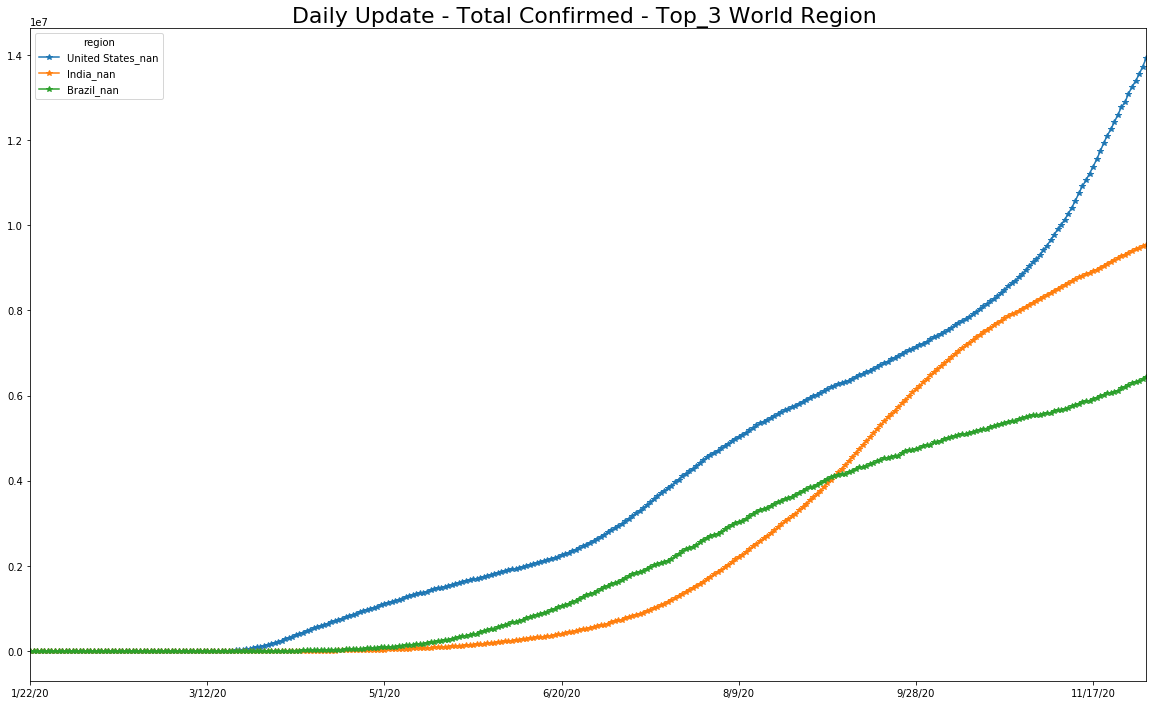

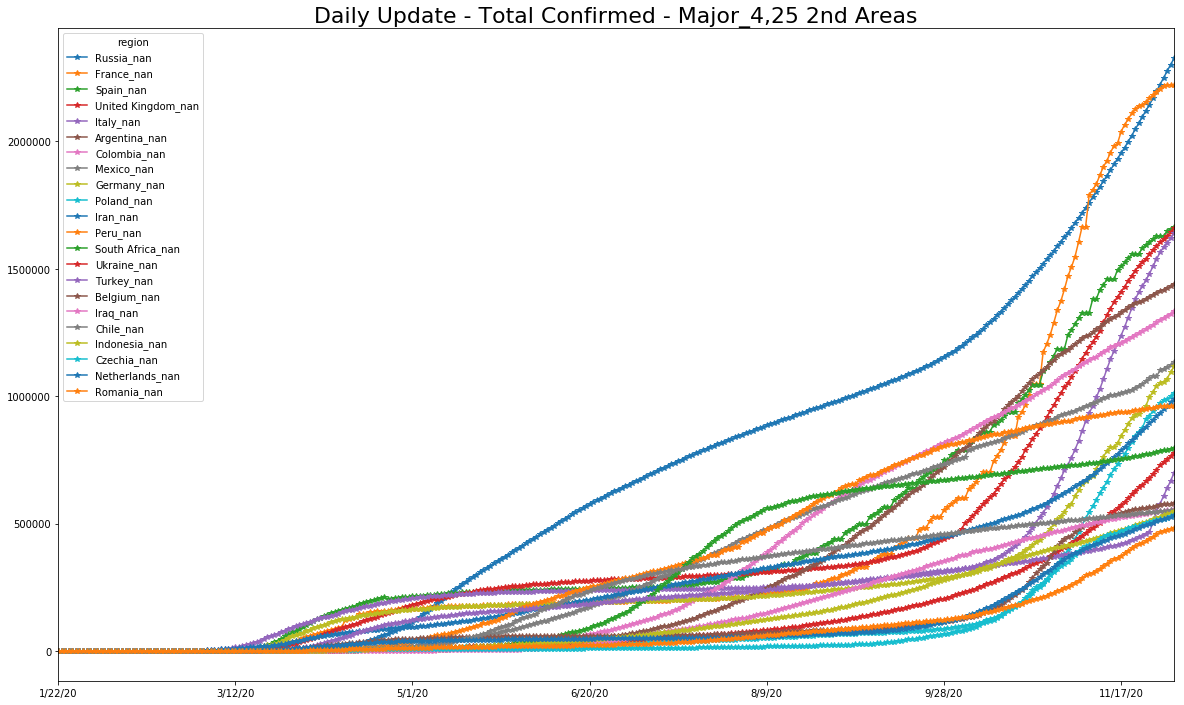

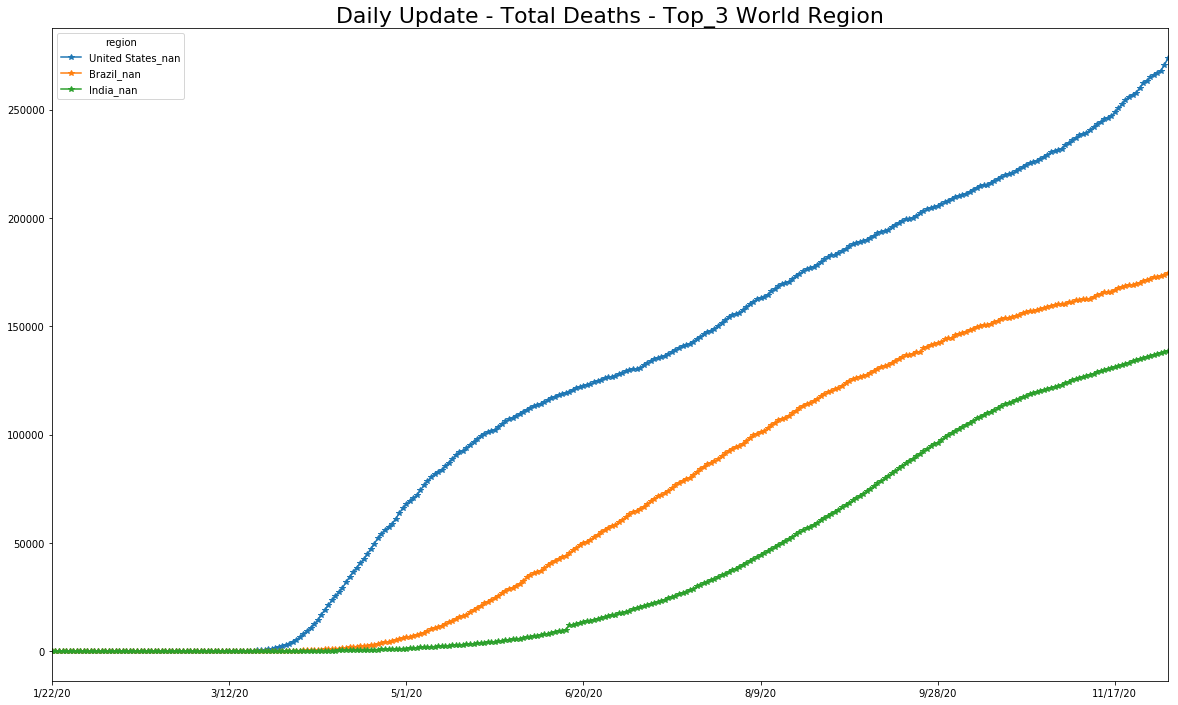

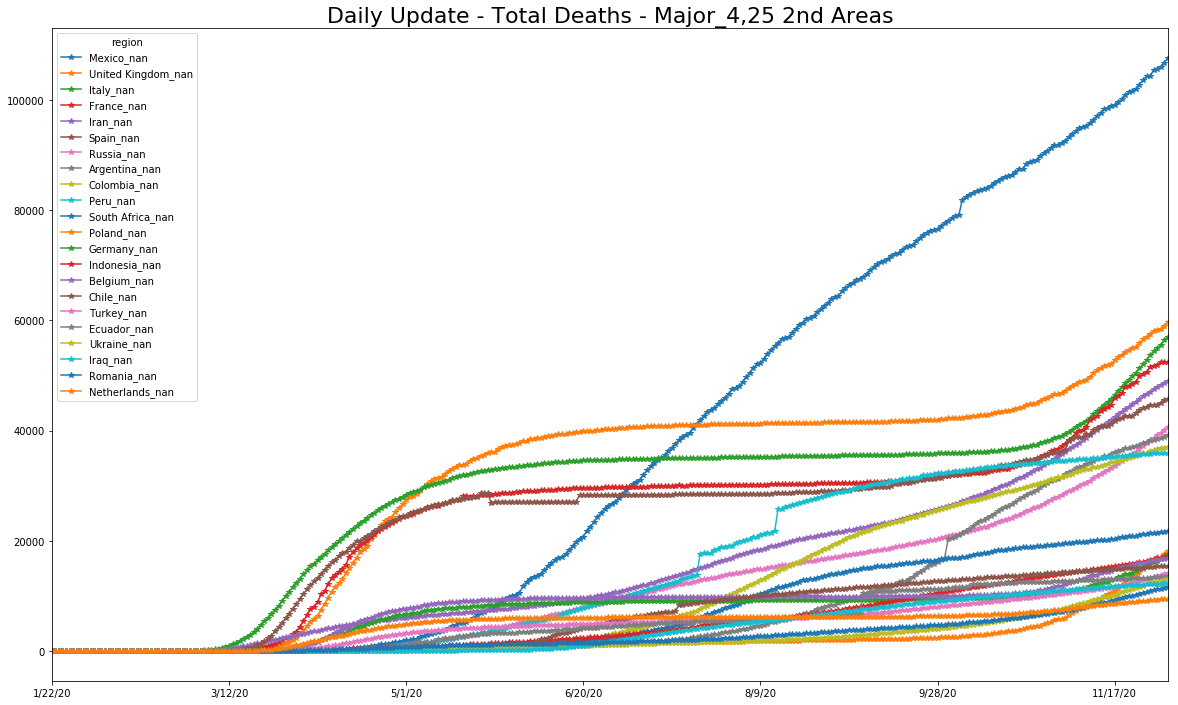

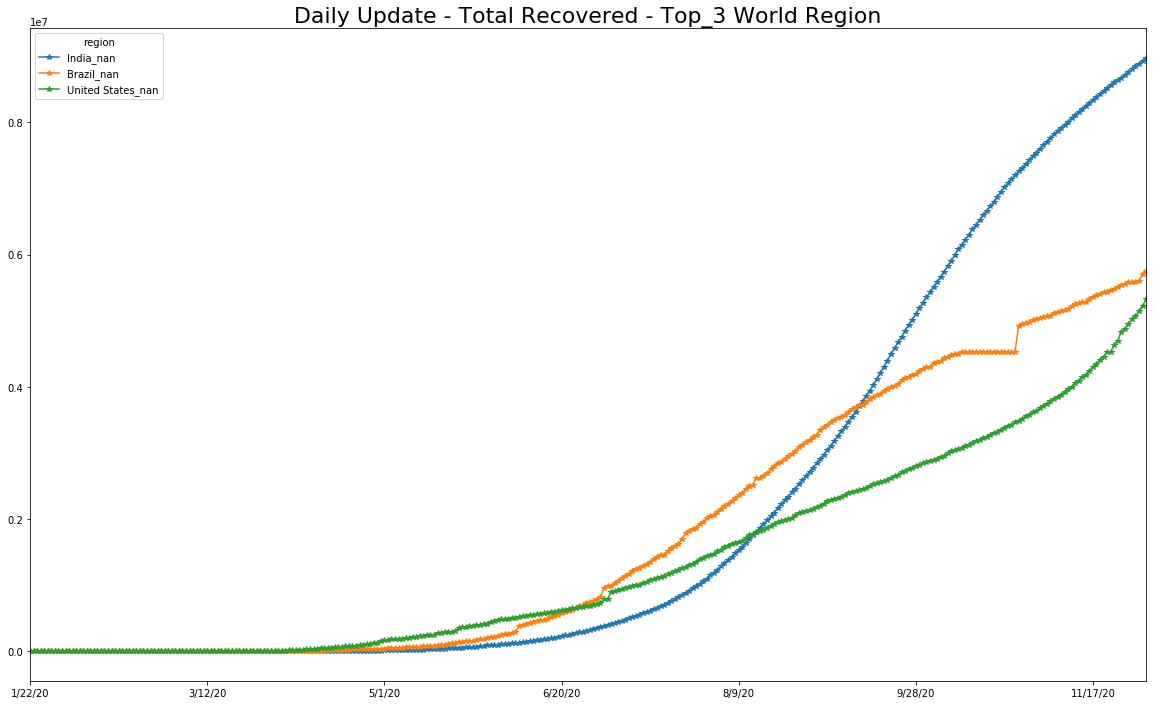

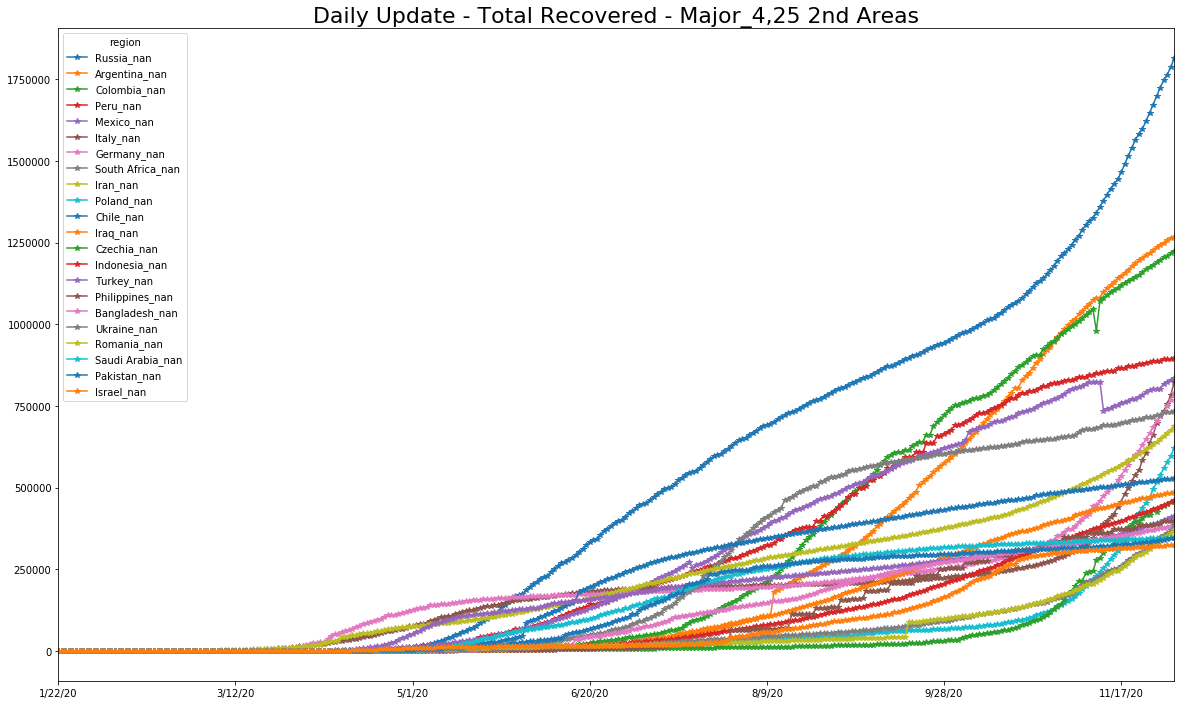

In [16]:
#
p=ts.reindex(ts.max().sort_values(ascending=False).index, axis=1)
p.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Confirmed - Top_3 World Region ',fontdict={'fontsize': 22})
p.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Confirmed - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

p_d=ts_d.reindex(ts_d.max().sort_values(ascending=False).index, axis=1)
p_d.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Deaths - Top_3 World Region',fontdict={'fontsize': 22})
p_d.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Deaths - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

p_r=ts_rec.reindex(ts_rec.max().sort_values(ascending=False).index, axis=1)
p_r.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Recovered - Top_3 World Region',fontdict={'fontsize': 22})
p_r.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Recovered - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

### Extract Weather Data

In [17]:
#!pip install pyweatherbit
#
from weatherbit.api import Api
import json  
import pandas as pd  
from pandas.io.json import json_normalize 

### API - Joao
from datetime import datetime

#
api_key="29d9e51c56b94621b16297bcdeee9c4d" # hxj@mail.xcom
#

api = Api(api_key)
api.set_granularity('daily')

# # Set the granularity of the API - Options: ['daily','hourly','3hourly']
# # Will only affect forecast requests.

#api.get_forecast(lat='Lat', lon='Lon')
#my_end_date=datetime.today().strftime('%Y-%m-%d')

#### United Kingdom
#lat1='55.378100'
#lon1='-3.436000'
#api.get_history(lat=lat1,lon=lon1, start_date='2020-03-29',end_date=my_end_date)


In [18]:
##
#### My List of Countries and Regions to train and represent data
my_train_list=[
 ### JOAO - LIST of Countries - Start here
     #   'Andorra_nan', 
        'United States_nan',
        'United Kingdom_nan',
        'Italy_nan',
        'Spain_nan',  
        'Netherlands_nan',
        'France_nan', 
        'Belgium_nan',
        'Portugal_nan',
        'Switzerland_nan',
        'Germany_nan',
        'Japan_nan',
        'Poland_nan',
  ### JOAO - LIST of Countries - Finish here
        'Korea, South_nan',
        'China_Hubei',
        'China_Beijing',
        'China_Guangdong',
        'China_Shanghai',
      #  'China_Shanxi',
      #  'China_Sichuan',  'China_Xinjiang',
      #  'China_Yunnan', 'China_Zhejiang',
      #  'China_Anhui', 'China_Beijing',
      #  'China_Chongqing', 'China_Fujian', 'China_Gansu',
      #  'China_Guangdong', 'China_Guangxi', 'China_Guizhou',
      #  'China_Hainan', 'China_Hebei', 'China_Heilongjiang', 'China_Henan',
      #  'China_Hubei', 'China_Hunan', 'China_Inner Mongolia',
      #  'China_Jiangsu', 'China_Jiangxi', 'China_Jilin', 'China_Liaoning',
      #  'China_Ningxia', 'China_Qinghai', 'China_Shaanxi',
      #  'China_Shandong', 'China_Shanghai', 'China_Shanxi',
      #  'China_Sichuan', 'China_Tianjin', 'China_Tibet', 'China_Xinjiang',
      #  'China_Yunnan', 'China_Zhejiang',
      #  'Morocco_nan',
        'Australia_New South Wales',
      # 'Australia_Queensland',
      # 'Australia_South Australia', 'Australia_Victoria', 
        'Brazil_nan',
      # 'Cambodia_nan',
      # 'Canada_British Columbia',
        'Canada_Ontario',
        'Canada_Quebec',
      # 'Egypt_nan',
        'China_Hong Kong',
        'China_Macau',
        'Finland_nan',
        'India_nan',
        'Iran_nan',
        'Malaysia_nan',
      # 'Nepal_nan',
        'Norway_nan',
        'Philippines_nan', 'Russia_nan', 'Singapore_nan',
     #  'Sri Lanka_nan', 'Thailand_nan', 'United Arab Emirates_nan',
        'Sweden_nan',
        'Austria_nan',
     #  'Taiwan*_nan', 
     #  'Vietnam_nan',
        'Turkey_nan',
        'Peru_nan',
        'Chile_nan',
        'Mexico_nan'
       ]
#

#### Weather History

In [19]:
# ################## already done since API is limited to 500 call per day
## consume Wether data From 15/03/2020 forward to end_date=30/03/2020
#
### Location in confirmed array to start in pos 1='Albania_nan' 61 = 'China_Hong Kong'
### Only run for Countries in above : my_train_list 
vpos=len(confirmed.iloc[1])-1 #90# 89 #88 #87 #86 #85 #84 #83 #82 #81 #80 #79 #78 #77 #76 #75 #74 #1 #73
print('xcountry_region='+confirmed.iloc[1,vpos])

my_weather_fetch_list= my_train_list # ['Canada_Quebec'] #  ['Iran_nan'] #['Brazil_nan'] #

start_date_init=pd.to_datetime('today').strftime('%Y/%m/%d') # '2020-04-18'
print('start_date_init=',start_date_init)
offset_days=-1 # -1 to start yesterday pick today # API free-tier just picks one per api call!
max_days=1 #1

w=pd.DataFrame(columns=['date','region','min','max'])
if bypass_weather != 1 :
    for h in range(0,max_days):
        offset_days=h
        start_date=pd.to_datetime(start_date_init)
        #
        end_date=(start_date+pd.DateOffset(days=offset_days+1)).strftime('%Y-%m-%d')
        start_date=(start_date+pd.DateOffset(days=offset_days)).strftime('%Y-%m-%d')
        prnt_start_date=pd.to_datetime(start_date).strftime('%Y/%m/%d')
        prnt_end_date=pd.to_datetime(end_date).strftime('%Y/%m/%d')
        #
        for i in range (1,len(confirmed)):
            if confirmed.iloc[i,vpos] not in my_weather_fetch_list:
                continue
            if confirmed.iloc[i,vpos] in my_weather_fetch_list:
                #
                # Clean JSON structure return from API Call
                jas=""
                jas=api.get_history(lat=confirmed.iloc[i,2], lon=confirmed.iloc[i,3], start_date=start_date,end_date=end_date).json
                if (((json_normalize(jas['data'])['min_temp'].values[0])=='')
                     or (np.isnan((json_normalize(jas['data'])['min_temp'].values[0])) == True )):
                    continue
                try:
                    w=w.append({'date':prnt_end_date,'region':confirmed.iloc[i,vpos] ,'min':json_normalize(jas['data'])['min_temp'].values[0],'max':json_normalize(jas['data'])['max_temp'].values[0]}, ignore_index=True)
                except Exception:
                    w=w.append({'date':prnt_end_date,'region':confirmed.iloc[i,vpos] ,'min':None,'max':None}, ignore_index=True)
    #        
#
table_columns=['date','region','min','max']
w = w[w.columns.intersection(table_columns)]

xcountry_region=Albania_nan
start_date_init= 2020/12/03


In [20]:
w.to_csv('data/w_v2_v227.csv', index = False, header=True)

In [21]:
w[:]

Empty DataFrame
Columns: [date, region, min, max]
Index: []

## Kalman Filter With R

In [22]:
# Joao - FIX - Improve Performance 
### Drop the Months of Jan, Feb < 06/02 as
### they are too in the Past and model no longuer trains in China Hubei only!
#
## DROP_N=75 => 07/04

drop_n=drop_n_dataset_days

ts=ts[drop_n:]
ts_d=ts_d[drop_n:]
ts_rec=ts_rec[drop_n:]

In [23]:
ts[:3]

region   Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  Angola_nan  \
7/15/20            34984         3752        20770          862         576   
7/16/20            35060         3851        21355          877         607   
7/17/20            35219         3906        21948          880         638   

region   Antigua and Barbuda_nan  Argentina_nan  Armenia_nan  \
7/15/20                       74         111146        33005   
7/16/20                       74         114783        33559   
7/17/20                       76         119301        34001   

region   Australia_Australian Capital Territory  Australia_New South Wales  \
7/15/20                                     113                       3527   
7/16/20                                     113                       3535   
7/17/20                                     113                       3550   

region   ...  Uruguay_nan  Uzbekistan_nan  Vanuatu_nan  Venezuela_nan  \
7/15/20  ...         1009           14581            0          10428   
7/16/20  ...         1026           15066            0          10854   
7/17/20  ...         1037           15607            0          11191   

region   Vietnam_nan  West Bank and Gaza_nan  Western Sahara_nan  Yemen_nan  \
7/15/20          381                    7064                  10       1526   
7/16/20          381                    7412                  10       1552   
7/17/20          382                    7764                  10       1576   

region   Zambia_nan  Zimbabwe_nan  
7/15/20        1895          1089  
7/16/20        1895          1362  
7/17/20        2810          1420  

[3 rows x 271 columns]

In [24]:
ts[-4:]

region    Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  Angola_nan  \
11/29/20            46116        37625        82221         6712       15103   
11/30/20            46274        38182        83199         6745       15139   
12/1/20             46717        39014        84152         6790       15251   
12/2/20             46980        39719        85084         6842       15319   

region    Antigua and Barbuda_nan  Argentina_nan  Armenia_nan  \
11/29/20                      141        1418807       134768   
11/30/20                      141        1424533       135124   
12/1/20                       142        1432570       135967   
12/2/20                       144        1440103       137231   

region    Australia_Australian Capital Territory  Australia_New South Wales  \
11/29/20                                     117                       4577   
11/30/20                                     117                       4582   
12/1/20                                      117                       4588   
12/2/20                                      117                       4597   

region    ...  Uruguay_nan  Uzbekistan_nan  Vanuatu_nan  Venezuela_nan  \
11/29/20  ...         5716           72870            1         102040   
11/30/20  ...         5857           73094            1         102394   
12/1/20   ...         6024           73276            1         102621   
12/2/20   ...         6225           73335            1         103067   

region    Vietnam_nan  West Bank and Gaza_nan  Western Sahara_nan  Yemen_nan  \
11/29/20         1343                   83585                  10       2177   
11/30/20         1347                   85647                  10       2191   
12/1/20          1351                   88004                  10       2197   
12/2/20          1358                   90192                  10       2217   

region    Zambia_nan  Zimbabwe_nan  
11/29/20       17608          9822  
11/30/20       17647          9950  
12/1/20        17665         10129  
12/2/20        17700         10129  

[4 rows x 271 columns]

In [25]:
# Create data for R script
ts_conf=ts.reset_index()
ts_conf=ts_conf.rename(columns = {'index':'date'})
ts_conf['date']=pd.to_datetime(ts_conf['date'] ,errors ='coerce')
ts_conf.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv')

ts_rec=ts_rec.reset_index()
ts_rec=ts_rec.rename(columns = {'index':'date'})
ts_rec['date']=pd.to_datetime(ts_rec['date'] ,errors ='coerce')
ts_rec.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_rec_r.csv')


ts_d=ts_d.reset_index()
ts_d=ts_d.rename(columns = {'index':'date'})
ts_d['date']=pd.to_datetime(ts_d['date'] ,errors ='coerce')
ts_d.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_d_r.csv')


In [26]:
%%R

#install.packages('pracma')
#install.packages('Metrics')
#install.packages('readr')
#install.packages('reshape')

Sys.setenv(TZ='GMT')
Sys.timezone()

[1] "GMT"


In [27]:
%%R
require(pracma)
require(Metrics)
require(readr)
all<- read_csv("/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv")
all$X1<-NULL
date<-all[,1]
date[nrow(date) + 1,1] <-all[nrow(all),1]+1
pred_all<-NULL
for (n in 2:ncol(all)-1) {
  Y<-ts(data = all[n+1], start = 1, end =nrow(all)+1)  
  sig_w<-0.01
  w<-sig_w*randn(1,100) # acceleration which denotes the fluctuation (Q/R) rnorm(100, mean = 0, sd = 1)
  sig_v<-0.01
  v<-sig_v*randn(1,100)   
  t<-0.45
  phi<-matrix(c(1,0,t,1),2,2)
  gama<-matrix(c(0.5*t^2,t),2,1)
  H<-matrix(c(1,0),1,2)
  #Kalman
  x0_0<-p0_0<-matrix(c(0,0),2,1)
  p0_0<-matrix(c(1,0,0,1),2,2)
  Q<-0.01
  R<-0.01
  X<-NULL
  X2<-NULL
  pred<-NULL
  for (i in 0:nrow(all)) {
    namp <-paste("p", i+1,"_",i, sep = "")
    assign(namp, phi%*%(get(paste("p", i,"_",i, sep = "")))%*%t(phi)+gama%*%Q%*%t(gama))
    namk <- paste("k", i+1, sep = "")
    assign(namk,get(paste("p", i+1,"_",i, sep = ""))%*%t(H)%*%(1/(H%*%get(paste("p", i+1,"_",i, sep = ""))%*%t(H)+R)))
    namx <- paste("x", i+1,"_",i, sep = "")
    assign(namx,phi%*%get(paste("x", i,"_",i, sep = "")))
    namE <- paste("E", i+1, sep = "")
    assign(namE,Y[i+1]-H%*%get(paste("x", i+1,"_",i, sep = "")))
    namx2 <- paste("x", i+1,"_",i+1, sep = "")
    assign(namx2,get(paste("x", i+1,"_",i, sep = ""))+get(paste("k", i+1, sep = ""))%*%get(paste("E", i+1, sep = "")))
    namp2 <- paste("p", i+1,"_",i+1, sep = "")
    assign(namp2,(p0_0-get(paste("k", i+1, sep = ""))%*%H)%*%get(paste("p", i+1,"_",i, sep = "")))
    X<-rbind(X,get(paste("x", i+1,"_",i,sep = ""))[1])
    X2<-rbind(X2,get(paste("x", i+1,"_",i,sep = ""))[2])
    if(i>2){
      remove(list=(paste("p", i-1,"_",i-2, sep = "")))
      remove(list=(paste("k", i-1, sep = "")))
      remove(list=(paste("E", i-1, sep = "")))
      remove(list=(paste("p", i-2,"_",i-2, sep = "")))
      remove(list=(paste("x", i-1,"_",i-2, sep = "")))
      remove(list=(paste("x", i-2,"_",i-2, sep = "")))}
  }
  pred<-NULL
  pred<-cbind(Y,X,round(X2,4))
  pred<-as.data.frame(pred)
  pred$region<-colnames(all[,n+1])
  pred$date<-date$date
  pred$actual<-rbind(0,(cbind(pred[2:nrow(pred),1])/pred[1:nrow(pred)-1,1]-1)*100)
  pred$predict<-rbind(0,(cbind(pred[2:nrow(pred),2])/pred[1:nrow(pred)-1,2]-1)*100)
  pred$pred_rate<-(pred$X/pred$Y-1)*100
  pred$X2_change<-rbind(0,(cbind(pred[2:nrow(pred),3]-pred[1:nrow(pred)-1,3])))
  pred_all<-rbind(pred_all,pred)
}
pred_all<-cbind(pred_all[,4:5],pred_all[,1:3])
names(pred_all)[5]<-"X2"
pred_all=pred_all[with( pred_all, order(region, date)), ]
pred_all<-pred_all[,3:5]

R[write to console]: Loading required package: pracma

R[write to console]: Loading required package: Metrics

R[write to console]: Loading required package: readr

R[write to console]: 
── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  date = col_date(format = "")
)
ℹ Use `spec()` for the full column specifications.




In [28]:
p=%R pred_all

In [29]:
############ Merge R output due to package problem
### Joao FIX - 
# t=ts_d    -  deaths
# t=ts_rec  -  recovered
# t=ts      -  confirmed
t=ts
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

temp=t.iloc[:,:3]
temp=temp.reset_index(drop=True)
for i in range(1,len(t)+1):
  if(temp.iloc[i,1] is not temp.iloc[i-1,1]):
    temp.loc[len(temp)+1] = [temp.iloc[i-1,0]+ pd.DateOffset(1),temp.iloc[i-1,1], 0] 
temp=temp.sort_values(['region', 'date'])
temp=temp.reset_index(drop=True)
temp['Y']=p['Y']
temp['X']=p['X']
temp['X2']=p['X2']

# JOAO - FIX - temp fixed
# Y,X,X2 nan issue from p revolved

p_pd=pd.DataFrame(p,columns=['Y','X','X2'])

p_pd['nindex'] = range(1, 1+len(p_pd))
temp['nindex']= range(1,1+len(temp))

#temp_1 = temp.join(p_pd)
temp_1 = temp.merge(p_pd, on='nindex', how='inner', suffixes=('_1', '_2')).rename(columns={"Y_2": "Y", "X_2": "X", "X2_2" : "X2"})
temp_1 = temp_1.drop(columns=['Y_1', 'X_1','X2_1','nindex'])


temp=temp_1
temp.to_csv(r'/home/notebookuser/notebooks/covid19/data/temp.csv')

## Pre Proccessing Data for ML Model

### Extract Weather Forecast Data

In [30]:
#
### Joao - Test Later Weather from new file : w_v2.csv and w_v2_v2.csv
w_v2=pd.read_csv('data/w_v2.csv', sep=',', encoding='latin1')
w_v2['date']=pd.to_datetime(w_v2['date'],format='%Y/%m/%d')

w_v2_v2=pd.read_csv('data/w_v2_v2.csv', sep=',', encoding='latin1')
w_v2_v2['date']=pd.to_datetime(w_v2_v2['date'],format='%Y/%m/%d')

w_v2_v227=pd.read_csv('data/w_v2_v227.csv', sep=',', encoding='latin1')
w_v2_v227['date']=pd.to_datetime(w_v2_v227['date'],format='%Y/%m/%d')

w=pd.read_csv('data/w.csv', sep=',', encoding='latin1')
w['date']=pd.to_datetime(w['date'],format='%d/%m/%Y')

w_forecast=pd.read_csv('data/w_forecast.csv', sep=',', encoding='latin1')
w_forecast['date']=pd.to_datetime(w_forecast['date'],format='%d/%m/%Y')

### Append Weather fetched now to file w_v2_v2
w_n_forward=w_v2_v2.append(w_v2_v227) 
w_n_forward=w_n_forward.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
w_n_forward=w_n_forward.sort_values(by=['region','date'], ascending=True)
w_n_forward.to_csv(r'data/w_v2_v2.csv', index = False, header=True)

In [31]:
w_total=pd.DataFrame(columns=['date','region','min','max'])
w_total=w.append(w_forecast).append(w_v2).append(w_v2_v2).append(w_v2_v227) 
w_total=w_total.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
w_total=w_total.sort_values(by=['region','date'], ascending=True)

w_total.to_csv(r'data/w_total.csv', index = False, header=True)

In [32]:
w_in_model=pd.read_csv('data/w_total.csv', sep=',', encoding='latin1')
#
w_in_model['date']=pd.to_datetime(w_in_model['date'],format='%Y/%m/%d')
w_in_model.to_csv(r'data/w_in_model.csv', index = False, header=True)

In [33]:
w_in_model.tail(2)

date       region   min   max
8009 2020-05-10  Vietnam_nan  26.9  33.0
8010 2020-05-11  Vietnam_nan  25.0  33.0

### Build Train Set Data Structure

In [34]:
### JOAO - Fix -
## t=ts confirmed
t=ts
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

# Add 1 Future day for prediction
t=t.reset_index(drop=True)
for i in range(1,len(t)+1):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        t.loc[len(t)+1] = [t.iloc[i-1,0]+ pd.DateOffset(1),t.iloc[i-1,1], 0] 
t=t.sort_values(['region', 'date'])
t=t.reset_index(drop=True)

In [35]:
### JOAO - Fix -
t['1_day_change']=t['3_day_change']=t['7_day_change']=t['1_day_change_rate']=t['3_day_change_rate']=t['7_day_change_rate']=t['last_day']=0
#
### JOAO - Fix - ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
for i in range(1,len(t)):
    if(t.iloc[i,1] is t.iloc[i-2,1]):
        t.iloc[i,3]=t.iloc[i-1,2]-t.iloc[i-2,2]
        t.iloc[i,6]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-2,2]*100 -1 +1))*100
        t.iloc[i,9]=t.iloc[i-1,2]
    if(t.iloc[i,1] is t.iloc[i-4,1]):
        t.iloc[i,4]=t.iloc[i-1,2]-t.iloc[i-4,2]
        t.iloc[i,7]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-4,2]*100 -1 +1))*100
    if(t.iloc[i,1] is t.iloc[i-8,1]):
        t.iloc[i,5]=t.iloc[i-1,2]-t.iloc[i-8,2]
        t.iloc[i,8]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-8,2]*100 -1 +1))*100
t=t.fillna(0)  
t=t.merge(temp[['date','region', 'X']],how='left',on=['date','region'])
t=t.rename(columns = {'X':'kalman_prediction'}) 
t=t.replace([np.inf, -np.inf], 0)

### Joao - Fix NaN Kalman_Filter
t['kalman_prediction']=np.nan_to_num(t['kalman_prediction'])
t['kalman_prediction']=round(t['kalman_prediction'])

#
train=t.merge(confirmed[['region',' Population ']],how='left',on='region')
train=train.rename(columns = {' Population ':'population'})
train['population']=train['population'].str.replace(r" ", '')
train['population']=train['population'].str.replace(r",", '')
train['population']=train['population'].fillna(10000000) ### Fill 10M if nan
train['population']=train['population'].astype('int32')
### JOAO - Fix - ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
# train['infected_rate']=train['last_day']/train['population']*10000
train['infected_rate']=(((train['last_day'] +1)*100)/((train['population'] +1)*100000) *10) # *100 - % converter
 #
#### Joao , merge w weather only !?!
##train=train.merge(w,how='left',on=['date','region'])
train=train.merge(w_in_model,how='left',on=['date','region'])
#
train=train.sort_values(['region', 'date'])
### fill missing weather 
for i in range(0,len(train)):
    if(np.isnan(train.iloc[i,13])):
        if(train.iloc[i,1] is train.iloc[i-1,1]):
            train.iloc[i,13]=train.iloc[i-1,13]
            train.iloc[i,14]=train.iloc[i-1,14]

/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in long_scalars
  
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in long_scalars
  if sys.path[0] == '':
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in long_scalars
  from ipykernel import kernelapp as app


In [36]:
# Joao - Fix - Nulls are an issue
train_notnull=train[train['kalman_prediction'] != 0.0 ] #.any(axis=1)]
train_notnull[:]

date           region  confirmed  1_day_change  3_day_change  \
1     2020-07-16  Afghanistan_nan      35060             0             0   
2     2020-07-17  Afghanistan_nan      35219            76             0   
3     2020-07-18  Afghanistan_nan      35279           159             0   
4     2020-07-19  Afghanistan_nan      35453            60           295   
5     2020-07-20  Afghanistan_nan      35493           174           393   
6     2020-07-21  Afghanistan_nan      35605            40           274   
7     2020-07-22  Afghanistan_nan      35717           112           326   
8     2020-07-23  Afghanistan_nan      35918           112           264   
9     2020-07-24  Afghanistan_nan      35978           201           425   
10    2020-07-25  Afghanistan_nan      36026            60           373   
11    2020-07-26  Afghanistan_nan      36147            48           309   
12    2020-07-27  Afghanistan_nan      36253           121           229   
13    2020-07-28  Afghanistan_nan      36358           106           275   
14    2020-07-29  Afghanistan_nan      36463           105           332   
15    2020-07-30  Afghanistan_nan      36532           105           316   
16    2020-07-31  Afghanistan_nan      36665            69           279   
17    2020-08-01  Afghanistan_nan      36700           133           307   
18    2020-08-02  Afghanistan_nan      36701            35           237   
19    2020-08-03  Afghanistan_nan      36737             1           169   
20    2020-08-04  Afghanistan_nan      36773            36            72   
21    2020-08-05  Afghanistan_nan      36820            36            73   
22    2020-08-06  Afghanistan_nan      36928            47           119   
23    2020-08-07  Afghanistan_nan      37006           108           191   
24    2020-08-08  Afghanistan_nan      37046            78           233   
25    2020-08-09  Afghanistan_nan      37083            40           226   
26    2020-08-10  Afghanistan_nan      37153            37           155   
27    2020-08-11  Afghanistan_nan      37260            70           147   
28    2020-08-12  Afghanistan_nan      37336           107           214   
29    2020-08-13  Afghanistan_nan      37422            76           253   
30    2020-08-14  Afghanistan_nan      37497            86           269   
...          ...              ...        ...           ...           ...   
39304 2020-11-04     Zimbabwe_nan       8427            21            43   
39305 2020-11-05     Zimbabwe_nan       8444            17            53   
39306 2020-11-06     Zimbabwe_nan       8471            17            55   
39307 2020-11-07     Zimbabwe_nan       8498            27            61   
39308 2020-11-08     Zimbabwe_nan       8531            27            71   
39309 2020-11-09     Zimbabwe_nan       8561            33            87   
39310 2020-11-10     Zimbabwe_nan       8610            30            90   
39311 2020-11-11     Zimbabwe_nan       8667            49           112   
39312 2020-11-12     Zimbabwe_nan       8696            57           136   
39313 2020-11-13     Zimbabwe_nan       8765            29           135   
39314 2020-11-14     Zimbabwe_nan       8786            69           155   
39315 2020-11-15     Zimbabwe_nan       8829            21           119   
39316 2020-11-16     Zimbabwe_nan       8897            43           133   
39317 2020-11-17     Zimbabwe_nan       8945            68           132   
39318 2020-11-18     Zimbabwe_nan       8981            48           159   
39319 2020-11-19     Zimbabwe_nan       9046            36           152   
39320 2020-11-20     Zimbabwe_nan       9120            65           149   
39321 2020-11-21     Zimbabwe_nan       9172            74           175   
39322 2020-11-22     Zimbabwe_nan       9220            52           191   
39323 2020-11-23     Zimbabwe_nan       9308            48           174   
39324 2020-11-24     Zimbabwe_nan       9398            88  

In [37]:
# Joao - Fix - Nulls are an issue
train_nulls=train[train['kalman_prediction'].isnull() ] #.any(axis=1)]
train_nulls[:]

Empty DataFrame
Columns: [date, region, confirmed, 1_day_change, 3_day_change, 7_day_change, 1_day_change_rate, 3_day_change_rate, 7_day_change_rate, last_day, kalman_prediction, population, infected_rate, min, max]
Index: []

In [38]:
# Joao - Fix - Nulls are an issue

train_nulls=train[train.isnull().any(axis=1)]
train_nulls[:]
train[-1:]

date        region  confirmed  1_day_change  3_day_change  \
39333 2020-12-03  Zimbabwe_nan          0             0           307   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
39333           621         100.000099         103.125738         106.531447   

       last_day  kalman_prediction  population  infected_rate  min  max  
39333     10129            10250.0    14862924       0.000007  NaN  NaN

In [39]:
## JOAO - FIX Drop Duplicates
train=train.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
## JOAO - FIX Drop empty region='nan_nan'
train=train[train['region']!='nan_nan']
train[-1:]

date        region  confirmed  1_day_change  3_day_change  \
39333 2020-12-03  Zimbabwe_nan          0             0           307   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
39333           621         100.000099         103.125738         106.531447   

       last_day  kalman_prediction  population  infected_rate  min  max  
39333     10129            10250.0    14862924       0.000007  NaN  NaN

In [40]:
train.to_csv(r'data/train.csv', index = False, header=True)

##Shared -- Ratio in Confirmed - 21Day Forecast -- train 25April2020 - I
ratiod=pd.read_csv('data/train.csv', sep=',', encoding='latin1')
todayd=datetime.today().strftime('%Y-%m-%d')
ratiofn="World v2 -- Confirmed - "+str(num_days_R_prediction)+"Day Forecast -- train "+todayd+".csv"

ratiod['population_percentage : infected_rate confirmed']=ratiod['infected_rate']*100
ratiod['population_percentage : factor 9/10 infected_rate confirmed']=ratiod['infected_rate']*1000
ratiod['delta : new_cases']=ratiod['kalman_prediction']-ratiod['last_day']
ratiod['delta : new_cases per 1M hab']=ratiod['delta : new_cases']/ratiod['population']*1000000

### roling 7day_AVG
ratiod['delta : roling 7day AVG']=ratiod['7_day_change']/7
ratiod['delta : aprox 14-day case notification rate per 100k hab']=(ratiod['7_day_change']*2)/ratiod['population']*100000
###

ratiod=ratiod.rename(columns={'kalman_prediction': 'confirmed_prediction', 'last_day': 'confirmed_yesterday'})
ratiod.to_csv(r'data/'+ratiofn, index = False, header=True)
ratiod[-3:]

date        region  confirmed  1_day_change  3_day_change  \
38479  2020-12-01  Zimbabwe_nan      10129           128           236   
38480  2020-12-02  Zimbabwe_nan      10129           179           307   
38481  2020-12-03  Zimbabwe_nan          0             0           307   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
38479           642         101.303299         102.429586         106.897400   
38480           731         101.799095         103.125738         107.778357   
38481           621         100.000099         103.125738         106.531447   

       confirmed_yesterday  ...  population  infected_rate  min  max  \
38479                 9950  ...    14862924       0.000007  NaN  NaN   
38480                10129  ...    14862924       0.000007  NaN  NaN   
38481                10129  ...    14862924       0.000007  NaN  NaN   

       population_percentage : infected_rate confirmed  \
38479                                         0.000670   
38480                                         0.000682   
38481                                         0.000682   

       population_percentage : factor 9/10 infected_rate confirmed  \
38479                                           0.006695             
38480                                           0.006816             
38481                                           0.006816             

       delta : new_cases  delta : new_cases per 1M hab  \
38479               89.0                      5.988055   
38480               53.0                      3.565920   
38481              121.0                      8.141063   

       delta : roling 7day AVG  \
38479                91.714286   
38480               104.428571   
38481                88.714286   

       delta : aprox 14-day case notification rate per 100k hab  
38479                                           8.638946         
38480                                           9.836557         
38481                                           8.356364         

[3 rows x 21 columns]

## Kalman 1 day Prediction with Evaluation

                region           mse          rmse            mae
260  United States_nan  1.404775e+12  1.185232e+06  117573.092199


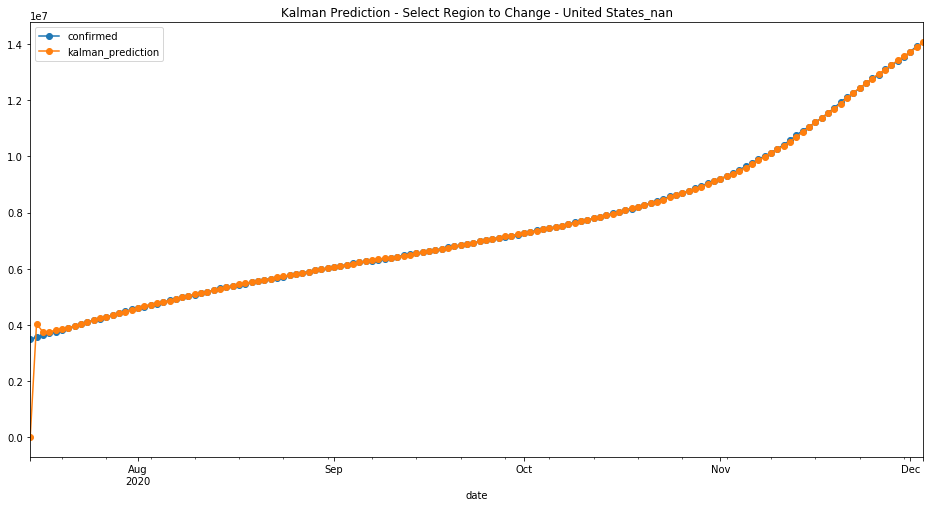

In [41]:
# Select region
region='United States_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

         region           mse         rmse           mae
211  Russia_nan  3.938558e+10  198458.0109  19003.255319


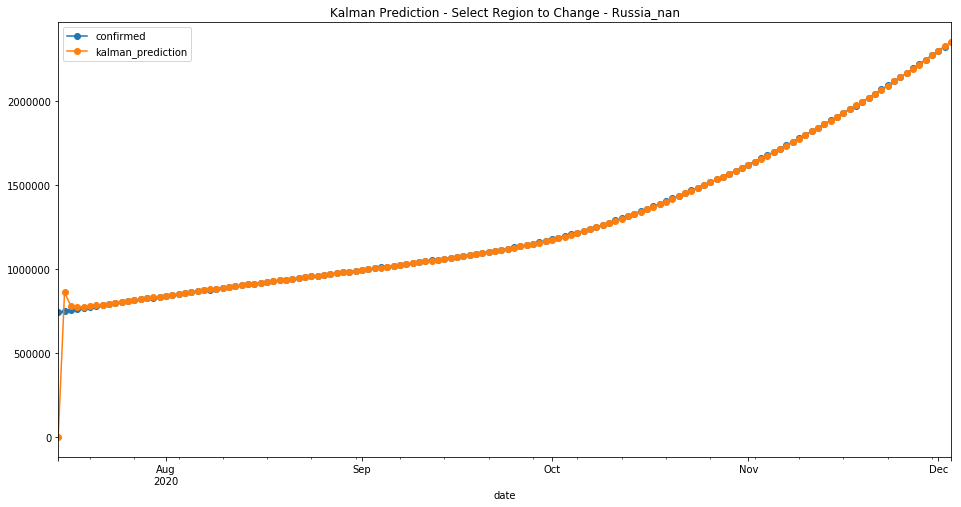

In [42]:
# Select region
region='Russia_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

        region           mse           rmse           mae
30  Brazil_nan  2.973593e+11  545306.579261  62904.758865


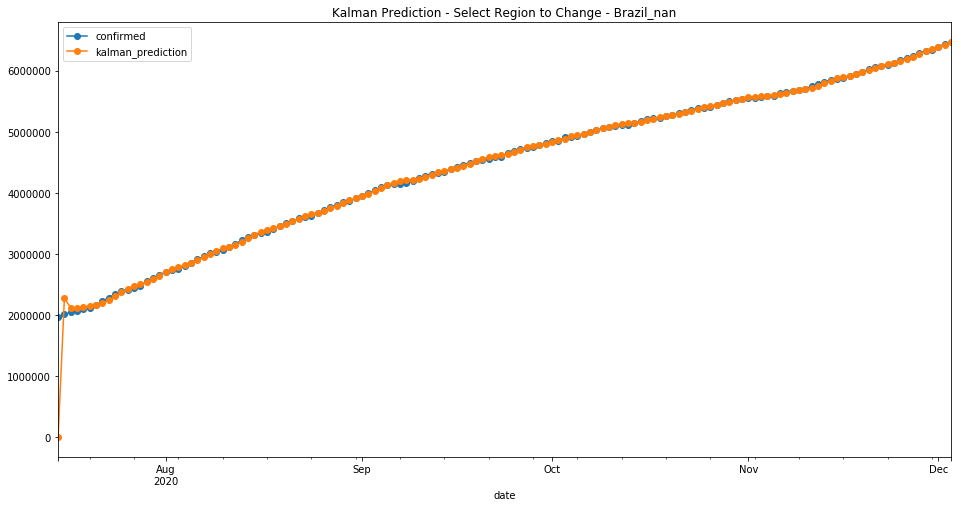

In [43]:
# Select region
region='Brazil_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

                 region           mse           rmse           mae
259  United Kingdom_nan  1.987790e+10  140989.021159  14558.319149


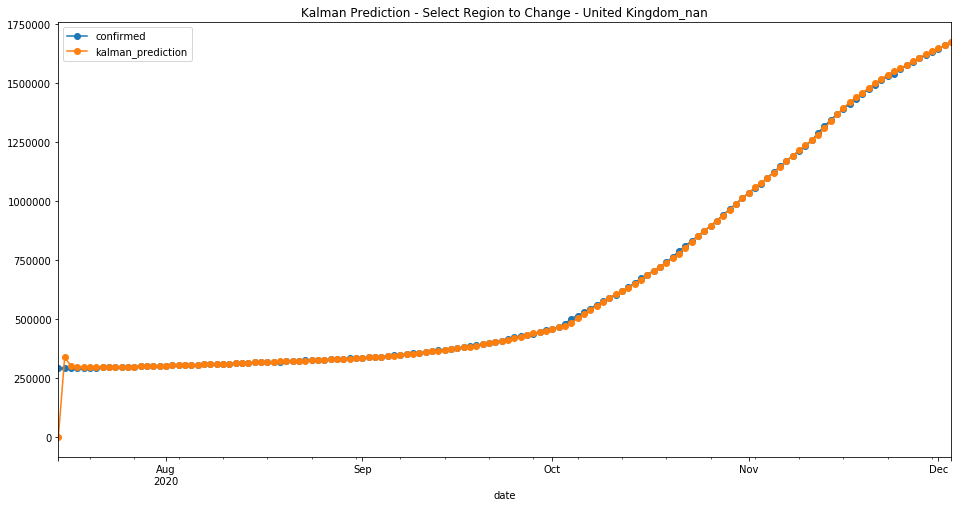

In [44]:
# Select region
region='United Kingdom_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

## Regression - 1 Day Prediction

In [45]:
#!pip install h2o
import h2o
from h2o.estimators import H2ORandomForestEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.grid.grid_search import H2OGridSearch
h2o.init(min_mem_size='3G')
import numpy as np
from sklearn.linear_model import LinearRegression

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.9.1" 2020-11-04; OpenJDK Runtime Environment (build 11.0.9.1+1-Ubuntu-0ubuntu1.18.04); OpenJDK 64-Bit Server VM (build 11.0.9.1+1-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
  Starting server from /home/notebookuser/anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmplopst5zt
  JVM stdout: /tmp/tmplopst5zt/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmplopst5zt/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ------------------------------------------------------------------
H2O_cluster_uptime:         02 secs
H2O_cluster_timezone:       Etc/GMT
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.30.1.3
H2O_cluster_version_age:    2 months and 4 days
H2O_cluster_name:           H2O_from_python_unknownUser_66zaha
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    3.049 Gb
H2O_cluster_total_cores:    10
H2O_cluster_allowed_cores:  10
H2O_cluster_status:         accepting new members, healthy
H2O_connection_url:         http://127.0.0.1:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
H2O_API_Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, TargetEncoder, Core V4
Python_version:             3.7.7 final
--------------------------  ------------------------------------------------------------------

In [46]:

train=train.fillna(0)

########################################################

### Joao - Training  progression - When growth happened 2020/03/05 to 2020/04/12
### Joao - FIX - Refresh this daily forward

### Old Fixed manual ### Last run 17April2020
##
#train_df=train[train['date']>'2020-03-04']
#train_df=train[train['date']<'2020-04-16']
#boots=train_df[train_df['date']>='2020-04-08'] # some bootstrap to give more weight for recent days
#train_df=train_df.append([boots[boots['date']>='2020-04-12']]*1000,ignore_index=True)

### Train progression of the Virus ### In Country list or Spain only
#region_to_train=my_train_list
#train_df_v2=train_df[train_df['region'].isin(region_to_train)] # =='Spain_nan'] #
#test=train[train['date']>='2020-04-03']
#test=test[test['date']<'2020-04-17']
#test_v2=test[test['region'].isin(region_to_train)]
#valid_v2=test_v2[test_v2['date']>='2020-04-16']

########################################################

# Set minimum of 14 training day 2weeks.
#
if number_past_days_training>=7 : 
    ntraindays=number_past_days_training 
else : 
    ntraindays=7
#
to_day=pd.to_datetime('today')
first_train_date=(to_day+pd.DateOffset(days=-ntraindays)).strftime('%Y-%m-%d') # ntraindays/7 weeks =ntraindays days training
last_train_date=(to_day+pd.DateOffset(days=-1)).strftime('%Y-%m-%d')
first_bootstrap_date=(to_day+pd.DateOffset(days=-9)).strftime('%Y-%m-%d')
boost_bootstrap_date=(to_day+pd.DateOffset(days=-4)).strftime('%Y-%m-%d')
first_test_date=(to_day+pd.DateOffset(days=-10)).strftime('%Y-%m-%d')
last_test_date=to_day.strftime('%Y-%m-%d')
first_valid_date=(to_day+pd.DateOffset(days=-2)).strftime('%Y-%m-%d')

print('first_train_date=',first_train_date)
print('last_train_date=',last_train_date)
print('first_bootstrap_date=',first_bootstrap_date)
print('boost_bootstrap_date=',boost_bootstrap_date)
print('first_test_date=',first_test_date)
print('last_test_date=',last_test_date)
print('first_valid_date=',first_valid_date)

train_df=train[train['date']>first_train_date]
train_df=train[train['date']<last_train_date]
boots=train_df[train_df['date']>=first_bootstrap_date] # some bootstrap to give more weight for recent days
train_df=train_df.append([boots[boots['date']>=boost_bootstrap_date]]*5,ignore_index=True)

### Train progression of the Virus ### In Country list or Spain only
region_to_train=my_train_list
train_df_v2=train_df[train_df['region'].isin(region_to_train)] # =='Spain_nan'] #
test=train[train['date']>first_test_date]
test=test[test['date']<=last_test_date]
test_v2=test[test['region'].isin(region_to_train)]
valid_v2=test_v2[test_v2['date']>=first_valid_date]


first_train_date= 2020-11-21
last_train_date= 2020-12-02
first_bootstrap_date= 2020-11-24
boost_bootstrap_date= 2020-11-29
first_test_date= 2020-11-23
last_test_date= 2020-12-03
first_valid_date= 2020-12-01


In [47]:
x_col=[#'region',
            '1_day_change', '3_day_change','7_day_change',
            '1_day_change_rate', 
            '3_day_change_rate',
            '7_day_change_rate', 
            'last_day',
            'min', 'max',
            'infected_rate',
            'kalman_prediction'
          #  ,'population_percent_infected_rate_confirmed'
          #  ,'delta_new_cases'
          #  ,'delta_new_cases_per_1M_hab'
          ]

In [48]:
x=train_df[x_col]
y=train_df['confirmed']
reg = LinearRegression().fit(x,y)

pred2=reg.predict(test[x_col]); pred2=pd.DataFrame(pred2); pred2=round(pred2)
pred2['confirmed']=test['confirmed'].values; pred2['date']=test['date'].values; pred2['region']=test['region'].values


In [49]:
pred2.iloc[:25]

0  confirmed       date           region
0   45255.0      45174 2020-11-24  Afghanistan_nan
1   45459.0      45384 2020-11-25  Afghanistan_nan
2   45674.0      45600 2020-11-26  Afghanistan_nan
3   45888.0      45723 2020-11-27  Afghanistan_nan
4   46034.0      45844 2020-11-28  Afghanistan_nan
5   46156.0      46116 2020-11-29  Afghanistan_nan
6   46372.0      46274 2020-11-30  Afghanistan_nan
7   46538.0      46717 2020-12-01  Afghanistan_nan
8   46914.0      46980 2020-12-02  Afghanistan_nan
9   47221.0          0 2020-12-03  Afghanistan_nan
10  34194.0      34300 2020-11-24      Albania_nan
11  34947.0      34944 2020-11-25      Albania_nan
12  35634.0      35600 2020-11-26      Albania_nan
13  36287.0      36245 2020-11-27      Albania_nan
14  36920.0      36790 2020-11-28      Albania_nan
15  37476.0      37625 2020-11-29      Albania_nan
16  38196.0      38182 2020-11-30      Albania_nan
17  38804.0      39014 2020-12-01      Albania_nan
18  39564.0      39719 2020-12-02      Albania_nan
19  40291.0          0 2020-12-03      Albania_nan
20  76950.0      77000 2020-11-24      Algeria_nan
21  78086.0      78025 2020-11-25      Algeria_nan
22  79134.0      79110 2020-11-26      Algeria_nan
23  80227.0      80168 2020-11-27      Algeria_nan
24  81291.0      81212 2020-11-28      Algeria_nan

In [50]:
pred2.iloc[175:195]

0  confirmed       date          region
175  117171.0     118195 2020-11-29  Azerbaijan_nan
176  121540.0     121176 2020-11-30  Azerbaijan_nan
177  124889.0     125602 2020-12-01  Azerbaijan_nan
178  129382.0     129544 2020-12-02  Azerbaijan_nan
179  133345.0          0 2020-12-03  Azerbaijan_nan
180    7573.0       7460 2020-11-24     Bahamas_nan
181    7580.0       7469 2020-11-25     Bahamas_nan
182    7616.0       7482 2020-11-26     Bahamas_nan
183    7621.0       7496 2020-11-27     Bahamas_nan
184    7630.0       7496 2020-11-28     Bahamas_nan
185    7647.0       7517 2020-11-29     Bahamas_nan
186    7633.0       7541 2020-11-30     Bahamas_nan
187    7650.0       7543 2020-12-01     Bahamas_nan
188    7685.0       7543 2020-12-02     Bahamas_nan
189    7687.0          0 2020-12-03     Bahamas_nan
190   85611.0      86016 2020-11-24     Bahrain_nan
191   85737.0      86185 2020-11-25     Bahrain_nan
192   85902.0      86347 2020-11-26     Bahrain_nan
193   86063.0      86515 2020-11-27     Bahrain_nan
194   86234.0      86645 2020-11-28     Bahrain_nan

In [51]:
pred2.iloc[220:240]

0  confirmed       date       region
220  126828.0     126953 2020-11-24  Belarus_nan
221  128365.0     128449 2020-11-25  Belarus_nan
222  129896.0     130012 2020-11-26  Belarus_nan
223  131468.0     131633 2020-11-27  Belarus_nan
224  133090.0     133324 2020-11-28  Belarus_nan
225  134786.0     135008 2020-11-29  Belarus_nan
226  136493.0     136647 2020-11-30  Belarus_nan
227  138173.0     138219 2020-12-01  Belarus_nan
228  139789.0     139908 2020-12-02  Belarus_nan
229  141489.0          0 2020-12-03  Belarus_nan
230  563298.0     561803 2020-11-24  Belgium_nan
231  564772.0     564967 2020-11-25  Belgium_nan
232  567316.0     567532 2020-11-26  Belgium_nan
233  569389.0     570829 2020-11-27  Belgium_nan
234  572522.0     574448 2020-11-28  Belgium_nan
235  576100.0     576599 2020-11-29  Belgium_nan
236  578453.0     577345 2020-11-30  Belgium_nan
237  579571.0     579212 2020-12-01  Belgium_nan
238  581427.0     582252 2020-12-02  Belgium_nan
239  584097.0          0 2020-12-03  Belgium_nan

In [52]:
#
train_h20 = h2o.H2OFrame(train_df)
###train_h20_hubei = h2o.H2OFrame(train_df_hubei) # different model for Hubei
#
### Joao - Italian Model
train_h20_v2 = h2o.H2OFrame(train_df_v2) # different model for V2 region ### Spain This time


test_h20 = h2o.H2OFrame(test)
#test_h20_hubei = h2o.H2OFrame(test_hubei)
test_h20_v2 = h2o.H2OFrame(test_v2)

valid_h20_v2=h2o.H2OFrame(valid_v2)

#training_columns = ['region','1_day_change', '3_day_change', '7_day_change','1_day_change_rate','3_day_change_rate','7_day_change_rate','last_day', 'kalman_prediction','infected_rate', 'min', 'max']
training_cols_v2 = ['region']+x_col #+['population_percent_infected_rate_confirmed','delta_new_cases','delta_new_cases_per_1M_hab']
training_columns = training_cols_v2

# Output parameter train against input parameters
response_column = 'confirmed'

# model = H2ORandomForestEstimator(ntrees=300, max_depth=12)
# model.train(x=training_columns, y=response_column, training_frame=train_h20)

###model_hubei = H2ORandomForestEstimator(ntrees=300, max_depth=12)
###model_hubei.train(x=training_columns, y=response_column, training_frame=train_h20_hubei)

### Joao - Model V2
model_v2 = H2ORandomForestEstimator(ntrees=500, max_depth=23)
model_v2.train(x=training_columns, y=response_column, training_frame=train_h20_v2, validation_frame=valid_h20_v2)


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%


In [53]:
#Print Model

print('# MSE on the training data = ',model_v2.mse())
print('# MSE on the validation data = ',model_v2.mse(valid=True))
print('# R^2 on the training data = ',model_v2.r2())
print('# R^2 on the validation data = ',model_v2.r2(valid=True))

# MSE on the training data =  2394422889.167769
# MSE on the validation data =  3022825381504.7305
# R^2 on the training data =  0.9992929369508015
# R^2 on the validation data =  0.45016472893036286


In [54]:
model_v2.show()

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1606976197576_1


Model Summary: 


number_of_trees  number_of_internal_trees  model_size_in_bytes  \
0              500.0                     500.0           18443677.0   

   min_depth  max_depth  mean_depth  min_leaves  max_leaves  mean_leaves  
0       21.0       23.0      22.962      2102.0      3011.0     2885.038



ModelMetricsRegression: drf
** Reported on train data. **

MSE: 2394422889.167769
RMSE: 48932.840599823845
MAE: 4736.032482672197
RMSLE: 0.24762555744287773
Mean Residual Deviance: 2394422889.167769

ModelMetricsRegression: drf
** Reported on validation data. **

MSE: 3022825381504.7305
RMSE: 1738627.4418358668
MAE: 444091.8725458809
RMSLE: 7.17832702291797
Mean Residual Deviance: 3022825381504.7305

Scoring History: 


timestamp    duration  number_of_trees  training_rmse  \
0     2020-12-03 06:16:47   0.108 sec              0.0            NaN   
1     2020-12-03 06:16:47   0.645 sec              1.0   92219.589739   
2     2020-12-03 06:16:47   0.872 sec              2.0   69065.053009   
3     2020-12-03 06:16:48   1.041 sec              3.0   68508.398355   
4     2020-12-03 06:16:48   1.181 sec              4.0   65417.360029   
5     2020-12-03 06:16:48   1.407 sec              5.0   55294.254536   
6     2020-12-03 06:16:48   1.505 sec              6.0   52305.313226   
7     2020-12-03 06:16:48   1.629 sec              7.0   52082.029536   
8     2020-12-03 06:16:48   1.714 sec              8.0   68648.330451   
9     2020-12-03 06:16:48   1.838 sec              9.0   78700.454735   
10    2020-12-03 06:16:49   1.964 sec             10.0   78591.727720   
11    2020-12-03 06:16:49   2.060 sec             11.0   76991.678094   
12    2020-12-03 06:16:49   2.154 sec             12.0   71567.769729   
13    2020-12-03 06:16:49   2.261 sec             13.0   65021.074964   
14    2020-12-03 06:16:49   2.374 sec             14.0   64649.558875   
15    2020-12-03 06:16:49   2.468 sec             15.0   62728.078009   
16    2020-12-03 06:16:49   2.577 sec             16.0   60318.549151   
17    2020-12-03 06:16:49   2.710 sec             17.0   60275.357481   
18    2020-12-03 06:16:49   2.805 sec             18.0   60454.816670   
19    2020-12-03 06:16:49   2.907 sec             19.0   58570.693534   

    training_mae  training_deviance  validation_rmse  validation_mae  \
0            NaN                NaN              NaN             NaN   
1   15008.648360       8.504453e+09     1.694443e+06   436885.569955   
2   11949.922101       4.769982e+09     1.718592e+06   442760.929298   
3   11462.085701       4.693401e+09     1.731061e+06   443679.125444   
4   11075.394011       4.279431e+09     1.739508e+06   444443.486744   
5   10093.073956       3.057455e+09     1.757829e+06   455365.351582   
6    9314.715244       2.735846e+09     1.758823e+06   454349.717288   
7    9154.202970       2.712538e+09     1.755079e+06   451792.692243   
8    9255.874101       4.712593e+09     1.751029e+06   450029.165660   
9    9875.084831       6.193762e+09     1.744795e+06   448602.105055   
10   9854.776383       6.176660e+09     1.745399e+06   447207.845559   
11   9903.966467       5.927718e+09     1.740077e+06   446002.999998   
12   9315.851247       5.121946e+09     1.739572e+06   444426.395715   
13   8770.764701       4.227740e+09     1.740617e+06   444415.691708   
14   8539.505193       4.179565e+09     1.741342e+06   444255.103610   
15   8235.544050       3.934812e+09     1.740970e+06   444123.473237   
16   8082.994193       3.638327e+09     1.741242e+06   444071.329683   
17   8052.802153       3.633119e+09     1.740730e+06   443867.303930   
18   7949.387527       3.654785e+09     1.739769e+06   443193.090321   
19   7752.670880       3.430526e+09     1.740296e+06   444159.297400   

    validation_deviance  
0                   NaN  
1          2.871137e+12  
2          2.953559e+12  
3          2.996572e+12  
4          3.025887e+12  
5          3.089964e+12  
6          3.093459e+12  
7          3.080301e+12  
8          3.066103e+12  
9          3.044311e+12  
10         3.046419e+12  
11         3.027867e+12  
12         3.026112e+12  
13         3.029746e+12  
14         3.032270e+12  
15         3.030978e+12  
16         3.031925e+12  
17         3.030139e+12  
18         3.026798e+12  
19         3.028632e+12


See the whole table with table.as_data_frame()

Variable Importances: 


variable  relative_importance  scaled_importance  percentage
0            last_day         3.040432e+18           1.000000    0.347836
1   kalman_prediction         2.555700e+18           0.840571    0.292381
2              region         1.293167e+18           0.425323    0.147943
3        7_day_change         8.324084e+17           0.273780    0.095230
4        3_day_change         4.411940e+17           0.145109    0.050474
5        1_day_change         3.638221e+17           0.119661    0.041622
6       infected_rate         1.011346e+17           0.033263    0.011570
7   7_day_change_rate         5.012732e+16           0.016487    0.005735
8   3_day_change_rate         2.794670e+16           0.009192    0.003197
9   1_day_change_rate         1.752498e+16           0.005764    0.002005
10                max         1.060338e+16           0.003487    0.001213
11                min         6.936799e+15           0.002282    0.000794

In [55]:
#model_hubei.varimp(True).iloc[:,:] # Feature importance for Hubei Model RF
### Joao -  Model V2
modlv2=model_v2.varimp(True).iloc[:,:] # Feature importance for Model V2 Global RF
modlv2.sort_values('percentage',ascending=False)

variable  relative_importance  scaled_importance  percentage
0            last_day         3.040432e+18           1.000000    0.347836
1   kalman_prediction         2.555700e+18           0.840571    0.292381
2              region         1.293167e+18           0.425323    0.147943
3        7_day_change         8.324084e+17           0.273780    0.095230
4        3_day_change         4.411940e+17           0.145109    0.050474
5        1_day_change         3.638221e+17           0.119661    0.041622
6       infected_rate         1.011346e+17           0.033263    0.011570
7   7_day_change_rate         5.012732e+16           0.016487    0.005735
8   3_day_change_rate         2.794670e+16           0.009192    0.003197
9   1_day_change_rate         1.752498e+16           0.005764    0.002005
10                max         1.060338e+16           0.003487    0.001213
11                min         6.936799e+15           0.002282    0.000794

In [56]:
## Joao - Model Predictions - Country_nan _v2
performance = model_v2.model_performance(test_data=test_h20_v2)
# # Model Create Predictions
pred=model_v2.predict(test_h20_v2);pred=pred.as_data_frame(); pred=round(pred)
# #pred['daily_outcome']=test['daily_outcome'].values
pred['confirmed']=test_v2['confirmed'].values
pred['date']=test_v2['date'].values
pred['region']=test_v2['region'].values

drf prediction progress: |████████████████████████████████████████████████| 100%


## Correlation Matrix And Temperature

Correlation Matrix


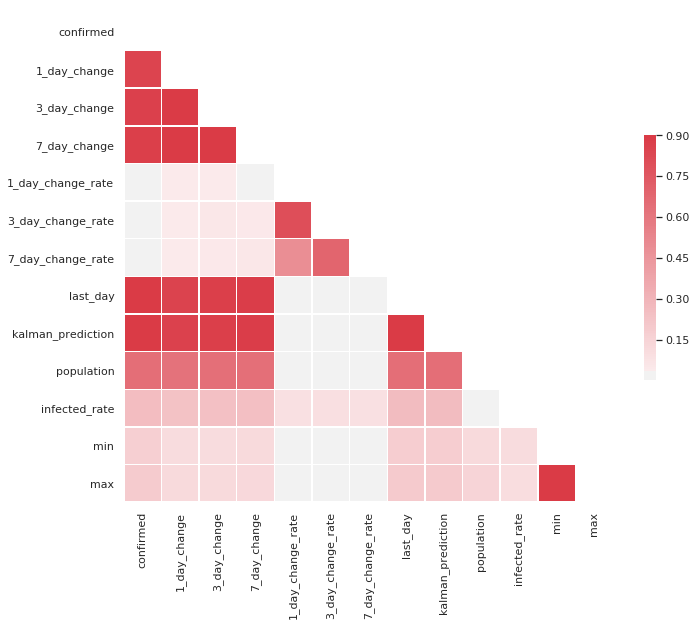

In [57]:
from string import ascii_letters
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white")
# Compute the correlation matrix
corr = train.iloc[:,2:].corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
print ('Correlation Matrix')

In [58]:
print('Correlation To Confirmed') 
print (corr.confirmed)

Correlation To Confirmed
confirmed            1.000000
1_day_change         0.848438
3_day_change         0.866902
7_day_change         0.874726
1_day_change_rate    0.027001
3_day_change_rate    0.027692
7_day_change_rate    0.022273
last_day             0.988772
kalman_prediction    0.989349
population           0.645395
infected_rate        0.262334
min                  0.177310
max                  0.188842
Name: confirmed, dtype: float64


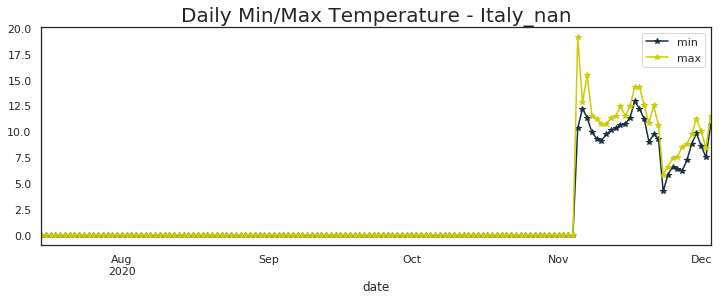

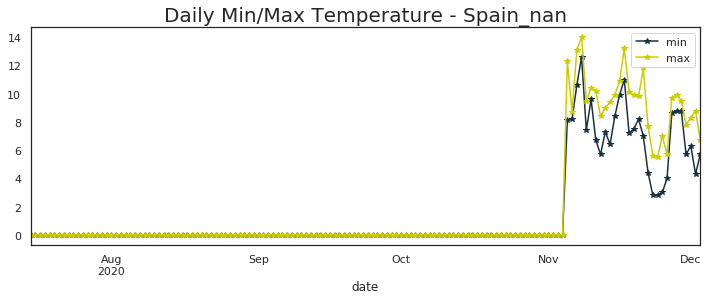

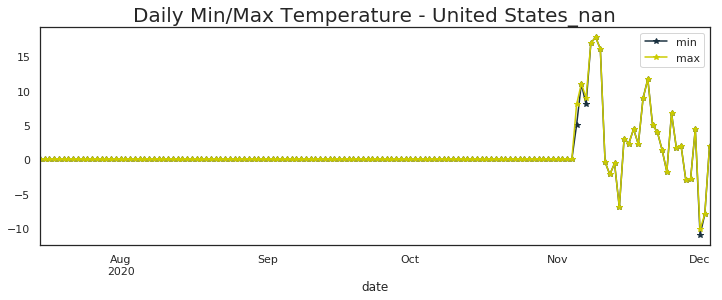

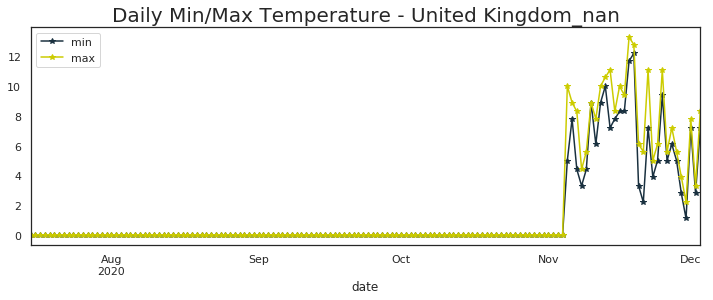

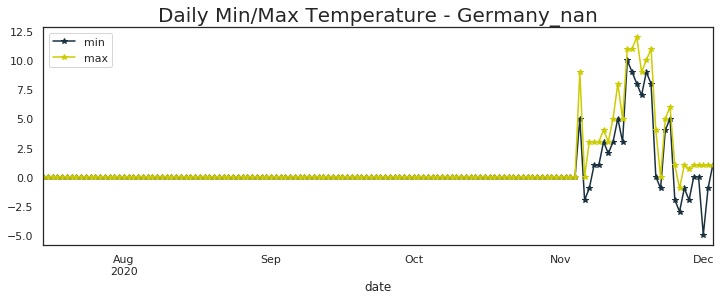

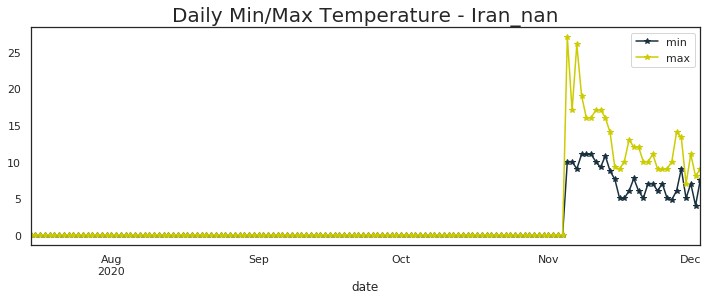

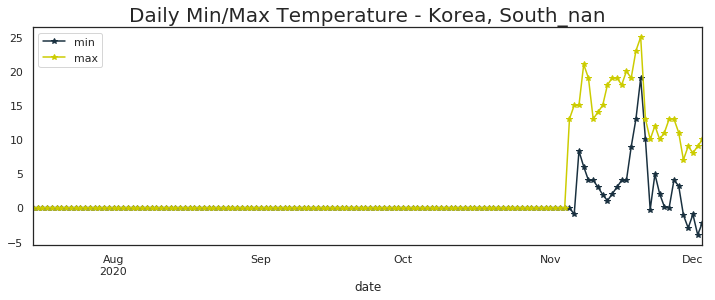

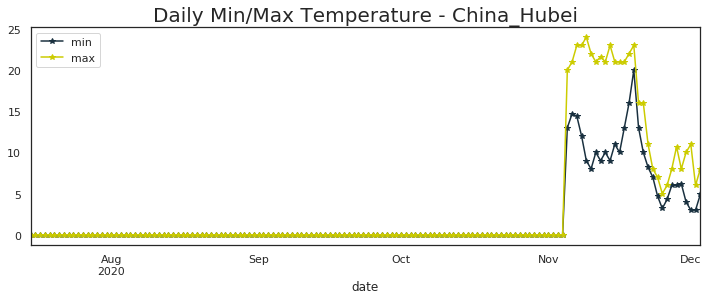

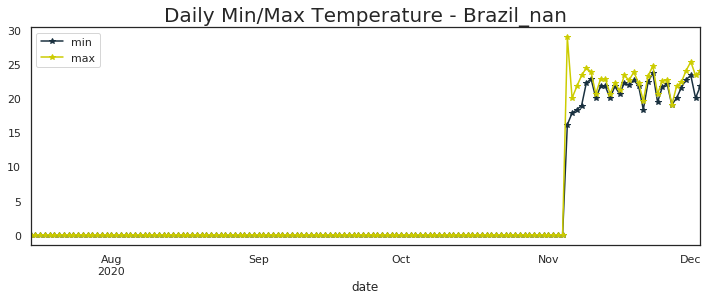

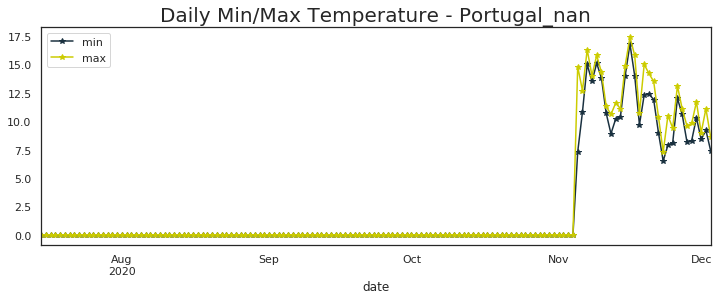

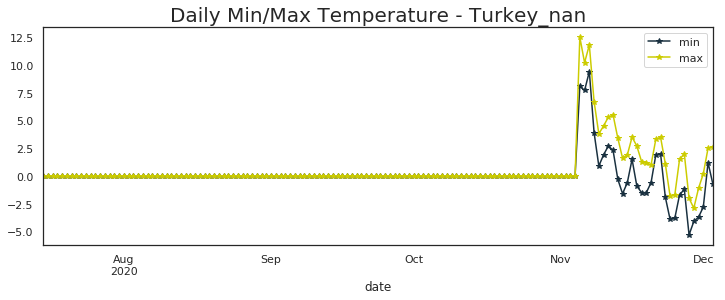

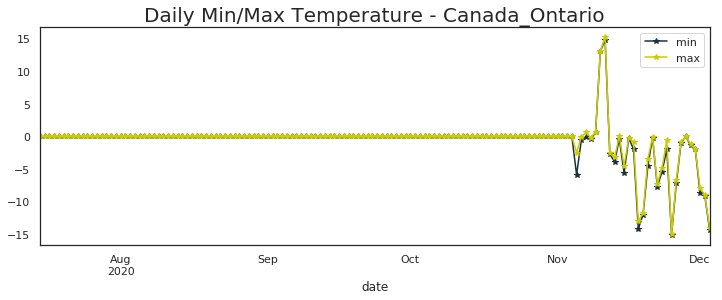

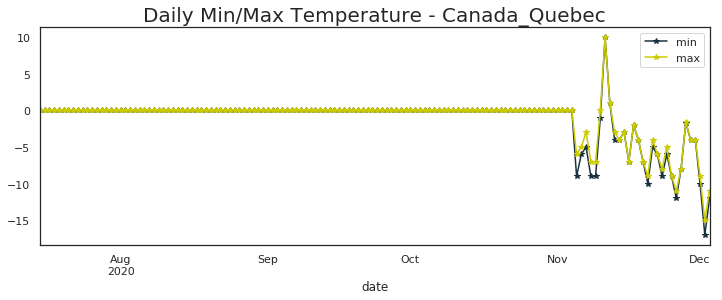

In [59]:
import matplotlib.pyplot as plt
p=train[['date','region','min','max']].set_index('date')
#
#rg1='China_Hubei'
#p=p[p['region']==rg1]
#p.iloc[:,:].plot(marker='*',figsize=(12,4),color=['#19303f','#cccc00']).set_title('Daily Min/Max Temperature - '+rg1,fontdict={'fontsize': 20})
#
## JOAO - Temp. Teast Italy - Data Supply finishes 13/03/2020
region_s=['Italy_nan','Spain_nan','United States_nan','United Kingdom_nan','Germany_nan','Iran_nan',
          'Korea, South_nan','China_Hubei','Brazil_nan','Portugal_nan','Turkey_nan',
          'Canada_Ontario','Canada_Quebec']
p=train[['date','region','min','max']].set_index('date')
for i in range(0,len(region_s)):     
    pv=p[p['region']==region_s[i]]
    pv.iloc[:,:].plot(marker='*',figsize=(12,4),color=['#19303f','#cccc00']).set_title('Daily Min/Max Temperature - '+region_s[i],fontdict={'fontsize': 20})
#

In [60]:
avg_temp=train[['region','confirmed','min','max']]  # from 20-02-20 to 06-04-2020
avg_temp=avg_temp.groupby(by='region').max()
avg_temp=avg_temp.sort_values('confirmed',ascending=False)
print( 'Most infected Areas Avg Temperature')
print(avg_temp.iloc[:100,1:])

Most infected Areas Avg Temperature
                          min   max
region                             
United States_nan        17.8  17.8
India_nan                22.0  31.0
Brazil_nan               23.7  28.9
Russia_nan                0.0   4.0
France_nan               12.1  13.3
Spain_nan                12.6  14.0
United Kingdom_nan       12.2  13.3
Italy_nan                12.9  19.1
Argentina_nan             0.0   0.0
Colombia_nan              0.0   0.0
Mexico_nan               15.1  15.1
Germany_nan              10.0  12.0
Poland_nan                8.9  10.6
Iran_nan                 11.0  27.0
Peru_nan                 24.6  29.9
South Africa_nan          0.0   0.0
Ukraine_nan               0.0   0.0
Turkey_nan                9.4  12.5
Belgium_nan              13.7  14.5
Iraq_nan                  0.0   0.0
Chile_nan                17.0  22.0
Indonesia_nan             0.0   0.0
Czechia_nan               0.0   0.0
Netherlands_nan          14.4  16.1
Romania_nan               0.

### Kalman X Days Ahead Prediction

In [61]:
%%R

#install.packages('reshape')

NULL


In [62]:
%%R

require(pracma)
require(Metrics)
require(readr)
library(reshape)
all<- read_csv("/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv")
all$X1<-NULL

### JOAO - FIX
#
### Flexy Days maximum forward prediction =A Hint!= "Error increases as number of days increases"
days_prediction<-max_days_prediction # Set i days prediction # max_days_prediction=90 days forward prediction with Kalman Filter

for (i in 1: days_prediction) { 
  if( i>1) {all<-all_new}
  date<-all[,1]
  date[nrow(date) + 1,1] <-all[nrow(all),1]+1
  pred_all<-NULL
  for (n in 2:ncol(all)-1) {
    Y<-ts(data = all[n+1], start = 1, end =nrow(all)+1)  
    sig_w<-0.01
    w<-sig_w*randn(1,100) # acceleration which denotes the fluctuation (Q/R) rnorm(100, mean = 0, sd = 1)
    sig_v<-0.01
    v<-sig_v*randn(1,100)  
    t<-0.45
    phi<-matrix(c(1,0,t,1),2,2)
    gama<-matrix(c(0.5*t^2,t),2,1)
    H<-matrix(c(1,0),1,2)
    #Kalman
    x0_0<-p0_0<-matrix(c(0,0),2,1)
    p0_0<-matrix(c(1,0,0,1),2,2)
    Q<-0.01
    R<-0.01
    X<-NULL
    X2<-NULL
    pred<-NULL
    for (i in 0:nrow(all)) {
      namp <-paste("p", i+1,"_",i, sep = "")
      assign(namp, phi%*%(get(paste("p", i,"_",i, sep = "")))%*%t(phi)+gama%*%Q%*%t(gama))
      namk <- paste("k", i+1, sep = "")
      assign(namk,get(paste("p", i+1,"_",i, sep = ""))%*%t(H)%*%(1/(H%*%get(paste("p", i+1,"_",i, sep = ""))%*%t(H)+R)))
      namx <- paste("x", i+1,"_",i, sep = "")
      assign(namx,phi%*%get(paste("x", i,"_",i, sep = "")))
      namE <- paste("E", i+1, sep = "")
      assign(namE,Y[i+1]-H%*%get(paste("x", i+1,"_",i, sep = "")))
      namx2 <- paste("x", i+1,"_",i+1, sep = "")
      assign(namx2,get(paste("x", i+1,"_",i, sep = ""))+get(paste("k", i+1, sep = ""))%*%get(paste("E", i+1, sep = "")))
      namp2 <- paste("p", i+1,"_",i+1, sep = "")
      assign(namp2,(p0_0-get(paste("k", i+1, sep = ""))%*%H)%*%get(paste("p", i+1,"_",i, sep = "")))
      X<-rbind(X,get(paste("x", i+1,"_",i,sep = ""))[1])
      X2<-rbind(X2,get(paste("x", i+1,"_",i,sep = ""))[2])
      if(i>2){
        remove(list=(paste("p", i-1,"_",i-2, sep = "")))
        remove(list=(paste("k", i-1, sep = "")))
        remove(list=(paste("E", i-1, sep = "")))
        remove(list=(paste("p", i-2,"_",i-2, sep = "")))
        remove(list=(paste("x", i-1,"_",i-2, sep = "")))
        remove(list=(paste("x", i-2,"_",i-2, sep = "")))}
    } 
    pred<-NULL
    pred<-cbind(Y,X,round(X2,4))
    pred<-as.data.frame(pred)
    pred$region<-colnames(all[,n+1])
    pred$date<-date$date
    pred$actual<-rbind(0,(cbind(pred[2:nrow(pred),1])/pred[1:nrow(pred)-1,1]-1)*100)
    pred$predict<-rbind(0,(cbind(pred[2:nrow(pred),2])/pred[1:nrow(pred)-1,2]-1)*100)
    pred$pred_rate<-(pred$X/pred$Y-1)*100
    pred$X2_change<-rbind(0,(cbind(pred[2:nrow(pred),3]-pred[1:nrow(pred)-1,3])))
    pred_all<-rbind(pred_all,pred)
  }
  pred_all<-cbind(pred_all[,4:5],pred_all[,1:3])
  names(pred_all)[5]<-"X2"
  pred_all<-pred_all[,1:5]
       
pred_all_today=pred_all[with( pred_all, order(region, date)), ]
all_new=all
#all_new[nrow(all_new),1]<-all_new[nrow(all),1]+1
temp<-with(pred_all_today, pred_all_today[date == all[nrow(all),1]+1, ])
temp<-cbind(temp[,1:2],temp[,4])
temp2<-reshape(temp, direction = "wide", idvar = "date", timevar = "region")
rand_num<-runif(ncol(temp2)-1, 0.9, 1.05)
temp2[,2:ncol(temp2)]<-temp2[,2:ncol(temp2)]*rand_num
colnames(temp2)=colnames(all_new)
all_new<-rbind(all_new,temp2)
all_new[,2:ncol(all_new)]<-round(all_new[,2:ncol(all_new)])
for (i in 2:ncol(all_new)) {
  all_new[nrow(all_new),i]=max(all_new[nrow(all_new)-1,i],all_new[nrow(all_new),i])}
}

── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  date = col_date(format = "")
)
ℹ Use `spec()` for the full column specifications.




In [63]:
all_new=%R all_new

In [64]:
all_new['date']=pd.to_datetime(all_new['date'],unit='d')

Text(0.5, 1.0, 'Kalman Prediction - Select Country/Region to Change - Spain_nan')

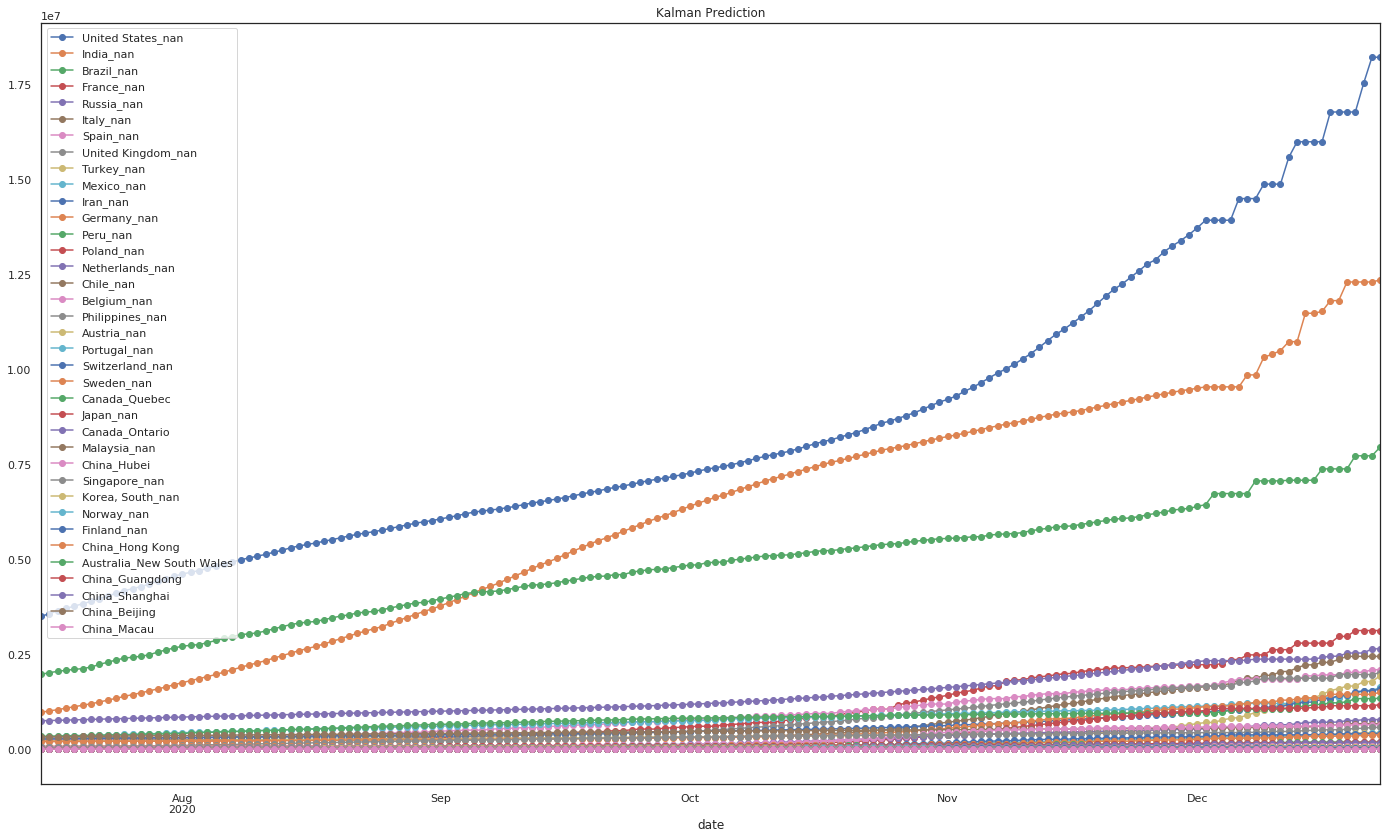

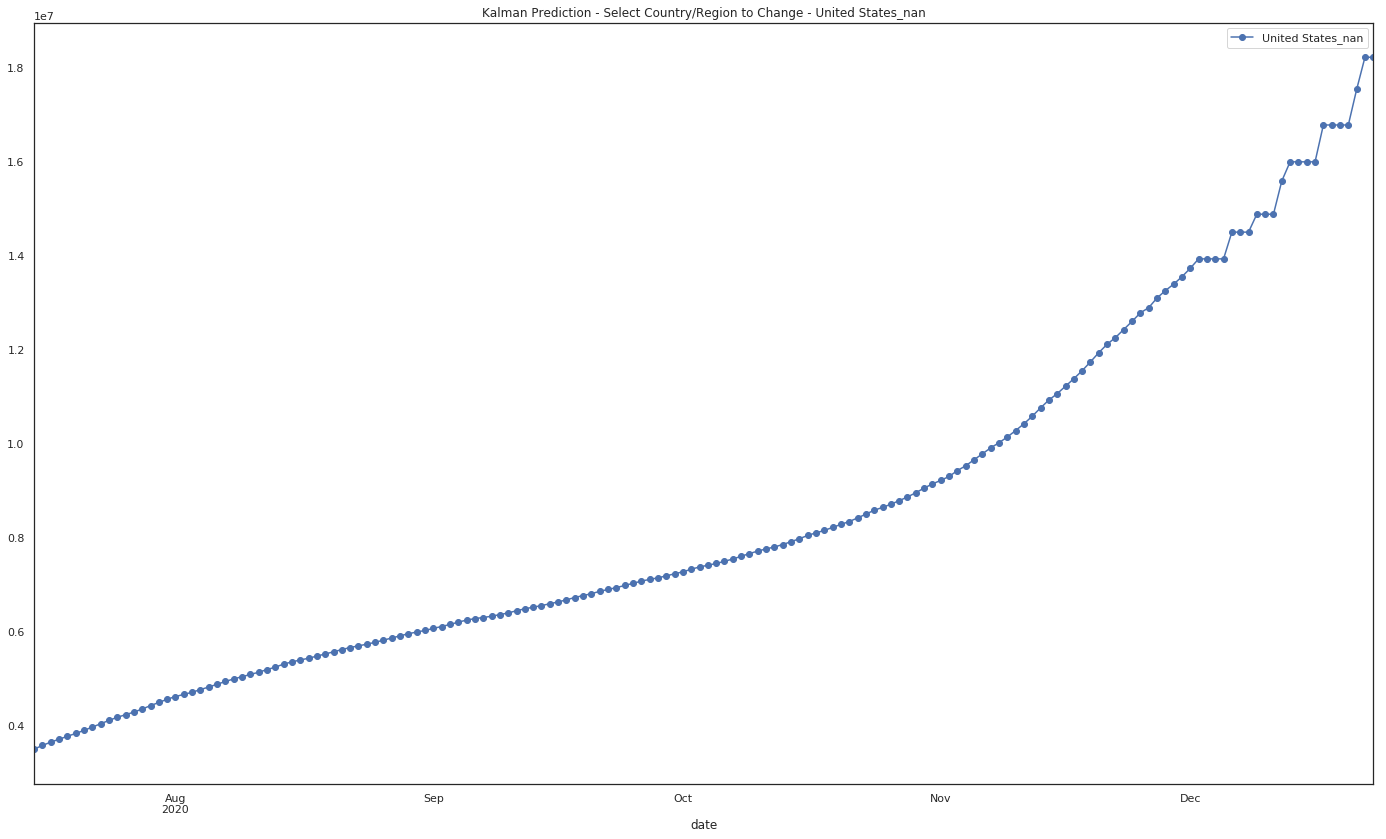

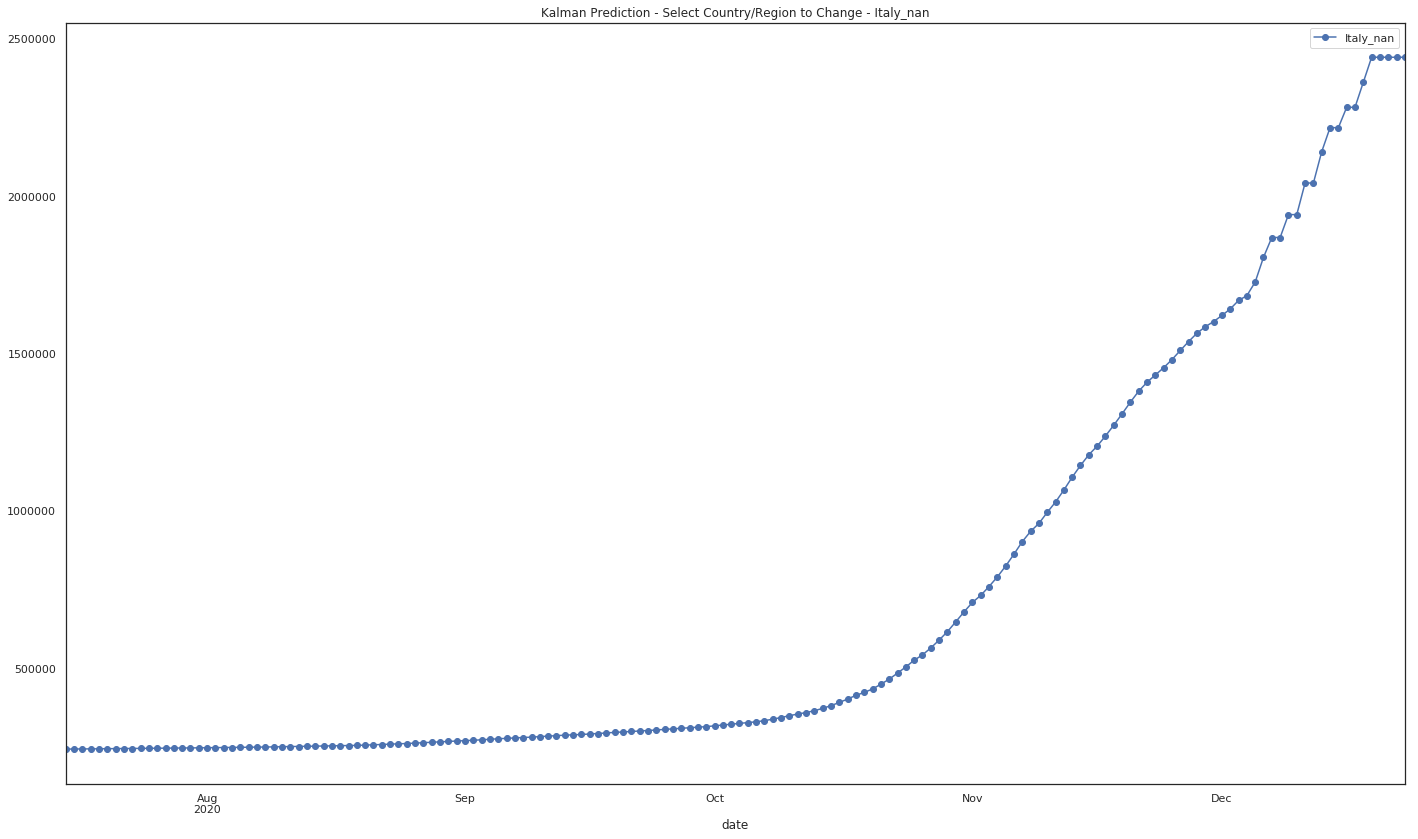

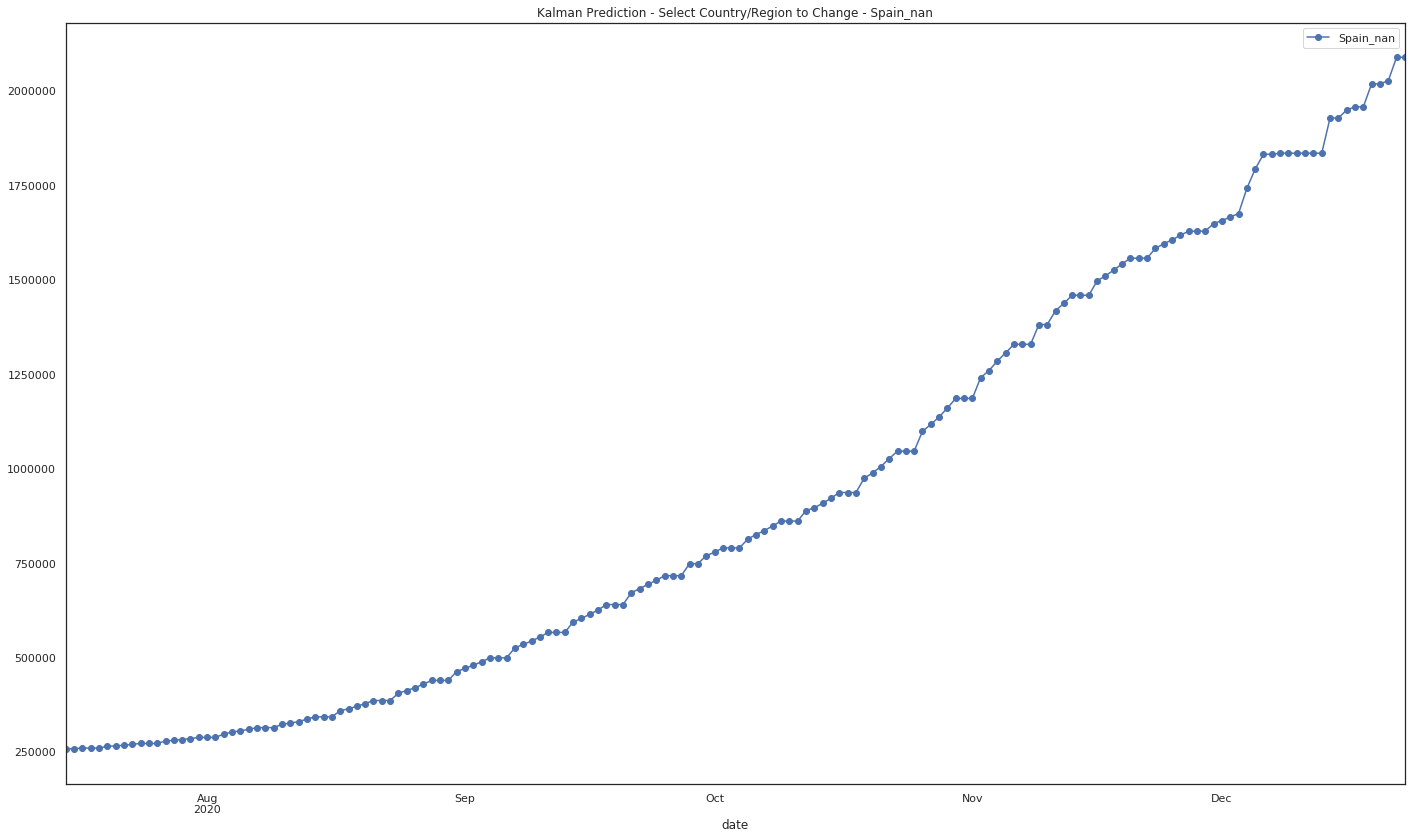

In [65]:
#
### Joao - Moving Forward ...
# Select regions From my_train_list
#
region=['date']+my_train_list
p_kalman=all_new[region]
#p=all_new
#p.iloc[len(p)-1,2]=None
p_kalman=p_kalman.set_index(['date'])
p_kalman=p_kalman.reindex(p_kalman.max().sort_values(ascending=False).index, axis=1)
p_kalman.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction')
#
p_kalman2=all_new[['date','United States_nan']] ## Joao
p_kalman2=p_kalman2.set_index(['date'])
p_kalman2.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman2.columns[0]))
#
p_kalman3=all_new[['date','Italy_nan']] ## Joao
p_kalman3=p_kalman3.set_index(['date'])
p_kalman3.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman3.columns[0]))
#
p_kalman4=all_new[['date','Spain_nan']] ## Joao
p_kalman4=p_kalman4.set_index(['date'])
p_kalman4.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman4.columns[0]))
#

/home/notebookuser/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


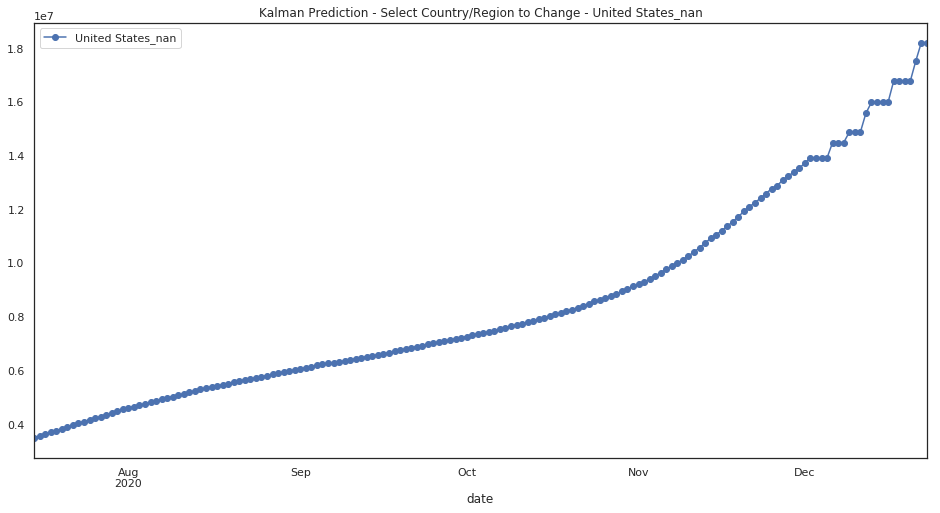

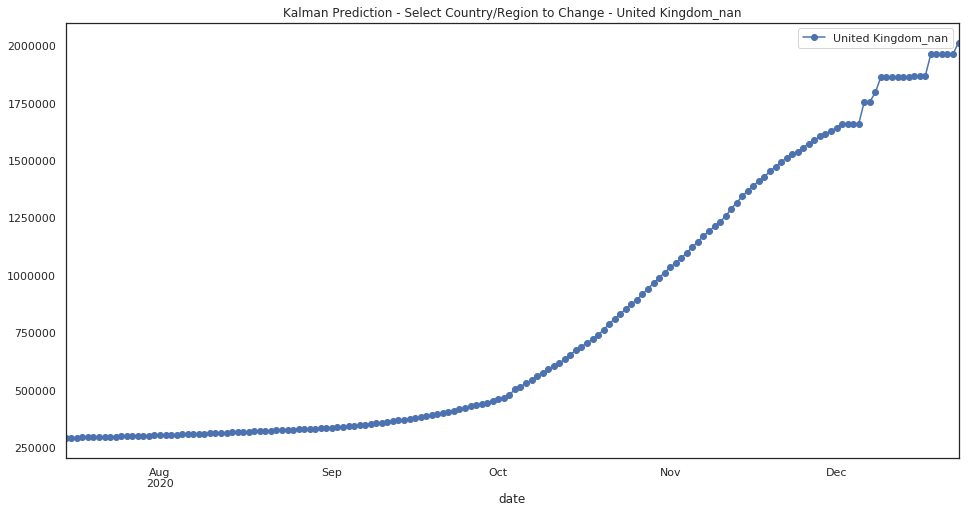

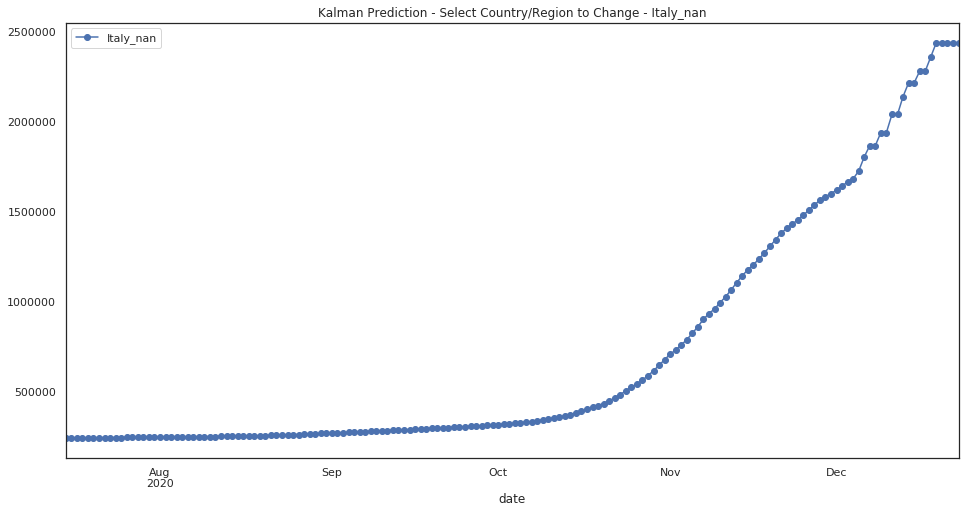

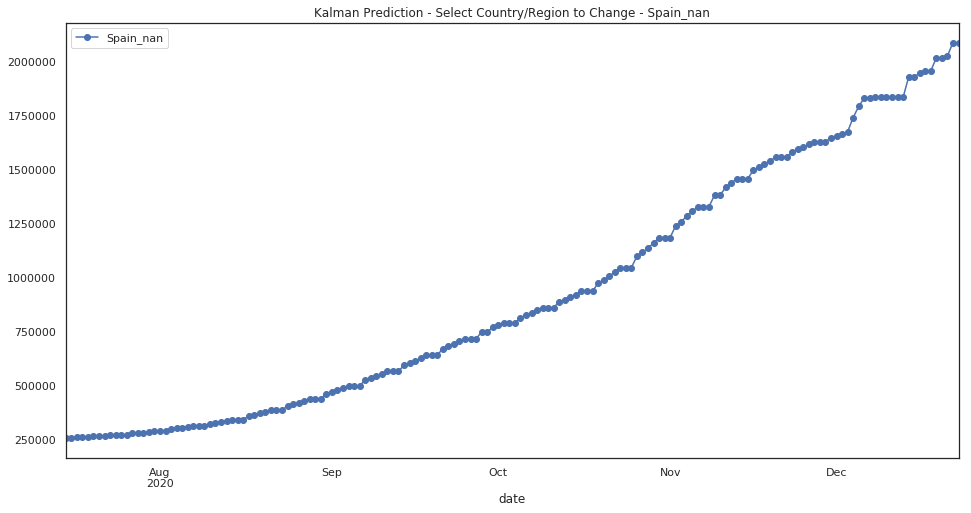

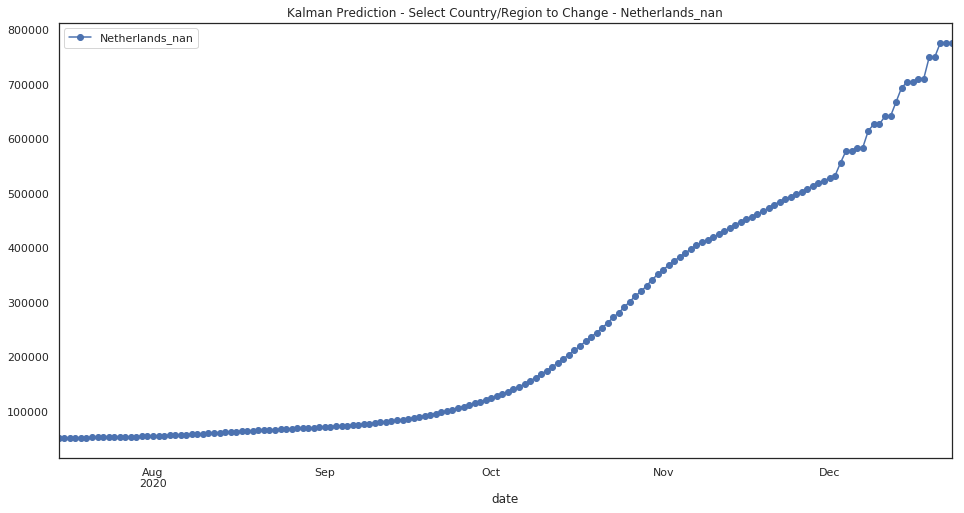

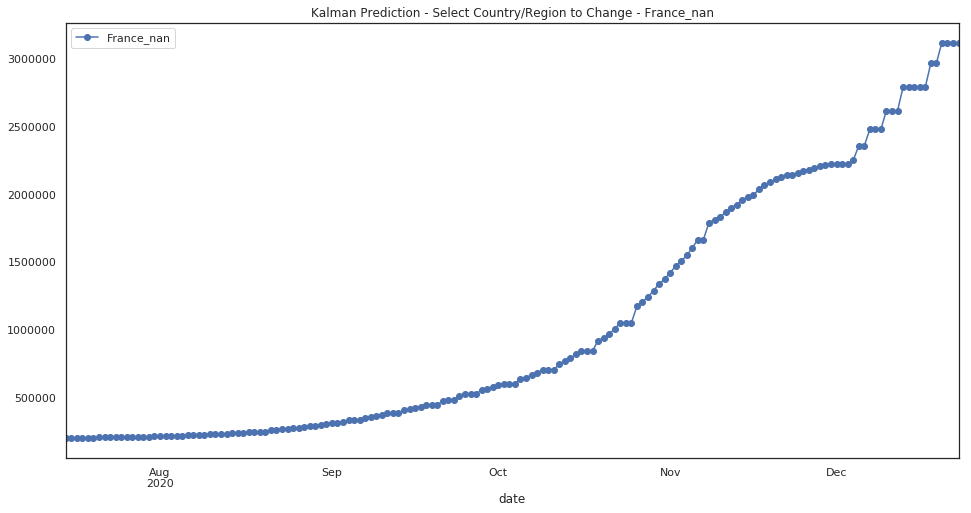

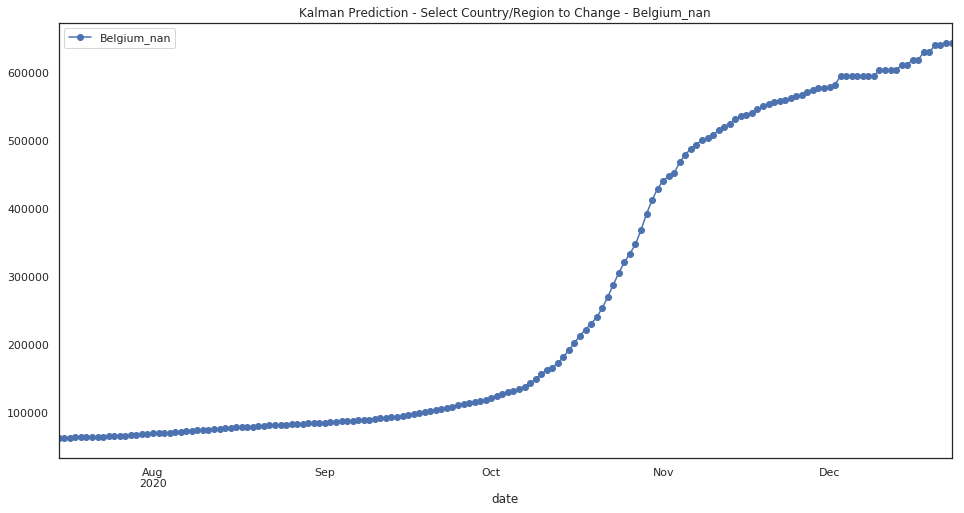

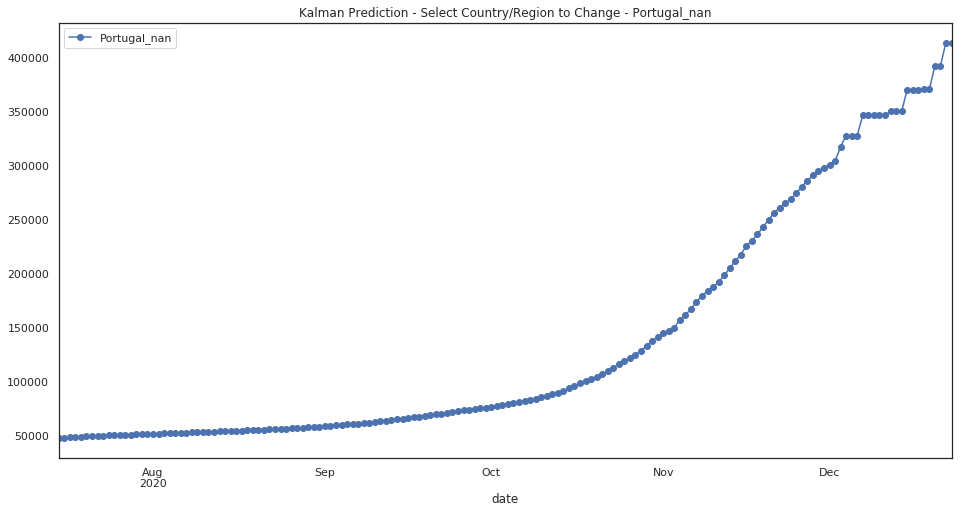

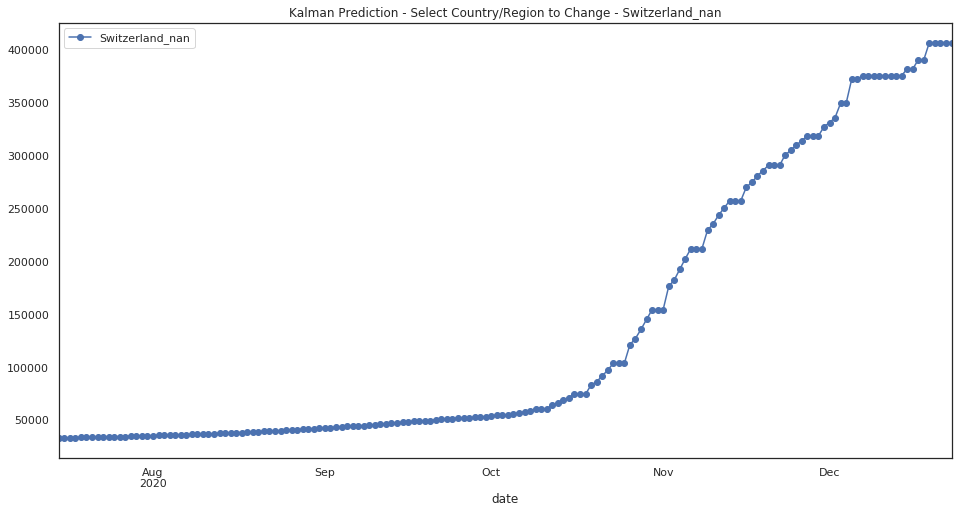

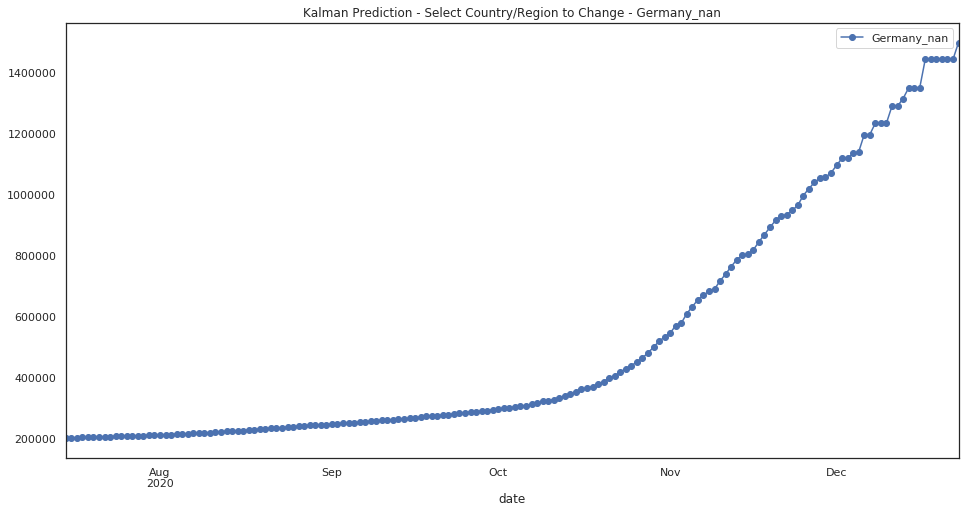

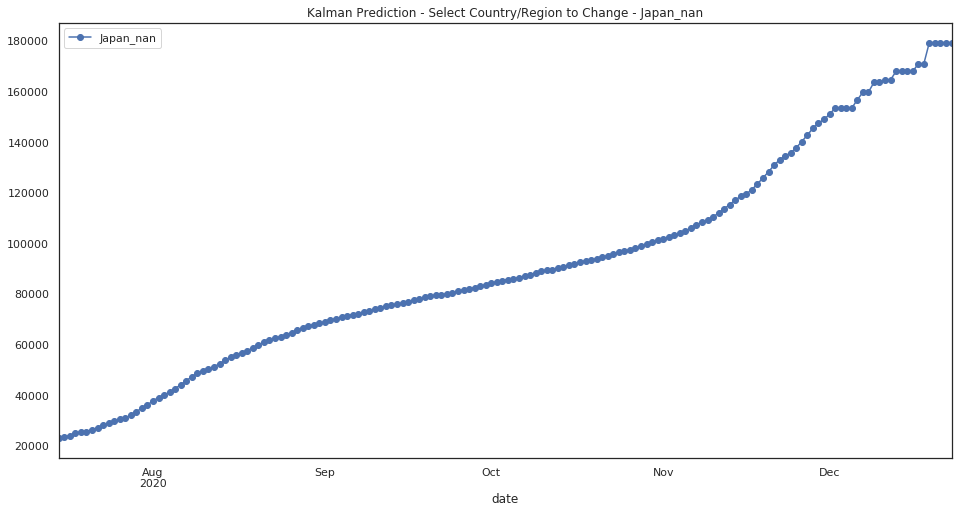

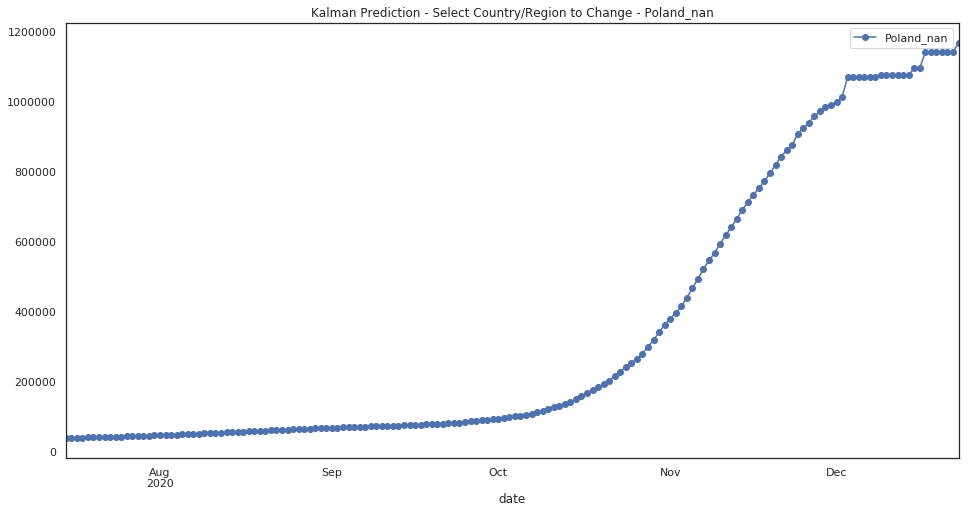

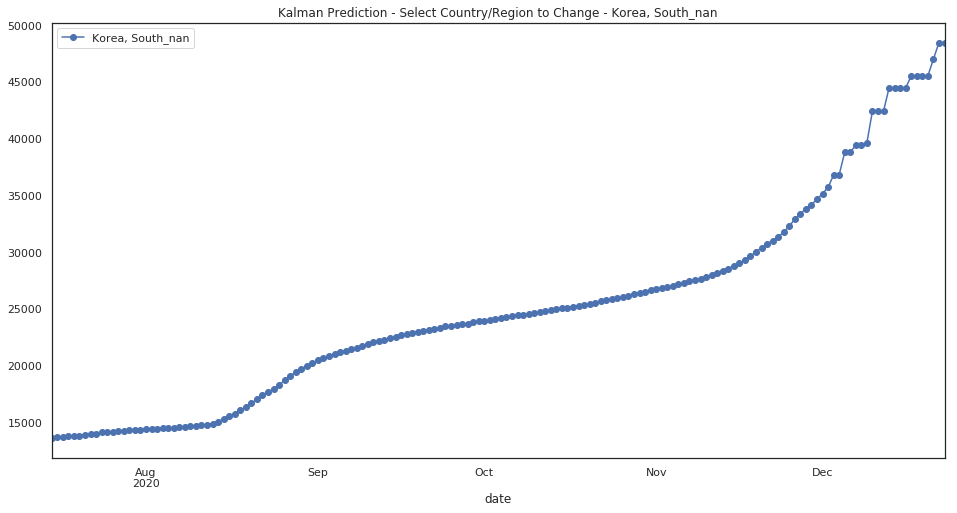

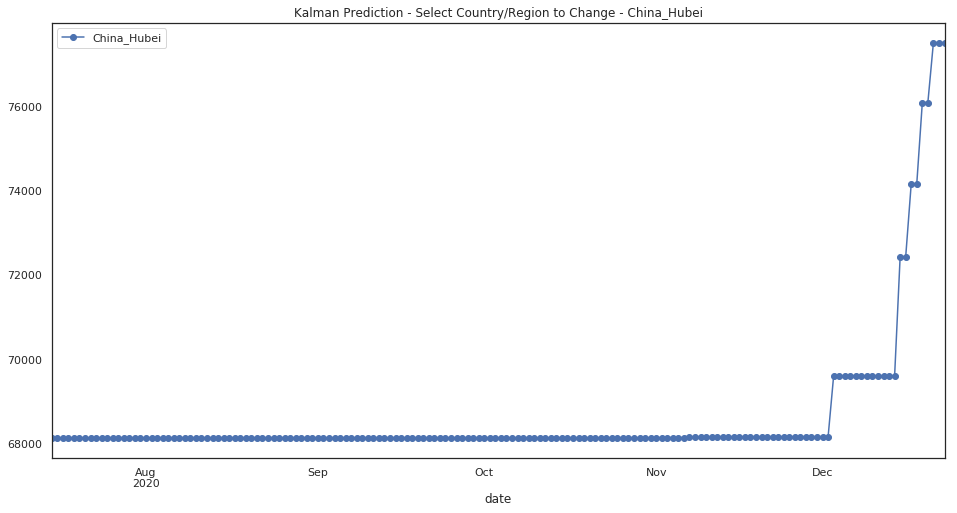

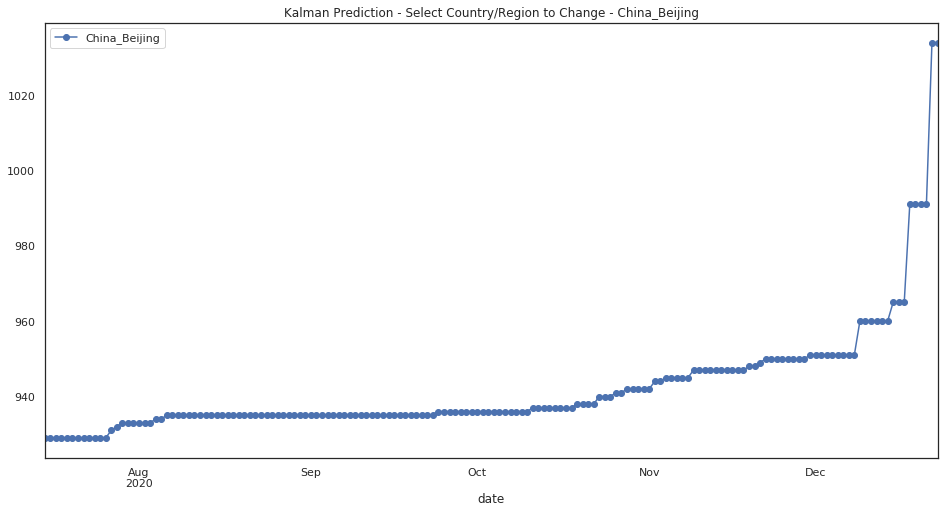

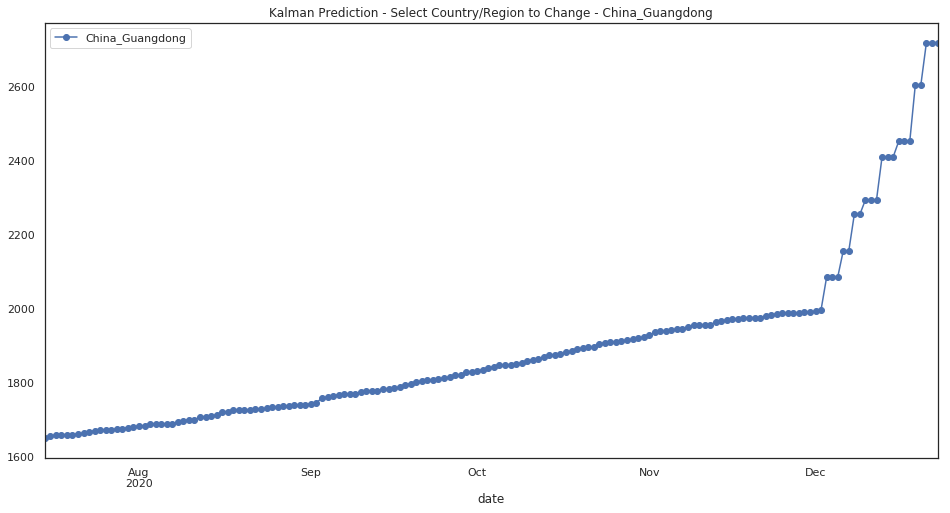

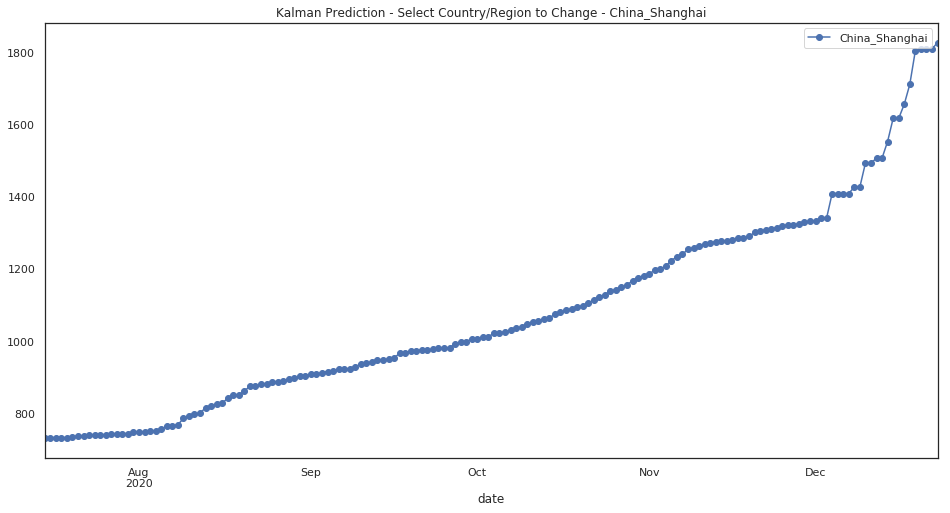

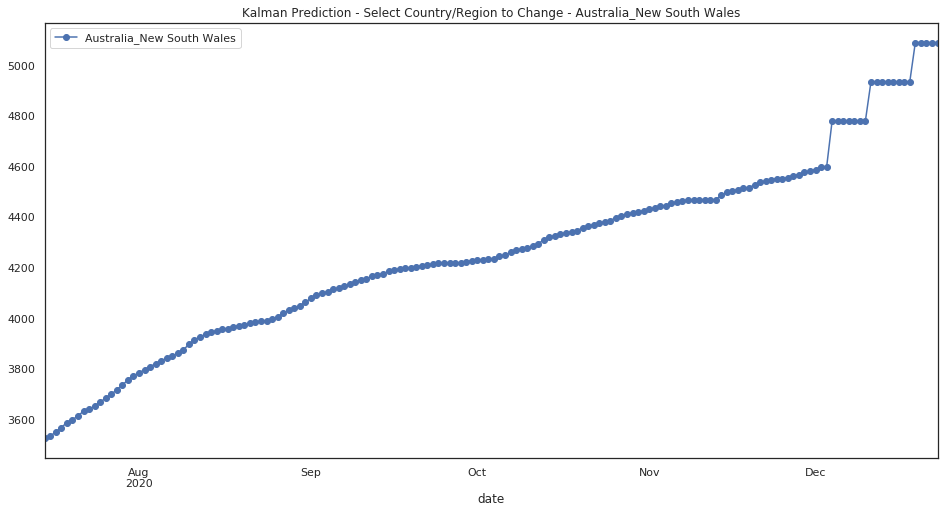

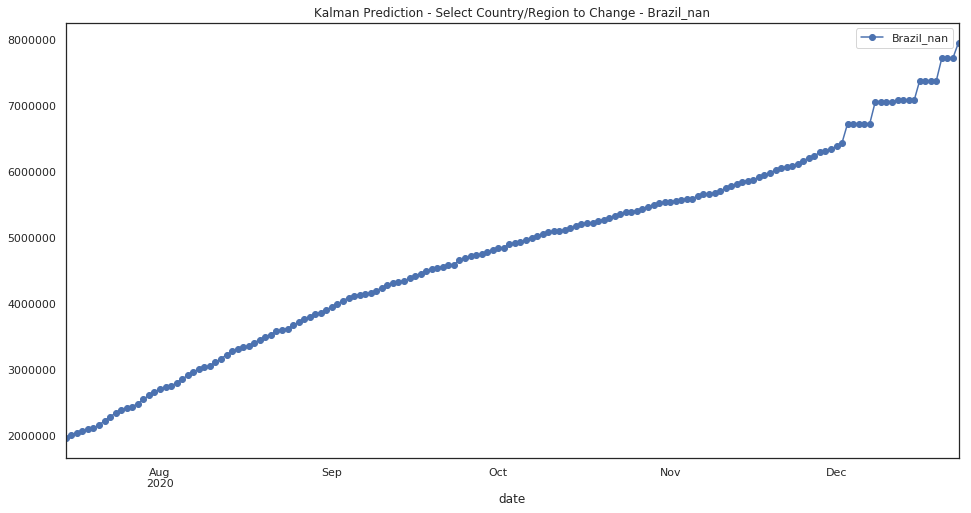

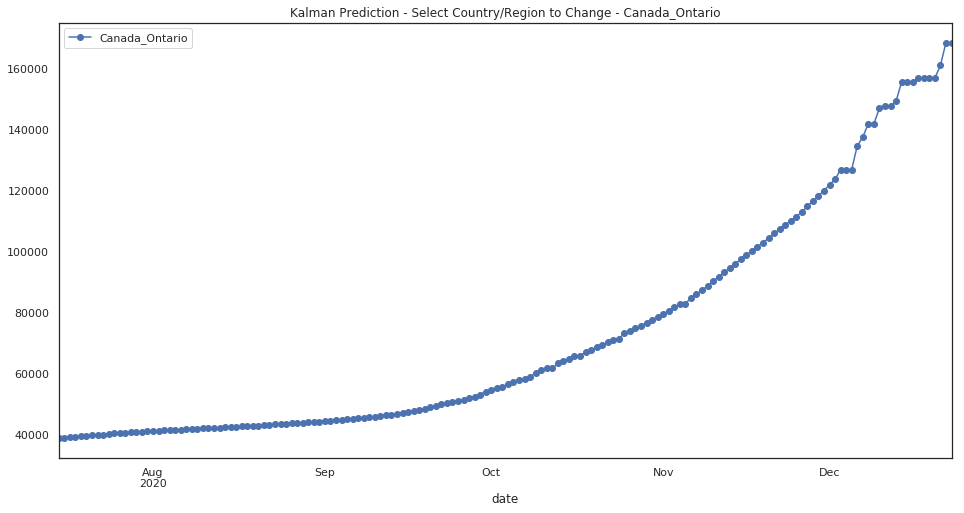

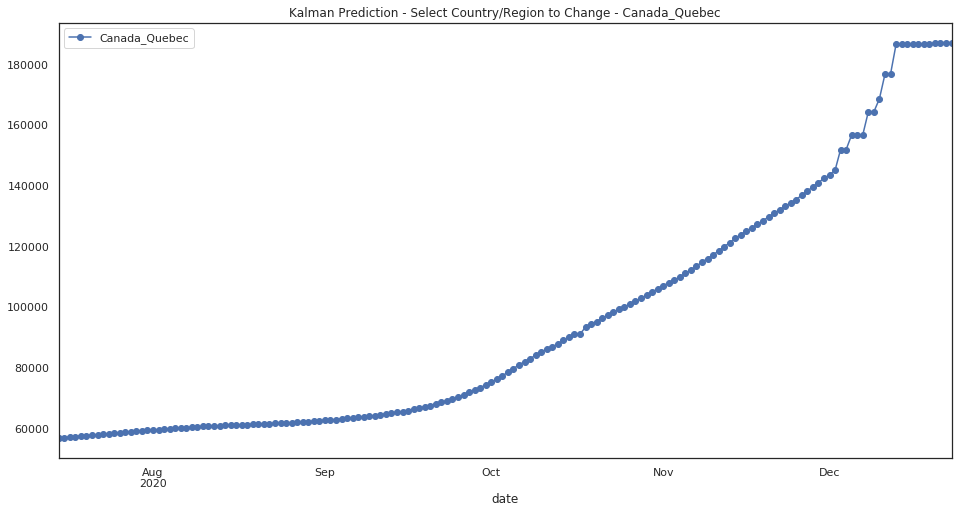

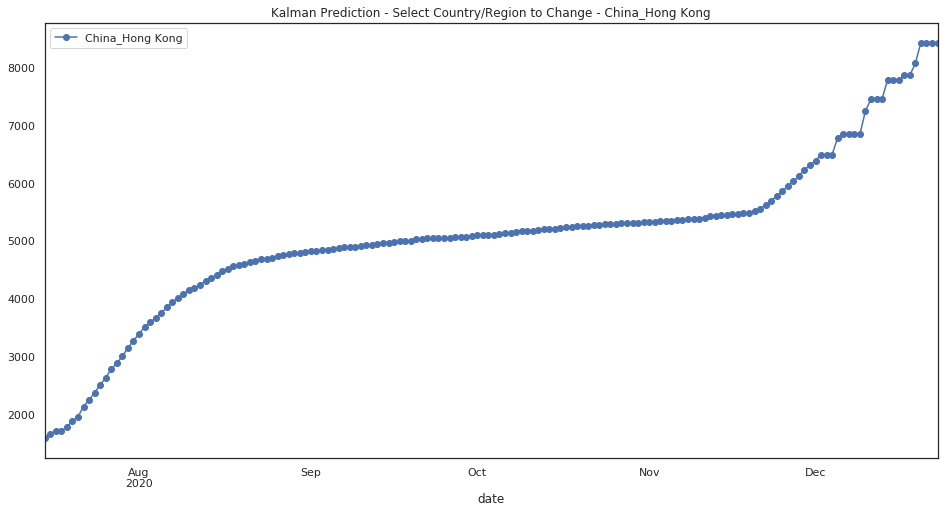

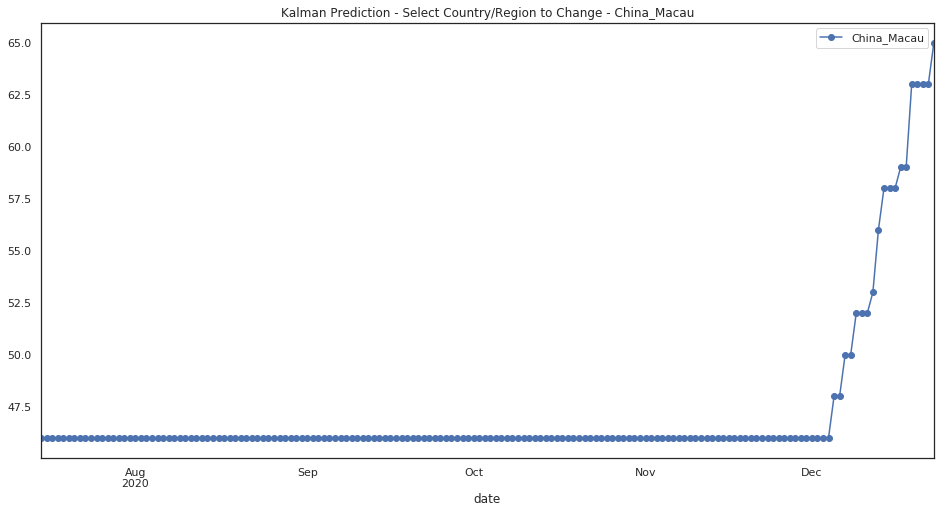

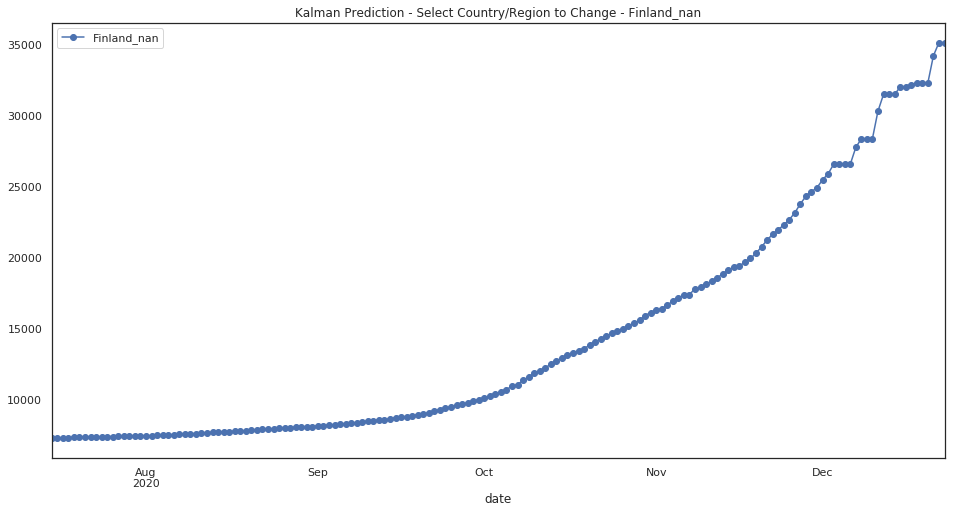

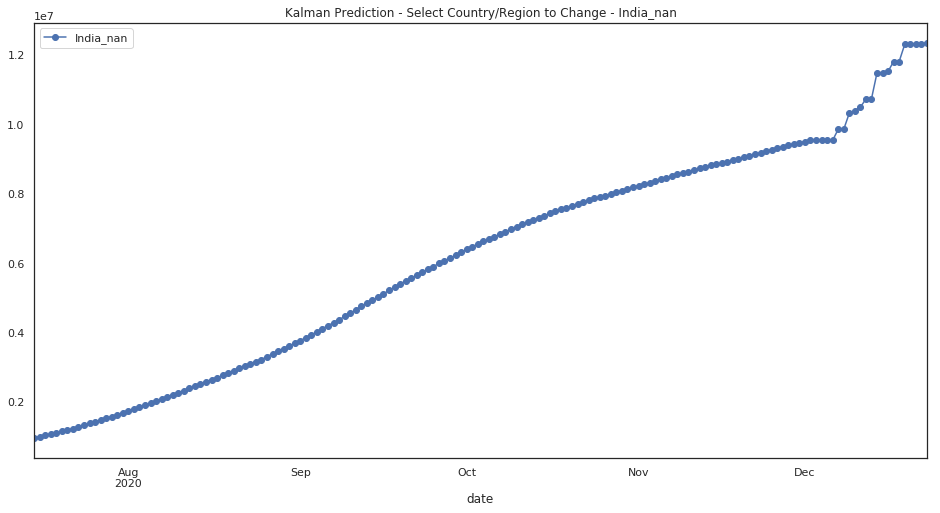

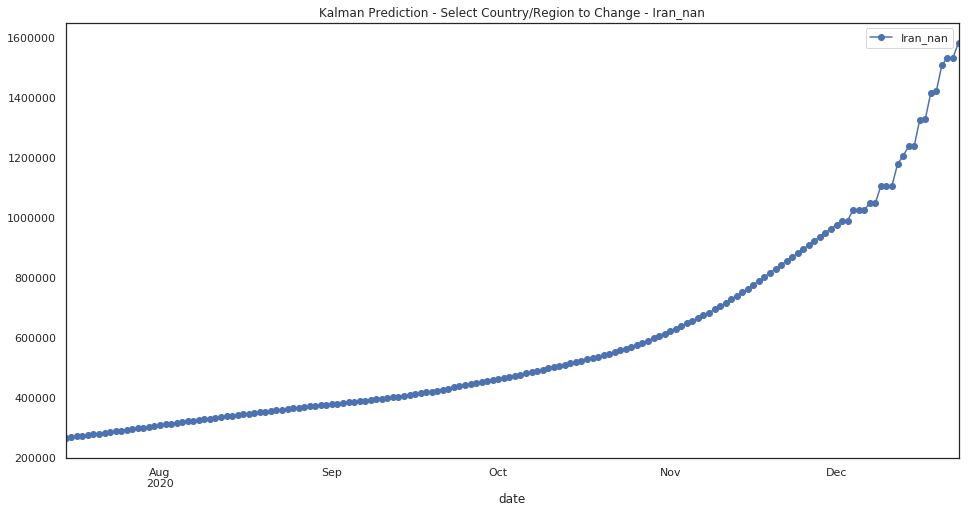

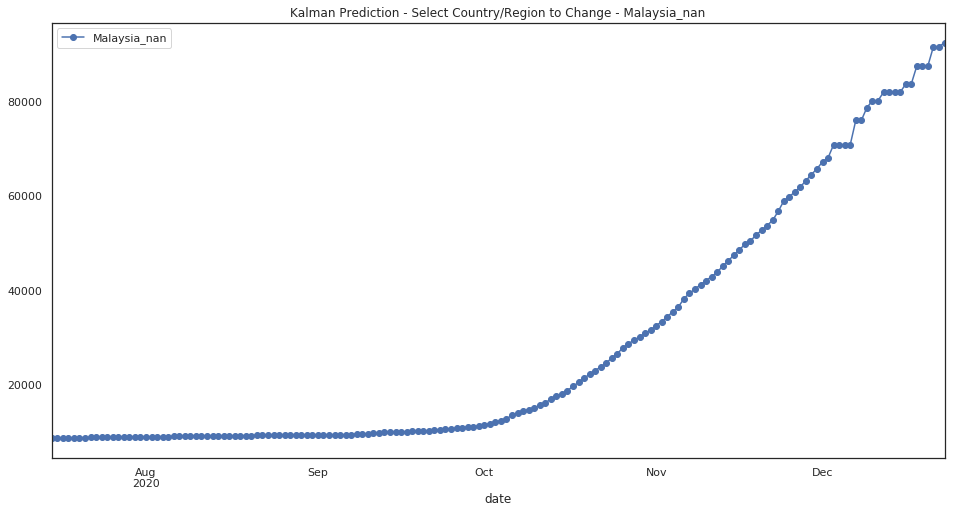

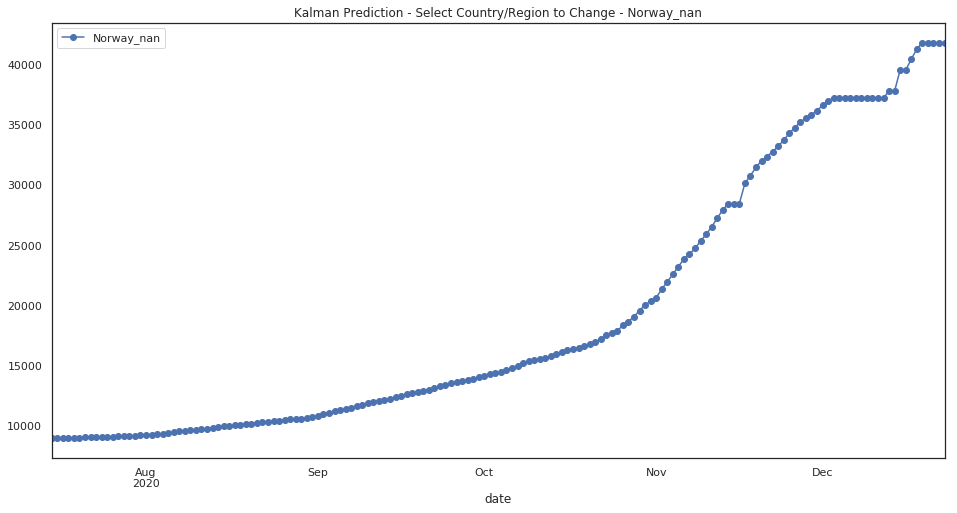

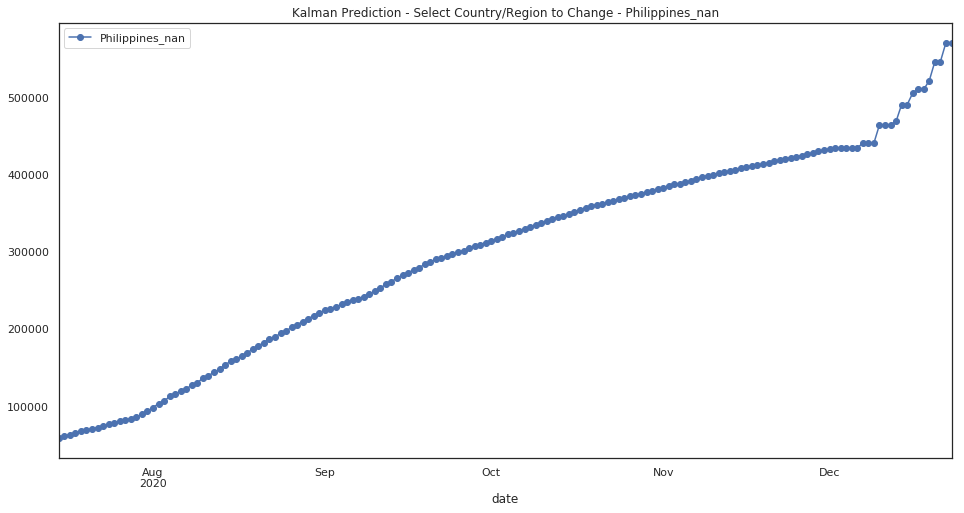

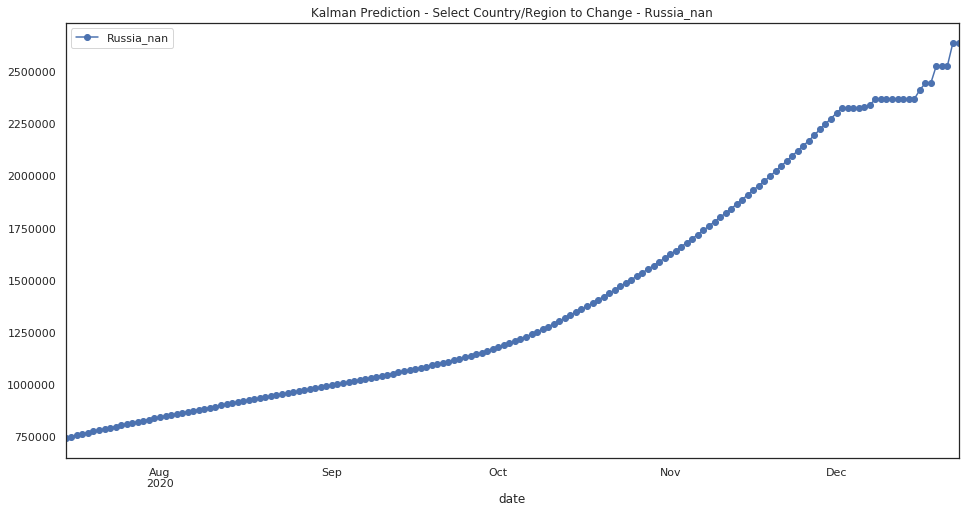

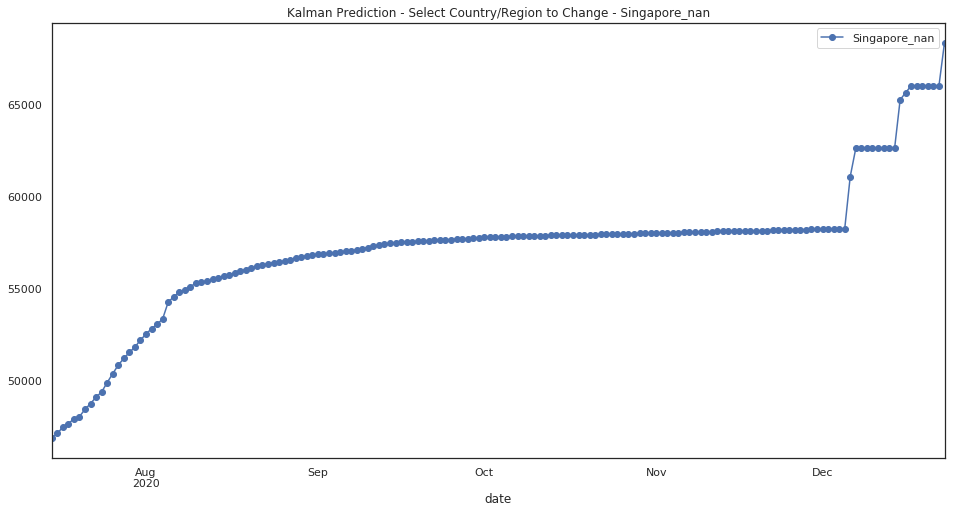

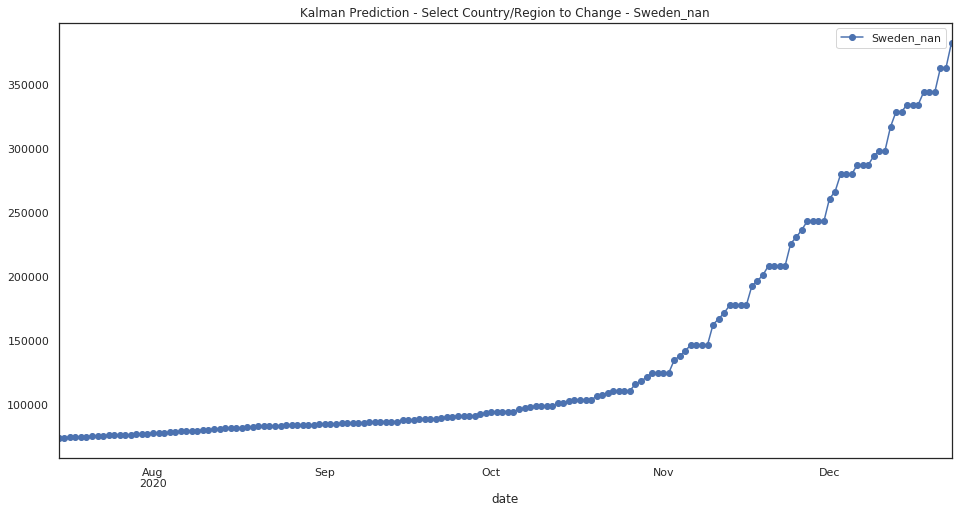

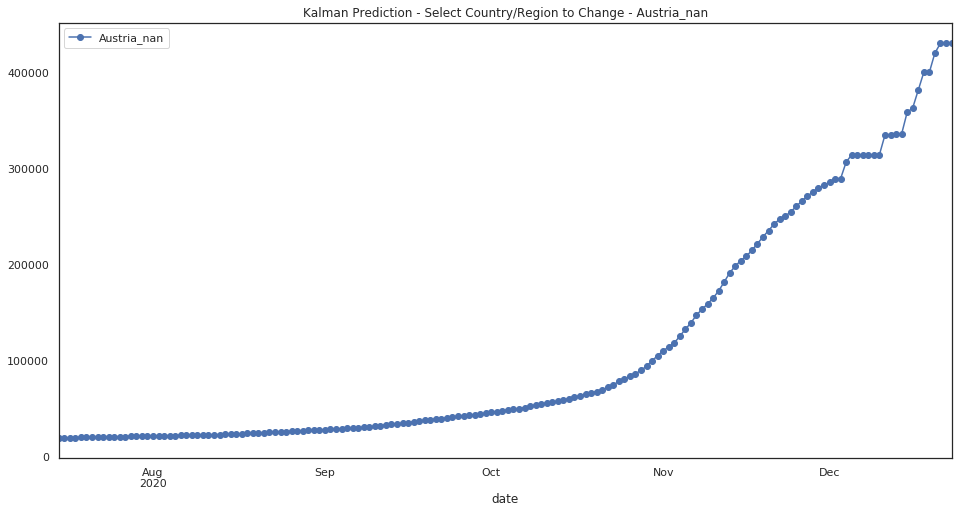

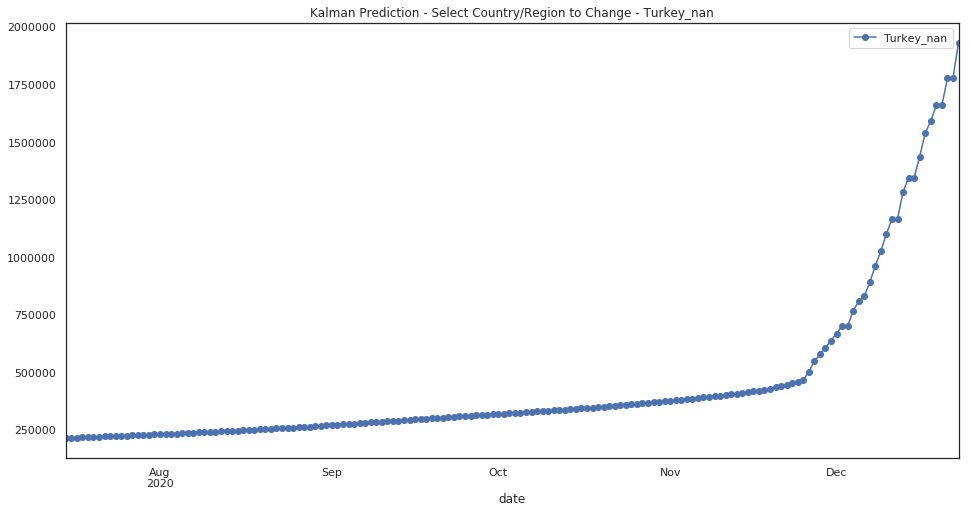

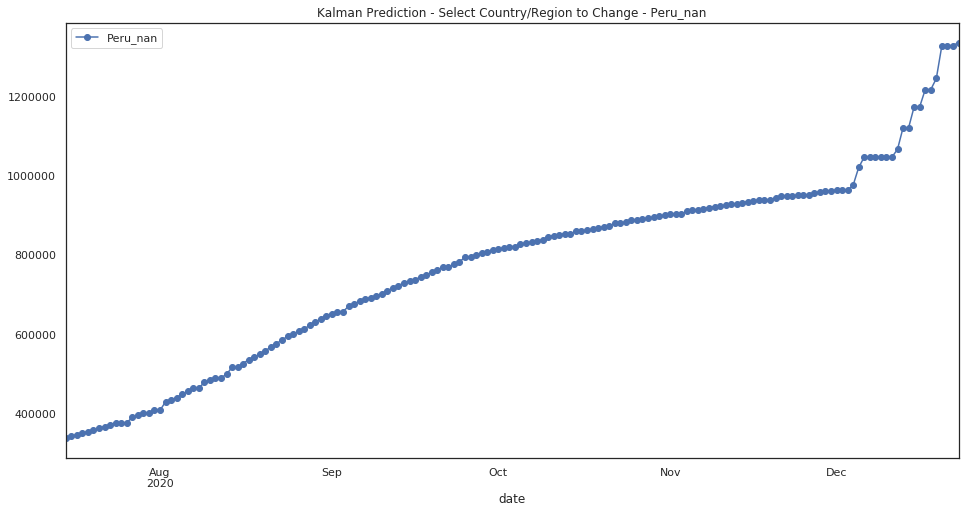

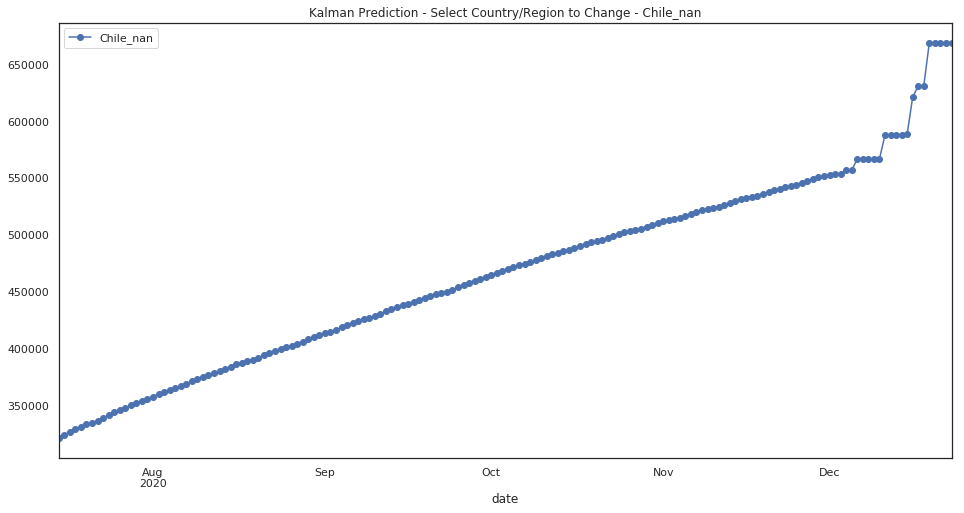

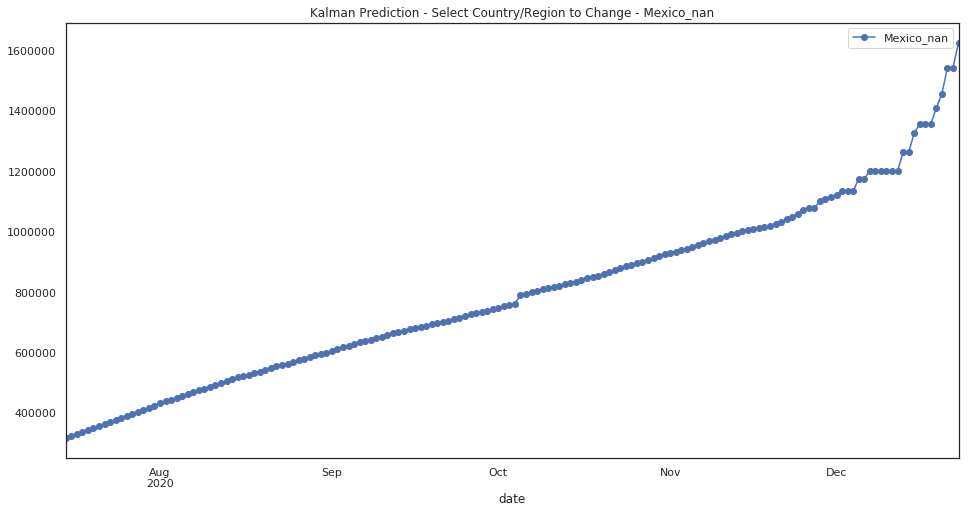

In [66]:
### Joao - Dynamic plot all regions individually
#print(region[:])
for i in range(1,len(region)):
    country_print=region[i]
    #print("here:"+country_print)
    p_kalman_rg=all_new[['date',country_print]]
    p_kalman_rg=p_kalman_rg.set_index(['date'])
    p_kalman_rg.iloc[:,:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman_rg.columns[0]))
    

In [67]:
max_p0=all_new[:]
max_p0=max_p0.max()
max_date=max_p0[:1]
max_p0=max_p0[1:]
max_p0=pd.DataFrame(max_p0)
max_p0=max_p0.astype(str)
max_p0['pred_confirmed']=max_p0[max_p0.columns[0]].str.split(' ').str[-1].astype(float)
max_p0[max_p0.columns[0]]=max_p0[max_p0.columns[0]][:-len(max_p0['pred_confirmed'])]
max_p0=max_p0.sort_values(by='pred_confirmed', ascending=False)
#
print("### -- Confirmed max cases per country at last prediction date -- ###")
print(max_date)
max_p0[:]

### -- Confirmed max cases per country at last prediction date -- ###
date    2020-12-23 00:00:00
dtype: object


0  pred_confirmed
United States_nan                           NaN      18211136.0
India_nan                                   NaN      12350007.0
Brazil_nan                                  NaN       7952609.0
France_nan                                  NaN       3120357.0
Russia_nan                                  NaN       2639879.0
Italy_nan                                   NaN       2441211.0
Spain_nan                                   NaN       2088522.0
United Kingdom_nan                          NaN       2014217.0
Turkey_nan                                  NaN       1932461.0
Argentina_nan                               NaN       1915527.0
Mexico_nan                                  NaN       1625821.0
Iran_nan                                    NaN       1582816.0
Germany_nan                                 NaN       1497421.0
Colombia_nan                                NaN       1488725.0
Peru_nan                                    NaN       1337031.0
Poland_nan                                  NaN       1169838.0
South Africa_nan                            NaN       1051117.0
Ukraine_nan                                 NaN        912837.0
Romania_nan                                 NaN        857221.0
Iraq_nan                                    NaN        810616.0
Netherlands_nan                             NaN        776690.0
Indonesia_nan                               NaN        759035.0
Czechia_nan                                 NaN        682895.0
Chile_nan                                   NaN        669166.0
Belgium_nan                                 NaN        643977.0
Philippines_nan                             NaN        570815.0
Bangladesh_nan                              NaN        515318.0
Pakistan_nan                                NaN        471710.0
Morocco_nan                                 NaN        466113.0
Saudi Arabia_nan                            NaN        460644.0
...                                         ...             ...
Dominica_nan                                NaN           108.0
China_Ningxia                               NaN           100.0
Saint Vincent and the Grenadines_nan        NaN           100.0
Canada_Prince Edward Island                 NaN            89.0
Australia_Northern Territory                NaN            80.0
Canada_Yukon                                NaN            69.0
Fiji_nan                                    NaN            66.0
China_Macau                                 NaN            65.0
Grenada_nan                                 NaN            53.0
France_New Caledonia                        NaN            49.0
Timor-Leste_nan                             NaN            46.0
Laos_nan                                    NaN            46.0
Holy See_nan                                NaN            45.0
Saint Kitts and Nevis_nan                   NaN            25.0
United Kingdom_Falkland Islands (Malvinas)  NaN            24.0
China_Qinghai                               NaN            24.0
Denmark_Greenland                           NaN            22.0
Solomon Islands_nan                         NaN            20.0
Canada_Repatriated Travellers               NaN            17.0
France_Saint Pierre and Miquelon            NaN            17.0
Canada_Grand Princess                       NaN            17.0
Canada_Northwest Territories                NaN            15.0
United Kingdom_Montserrat                   NaN            15.0
Western Sahara_nan                          NaN            10.0
MS Zaandam_nan                              NaN             9.0
United Kingdom_Anguilla                     NaN             8.0
Marshall Islands_nan                        NaN             4.0
Vanuatu_nan                                 NaN             1.0
China_Tibet                                 NaN             1.0
Canada_Diamond Princess                     NaN             0.0

[271 rows x 2 columns]

In [68]:
t.to_csv(r'data/t_confirmed_global.csv', index = False, header=True)

In [69]:
all_new.to_csv(r'data/prediction_kalman_filter_global.csv', index = False, header=True)

## Iterative Regression

In [70]:
t_iter=all_new.set_index(['date'])
t_iter=t_iter.stack().reset_index(name='confirmed')
t_iter.columns=['date', 'region','confirmed']
t_iter['date']=pd.to_datetime(t_iter['date'] ,errors ='coerce')
t_iter=t_iter.sort_values(['region', 'date'])

t_iter=t_iter.reset_index(drop=True)
for i in range(1,len(t_iter)+1):
    if(t_iter.iloc[i,1] is not t_iter.iloc[i-1,1]):
        t_iter.loc[len(t_iter)+1] = [t_iter.iloc[i-1,0]+ pd.DateOffset(1),t_iter.iloc[i-1,1], 0] 
t_iter=t_iter.sort_values(['region', 'date'])
t_iter=t_iter.reset_index(drop=True)

### Joao - Fix - RuntimeWarning: divide by zero encountered in double_scalars
#
t_iter['1_day_change']=t_iter['3_day_change']=t_iter['7_day_change']=t_iter['1_day_change_rate']=t_iter['3_day_change_rate']=t_iter['7_day_change_rate']=t_iter['last_day']=0
for i in range(1,len(t_iter)):
    if(t_iter.iloc[i,1] is t_iter.iloc[i-2,1]):
        t_iter.iloc[i,3]=t_iter.iloc[i-1,2]-t_iter.iloc[i-2,2]
        t_iter.iloc[i,6]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-2,2]*100 -1 +1))*100
        t_iter.iloc[i,9]=t_iter.iloc[i-1,2]
    if(t_iter.iloc[i,1] is t_iter.iloc[i-4,1]):
        t_iter.iloc[i,4]=t_iter.iloc[i-1,2]-t_iter.iloc[i-4,2]
        t_iter.iloc[i,7]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-4,2]*100 -1 +1))*100
    if(t_iter.iloc[i,1] is t_iter.iloc[i-8,1]):
        t_iter.iloc[i,5]=t_iter.iloc[i-1,2]-t_iter.iloc[i-8,2]
        t_iter.iloc[i,8]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-8,2]*100 -1 +1))*100
t_iter=t_iter.fillna(0)  

# t_iter=t_iter.merge(temp[['date','region', 'X']],how='left',on=['date','region'])
# t_iter=t_iter.rename(columns = {'X':'kalman_prediction'}) 
t_iter=t_iter.replace([np.inf, -np.inf], 0)
t_iter['kalman_prediction']=round(t_iter['confirmed'])

test_iter=t_iter.merge(confirmed[['region',' Population ']],how='left',on='region')
test_iter=test_iter.rename(columns = {' Population ':'population'})
test_iter['population']=test_iter['population'].str.replace(r" ", '')
test_iter['population']=test_iter['population'].str.replace(r",", '')
test_iter['population']=test_iter['population'].fillna(10000000) # Fill 10M population if null
test_iter['population']=test_iter['population'].astype('int32')
## Joao - Fix Divid By Zero
#test_iter['infected_rate'] =test_iter['last_day']/test_iter['population']*10000
#test_iter['infected_rate'] =((test_iter['last_day']+1)*10000)/((test_iter['population']+1)*100)*100
test_iter['infected_rate']=(((test_iter['last_day'] +1)*100)/((test_iter['population'] +1)*100000) *10)
#
test_iter=test_iter.merge(w,how='left',on=['date','region'])
#test_iter=test_iter.sort_values(['region', 'date'])

test_iter_temp=test_iter[np.isnan(test_iter['min'])]
test_iter_temp=test_iter_temp.drop(columns=['min', 'max'])
test_iter_temp=test_iter_temp.merge(w_forecast,how='left',on=['date','region'])
test_iter=test_iter.dropna()
test_iter=test_iter.append(test_iter_temp)
test_iter=test_iter.sort_values(['region', 'date'])
### fill missing weather 
for i in range(0,len(test_iter)):
    if(np.isnan(test_iter.iloc[i,13])):
        if(test_iter.iloc[i,1] is test_iter.iloc[i-1,1]):
            test_iter.iloc[i,13]=test_iter.iloc[i-1,13]+abs(test_iter.iloc[i-1,13]*.01)
            test_iter.iloc[i,14]=test_iter.iloc[i-1,14]+abs(test_iter.iloc[i-1,14]*.01)


/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in double_scalars
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in double_scalars


In [71]:
test_iter=test_iter.fillna(0) 
test_iter[test_iter.isnull().any(axis=1)]


Empty DataFrame
Columns: [date, region, confirmed, 1_day_change, 3_day_change, 7_day_change, 1_day_change_rate, 3_day_change_rate, 7_day_change_rate, last_day, kalman_prediction, population, infected_rate, min, max]
Index: []

In [72]:
### JOAO - ERROR - ValueError: Index contains duplicate entries, cannot reshape
pred=reg.predict(test_iter[x_col]); pred=pd.DataFrame(pred); pred.columns = ['prediction'];pred=round(pred)
pred['confirmed']=test_iter['confirmed'].values; pred['date']=test_iter['date'].values; pred['region']=test_iter['region'].values

for i in range(1,len(pred)):
    if(pred.iloc[i,3] is pred.iloc[i-1,3]):
        if(pred.iloc[i,0]<pred.iloc[i-1,1]):
            pred.iloc[i,0]=pred.iloc[i-1,1]
### JOAO - Drop Duplicates
pred=pred.drop_duplicates(subset=['date','region'], keep='last', inplace=False)        
### Joao - Save long term predictions
pred.to_csv('data/pred_'+str(num_days_R_prediction)+'_days.csv', index = False, header=True)
###
pred=pred.pivot(index='date',columns='region',values='prediction') # pivot pred df

In [73]:
pred[:]

region      Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  \
date                                                                 
2020-07-15          41056.0      13829.0      28665.0      11309.0   
2020-07-16          41122.0      13915.0      29175.0      11322.0   
2020-07-17          35060.0       3851.0      21355.0        877.0   
2020-07-18          35219.0       3906.0      21948.0        880.0   
2020-07-19          35279.0       4008.0      22763.0        880.0   
2020-07-20          35453.0       4090.0      23377.0        880.0   
2020-07-21          35493.0       4171.0      23959.0        884.0   
2020-07-22          35605.0       4290.0      24560.0        884.0   
2020-07-23          35993.0       4502.0      25481.0        889.0   
2020-07-24          36074.0       4520.0      26149.0        941.0   
2020-07-25          36122.0       4605.0      26760.0        897.0   
2020-07-26          36233.0       4806.0      27368.0        945.0   
2020-07-27          36340.0       4803.0      27984.0        954.0   
2020-07-28          36445.0       4948.0      28621.0        907.0   
2020-07-29          36551.0       5070.0      29240.0        967.0   
2020-07-30          36625.0       5185.0      29849.0        918.0   
2020-07-31          36749.0       5294.0      30419.0        932.0   
2020-08-01          36797.0       5427.0      30979.0        946.0   
2020-08-02          36801.0       5478.0      31500.0        973.0   
2020-08-03          36831.0       5585.0      32009.0        980.0   
2020-08-04          36866.0       5756.0      32538.0        937.0   
2020-08-05          36912.0       5847.0      33087.0        968.0   
2020-08-06          37014.0       5967.0      33657.0        993.0   
2020-08-07          37097.0       6130.0      34193.0        944.0   
2020-08-08          37143.0       6248.0      34733.0        955.0   
2020-08-09          37180.0       6401.0      35209.0       1007.0   
2020-08-10          37244.0       6513.0      35750.0       1010.0   
2020-08-11          37346.0       6670.0      36250.0        963.0   
2020-08-12          37427.0       6793.0      36745.0       1018.0   
2020-08-13          37512.0       6947.0      37236.0        977.0   
...                     ...          ...          ...          ...   
2020-11-25          45458.0      34876.0      78095.0       6351.0   
2020-11-26          45676.0      35534.0      79154.0       6428.0   
2020-11-27          45810.0      36178.0      80226.0       6534.0   
2020-11-28          45924.0      36734.0      81267.0       6610.0   
2020-11-29          46176.0      37530.0      82278.0       6610.0   
2020-11-30          46360.0      38126.0      83254.0       6712.0   
2020-12-01          46759.0      38919.0      84204.0       6745.0   
2020-12-02          47069.0      39649.0      85136.0       6790.0   
2020-12-03          47088.0      39897.0      86878.0       6842.0   
2020-12-04          47067.0      39906.0      89241.0       7056.0   
2020-12-05          47062.0      40183.0      89800.0       7393.0   
2020-12-06          47060.0      41134.0      89447.0       7393.0   
2020-12-07          47563.0      41599.0      90193.0       7393.0   
2020-12-08          47686.0      41623.0      95524.0       7393.0   
2020-12-09          47946.0      43314.0      97199.0       7393.0   
2020-12-10          48023.0      43657.0      96113.0       7393.0   
2020-12-11          47987.0      43581.0      96113.0       7393.0   
2020-12-12          48271.0      43581.0      96113.0       7393.0   
2020-12-13          49228.0      43581.0      97161.0       7393.0   
2020-12-14          50660.0      45153.0      97565.0       7393.0   
2020-12-15          50892.0      46378.0      97353.0       7393.0   
2020-12-16          51857.0      47894.0      99004.0       7393.0   
2020-12-17          52135.0      48880.0     102407.0       7424.0   
2020-12-18          51994.0      48899.0     103536.0       7424.0   
2020-12-19

In [74]:
### JOAO - FIX - issue if all source days ts[:]
## Comment for -35days start. 26feb.2020 ts=ts[35:]
## 06Aug2020 - For all
pred=pred[:-1]

In [75]:
region1=max_p0[max_p0.columns[0]].astype(str).reset_index().rename(columns={"index": "region"}).get_values()
region=[region[0] for region in region1]
region

['United States_nan',
 'India_nan',
 'Brazil_nan',
 'France_nan',
 'Russia_nan',
 'Italy_nan',
 'Spain_nan',
 'United Kingdom_nan',
 'Turkey_nan',
 'Argentina_nan',
 'Mexico_nan',
 'Iran_nan',
 'Germany_nan',
 'Colombia_nan',
 'Peru_nan',
 'Poland_nan',
 'South Africa_nan',
 'Ukraine_nan',
 'Romania_nan',
 'Iraq_nan',
 'Netherlands_nan',
 'Indonesia_nan',
 'Czechia_nan',
 'Chile_nan',
 'Belgium_nan',
 'Philippines_nan',
 'Bangladesh_nan',
 'Pakistan_nan',
 'Morocco_nan',
 'Saudi Arabia_nan',
 'Austria_nan',
 'Portugal_nan',
 'Switzerland_nan',
 'Hungary_nan',
 'Sweden_nan',
 'Israel_nan',
 'Nepal_nan',
 'Jordan_nan',
 'Bulgaria_nan',
 'Serbia_nan',
 'Ecuador_nan',
 'Georgia_nan',
 'Qatar_nan',
 'Kazakhstan_nan',
 'Panama_nan',
 'United Arab Emirates_nan',
 'Dominican Republic_nan',
 'Lebanon_nan',
 'Belarus_nan',
 'Croatia_nan',
 'Canada_Quebec',
 'Costa Rica_nan',
 'Japan_nan',
 'Azerbaijan_nan',
 'Bolivia_nan',
 'Greece_nan',
 'Canada_Ontario',
 'Guatemala_nan',
 'Kuwait_nan',
 'Arme

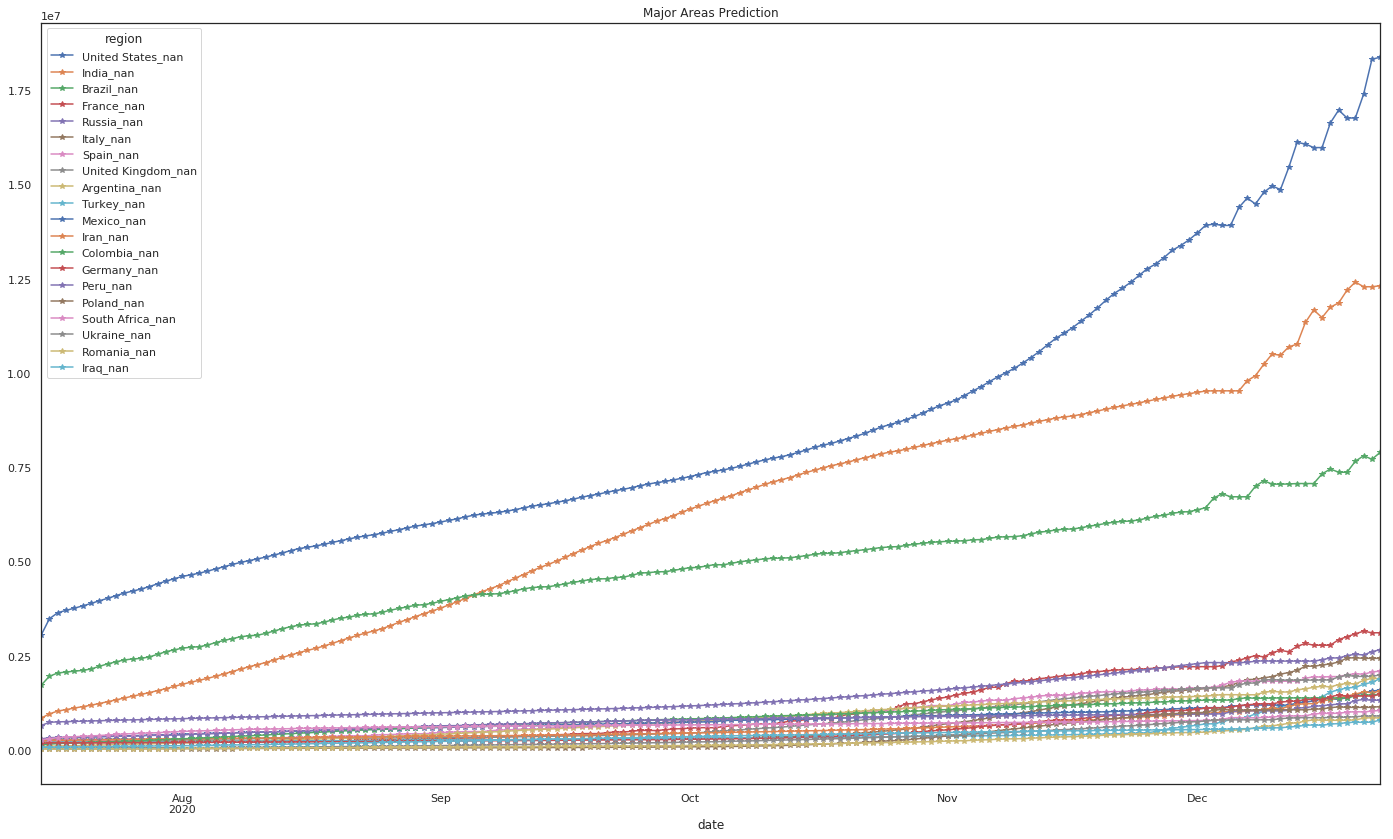

In [76]:
#
p=pred[region[:20]]
p[:].reindex(p.max().sort_values(ascending=False).index, axis=1).plot(marker='*',figsize=(24,14),title ='Major Areas Prediction')

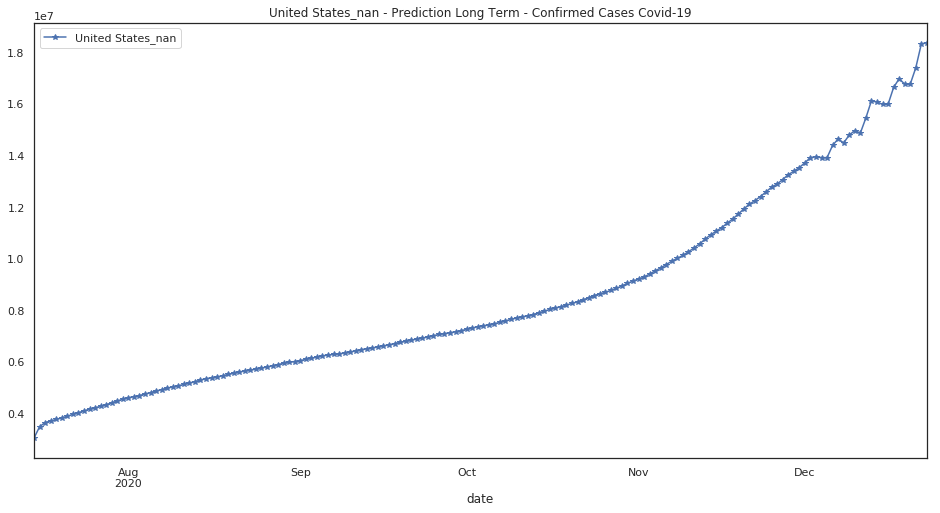

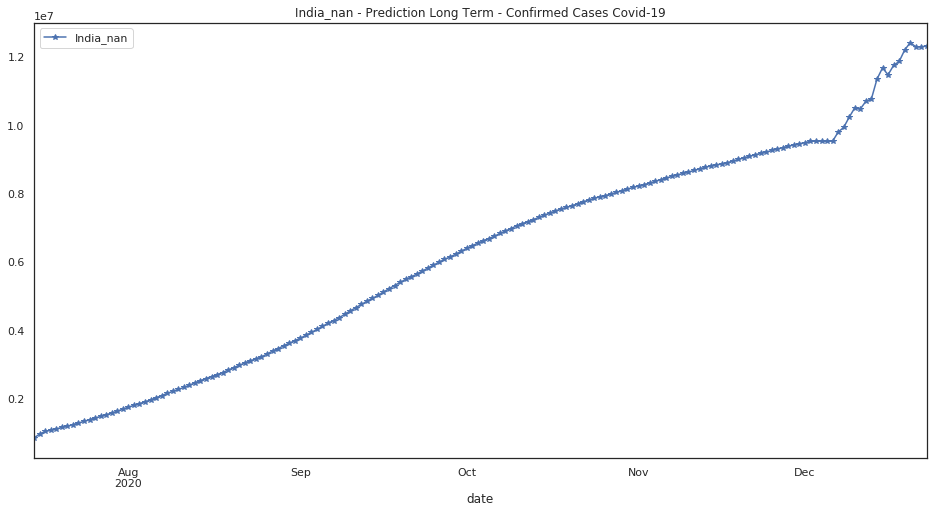

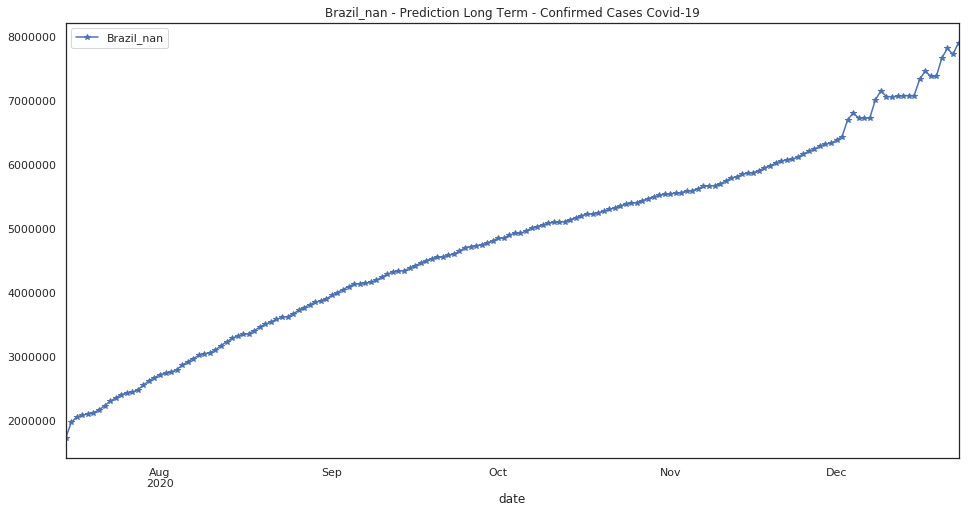

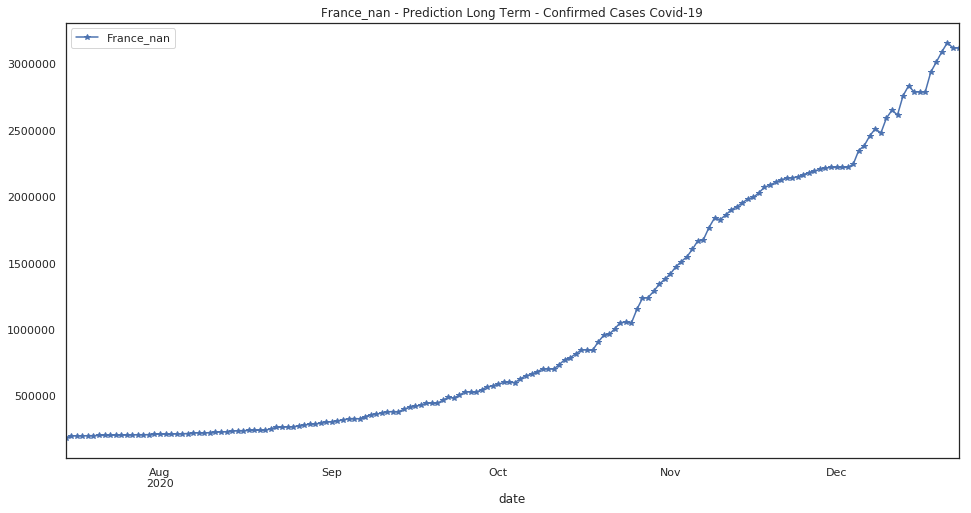

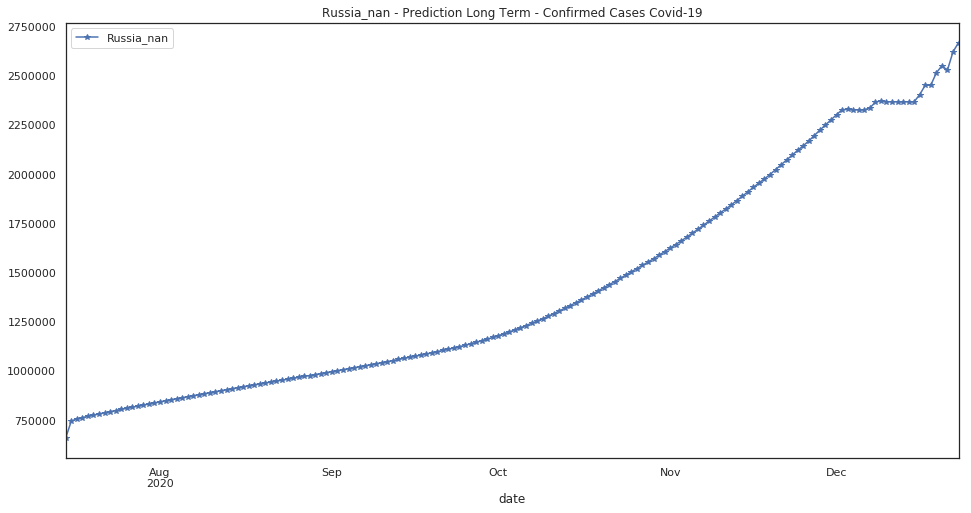

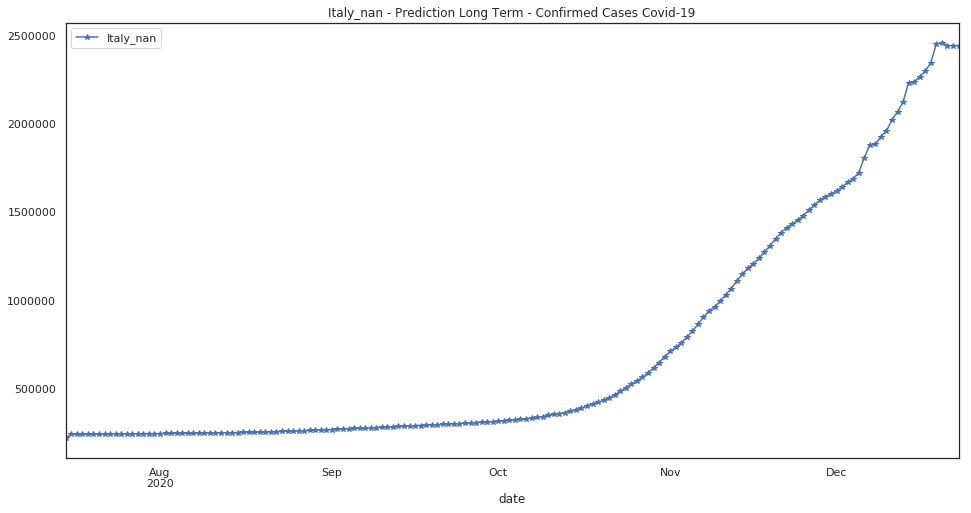

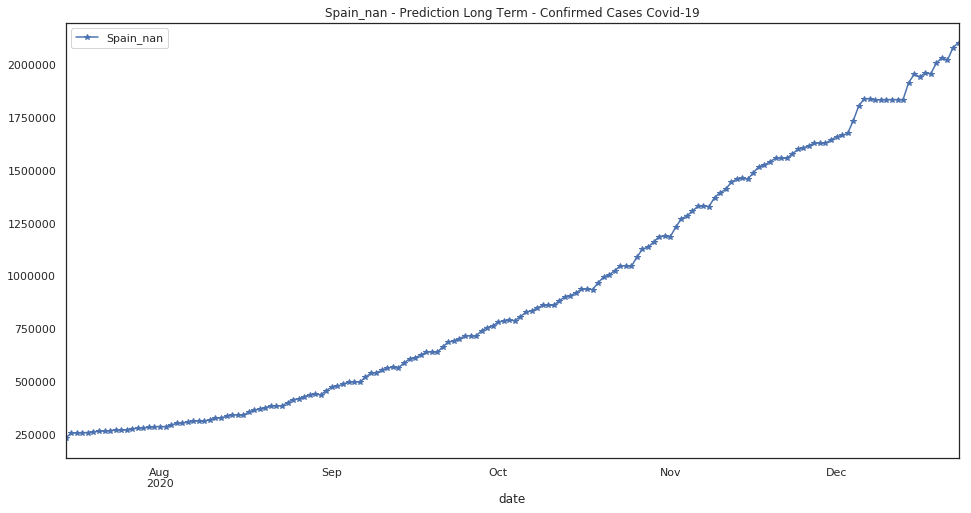

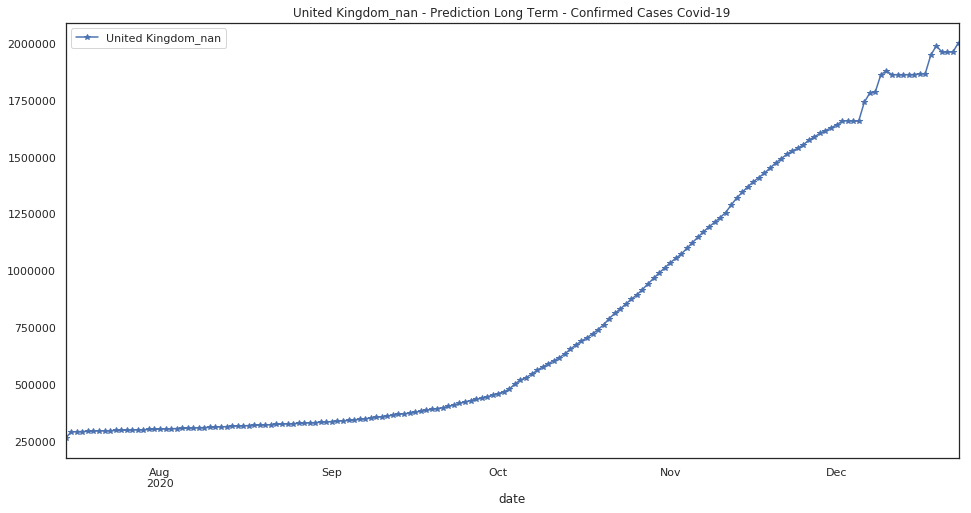

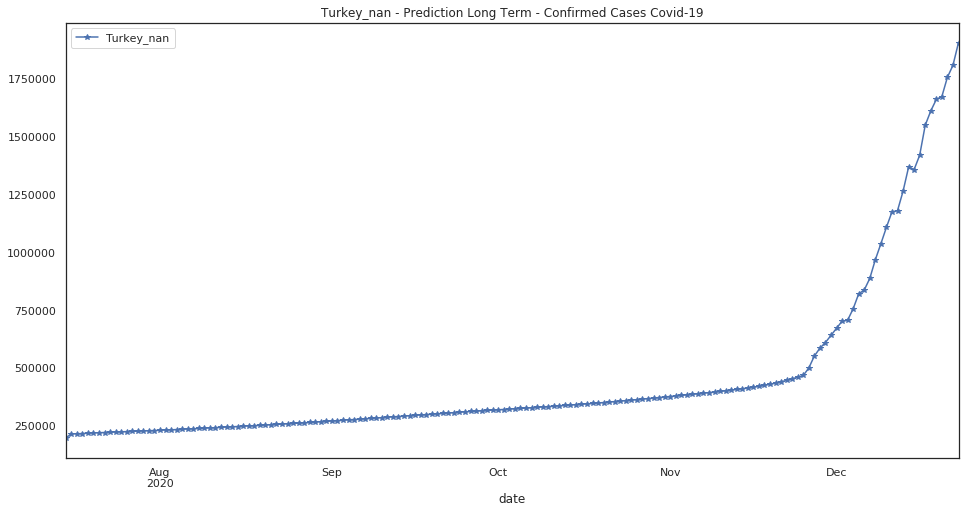

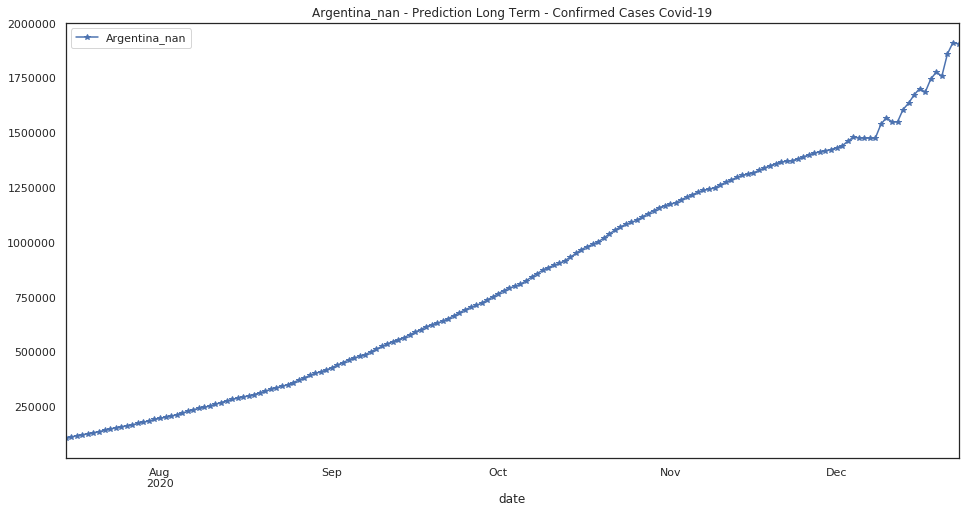

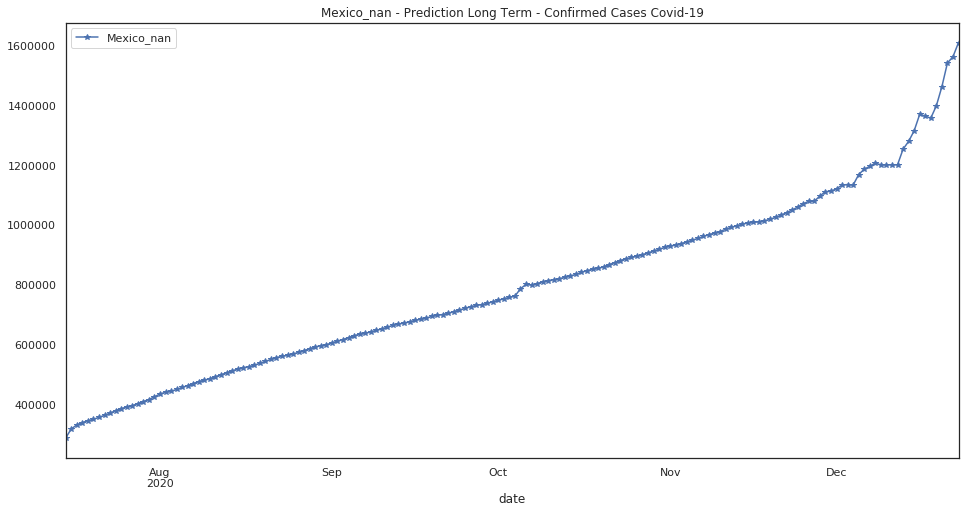

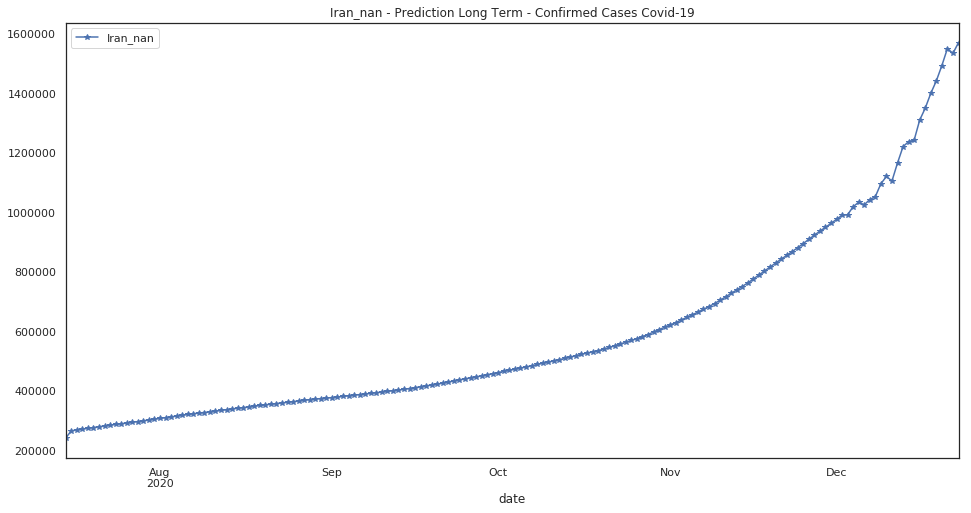

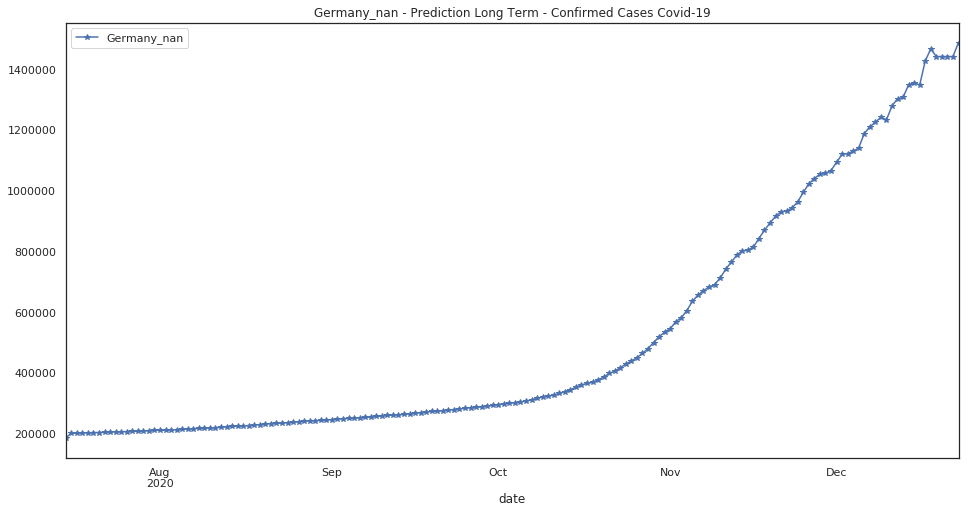

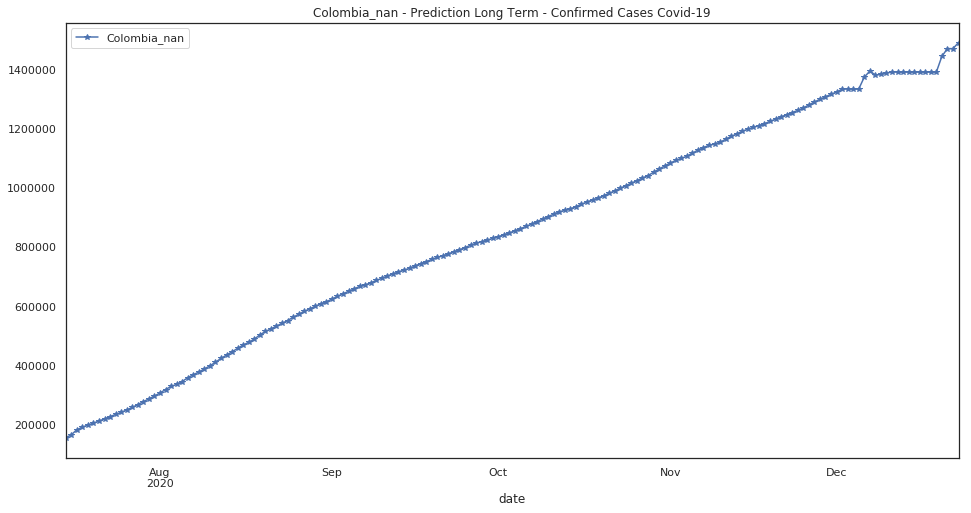

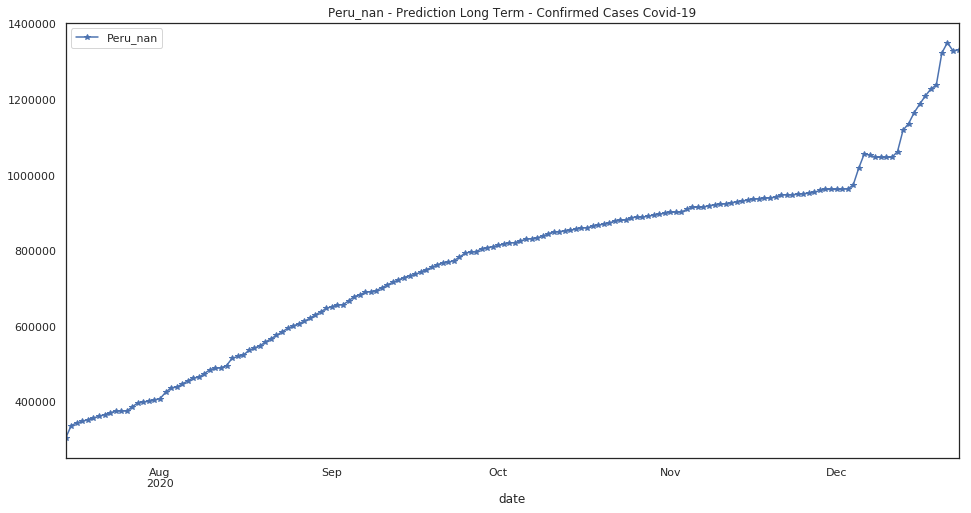

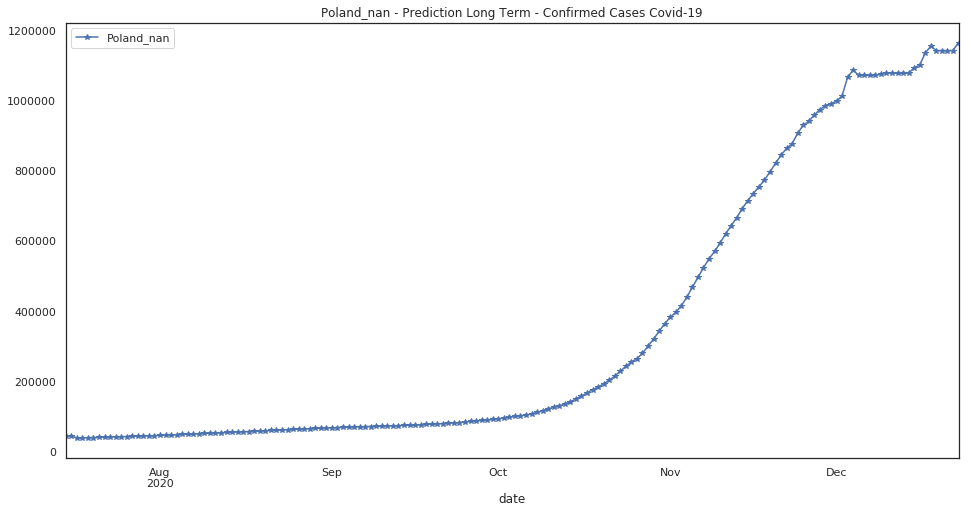

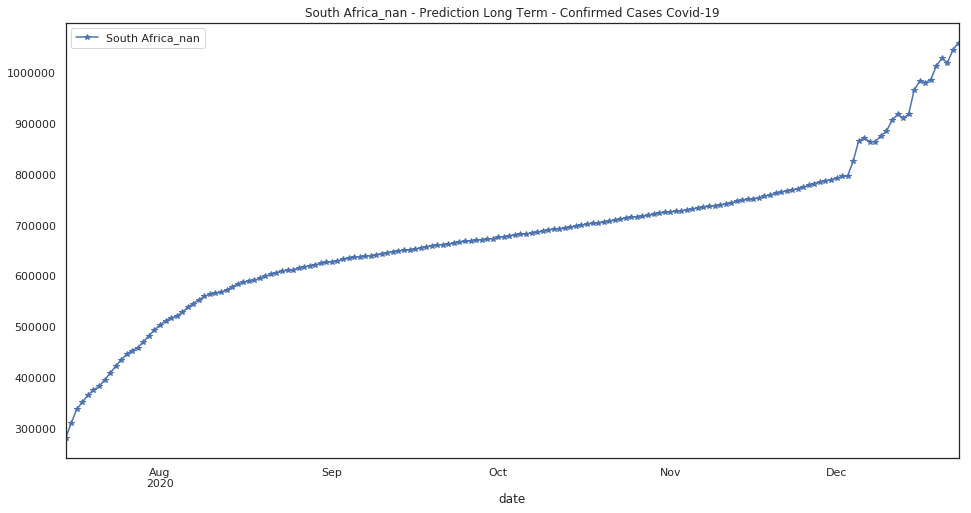

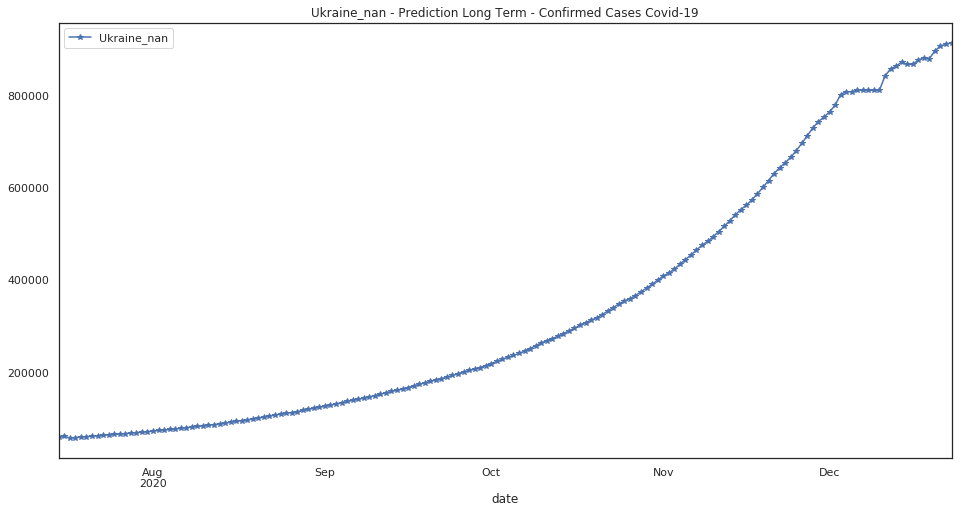

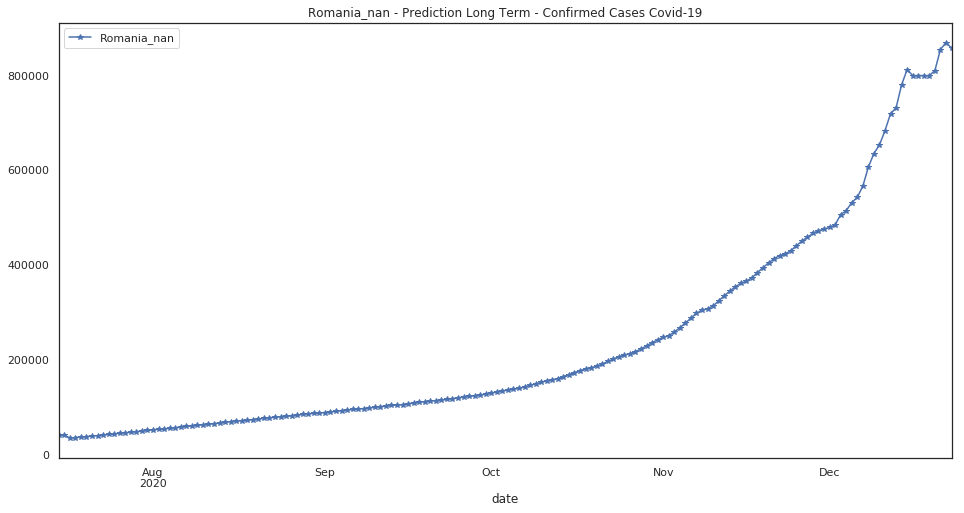

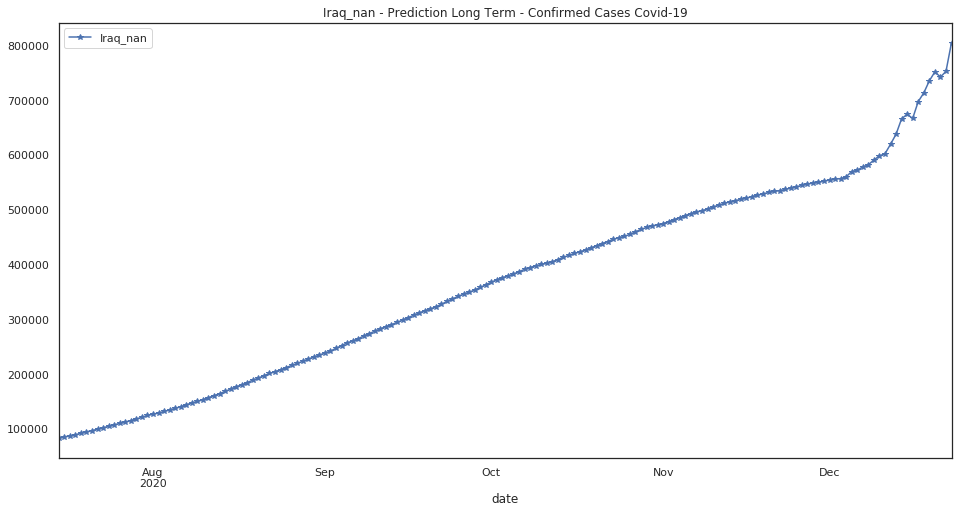

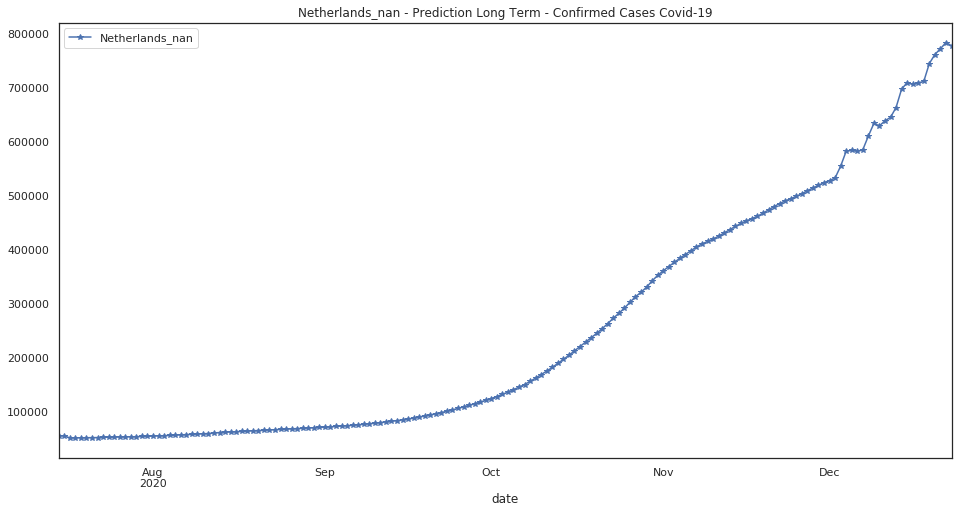

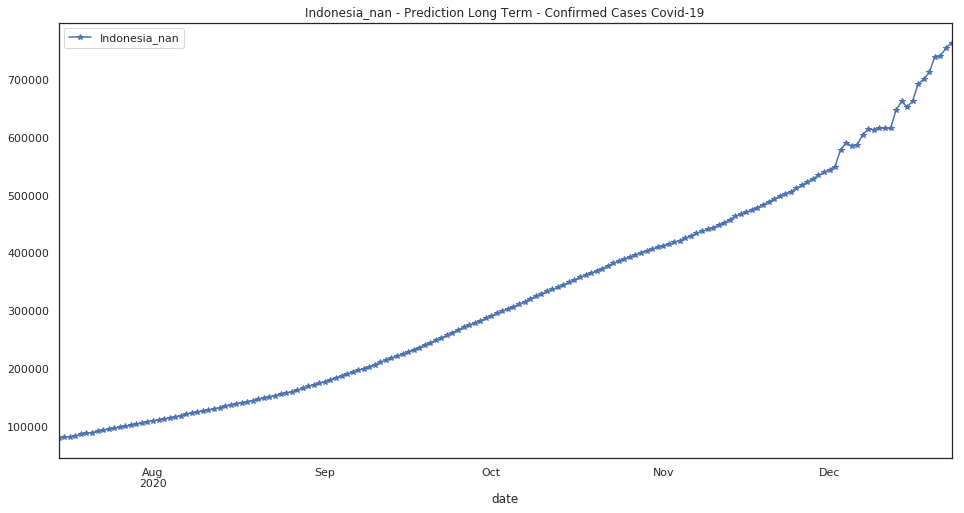

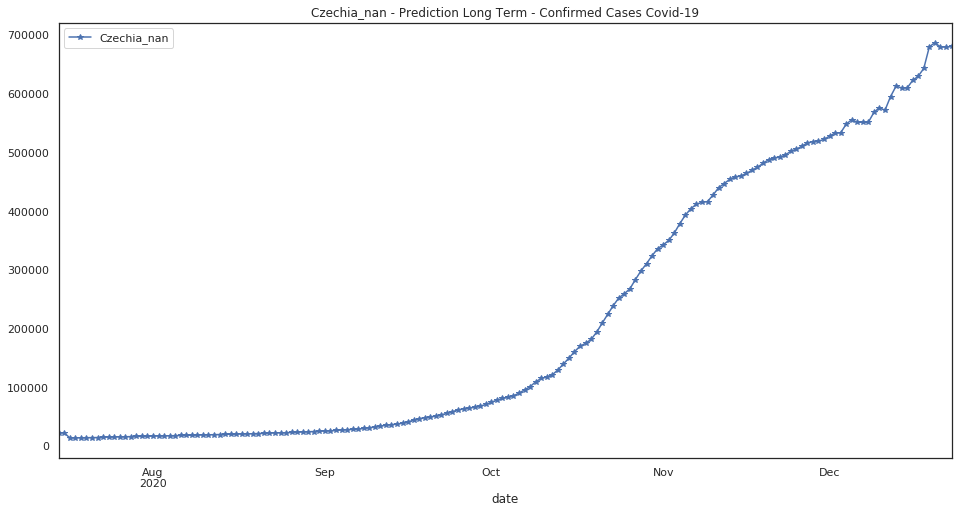

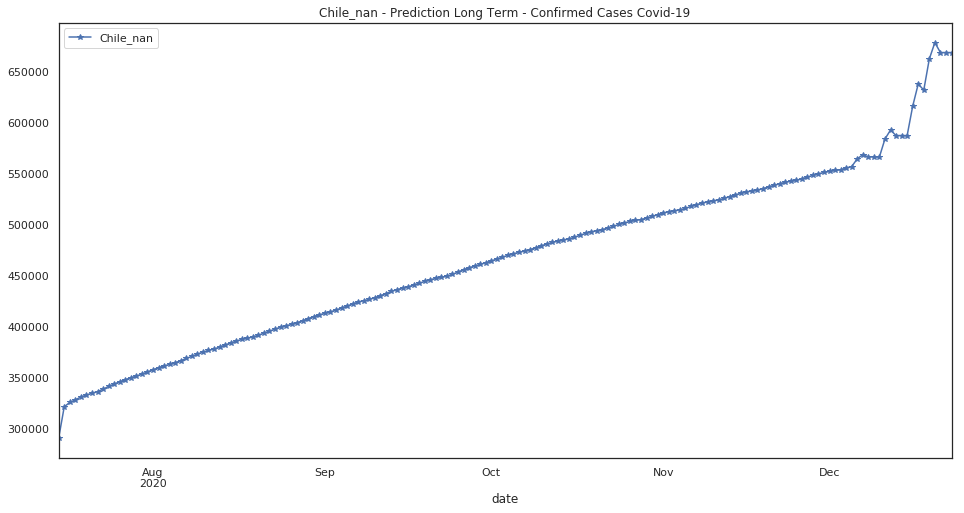

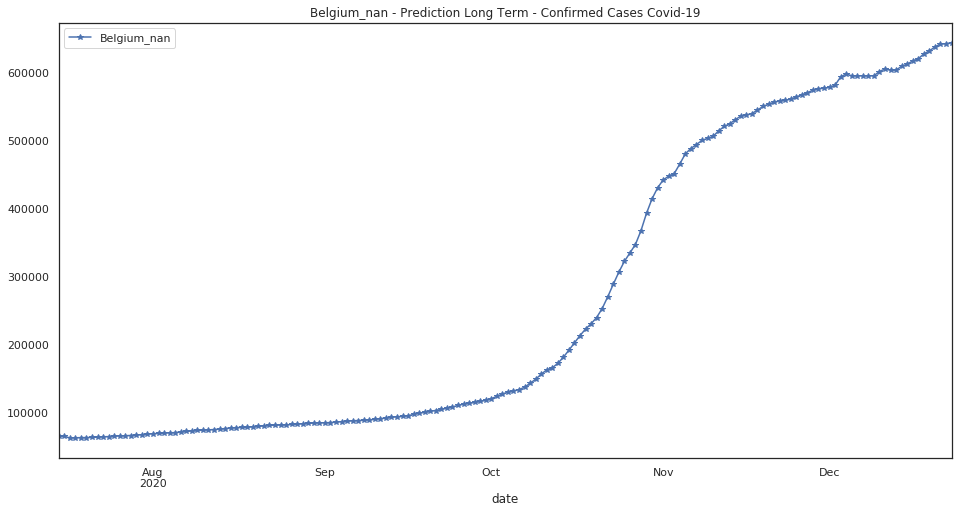

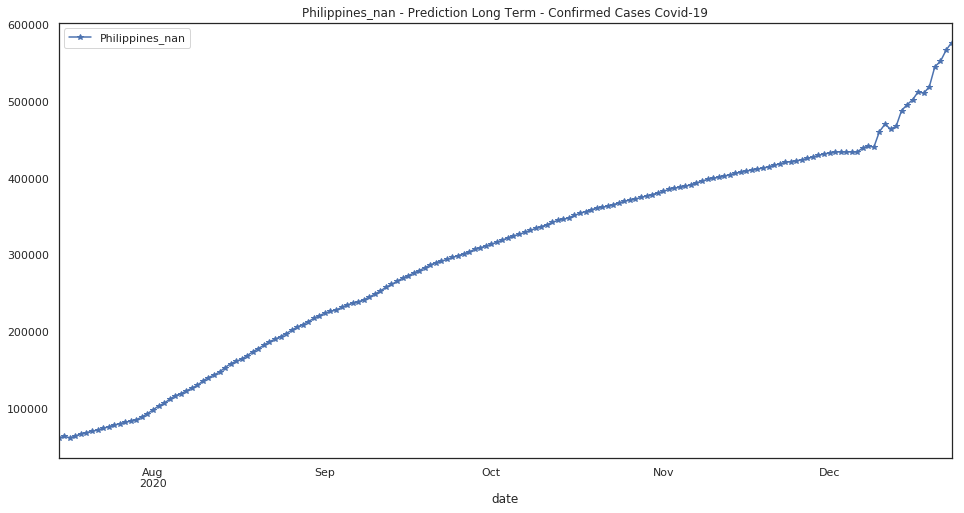

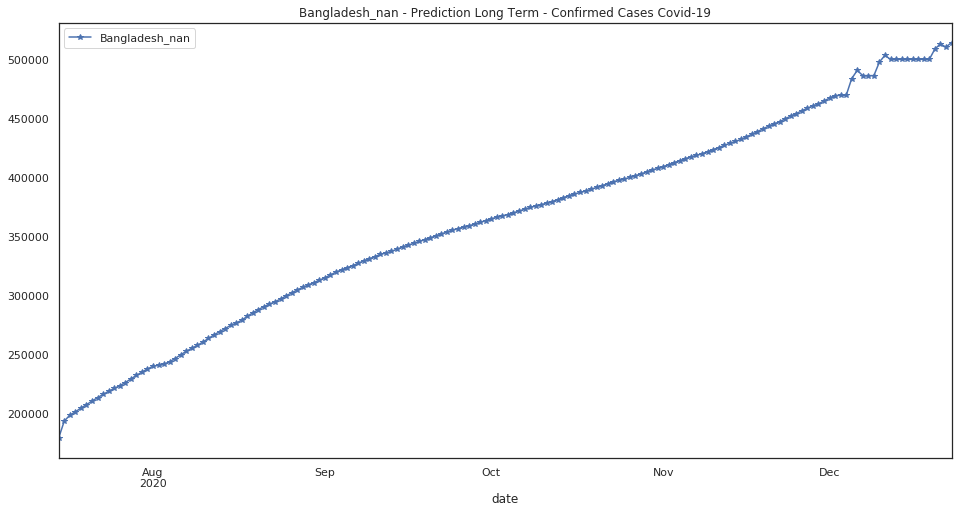

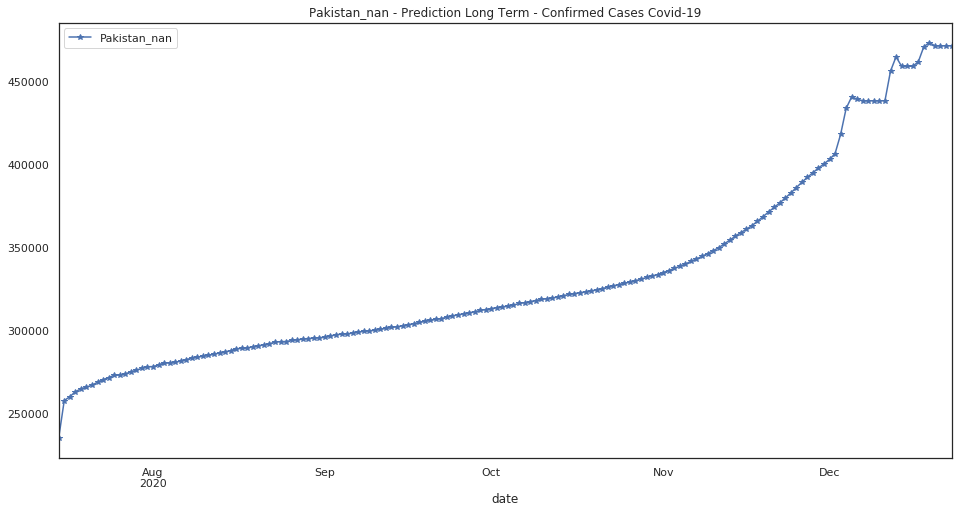

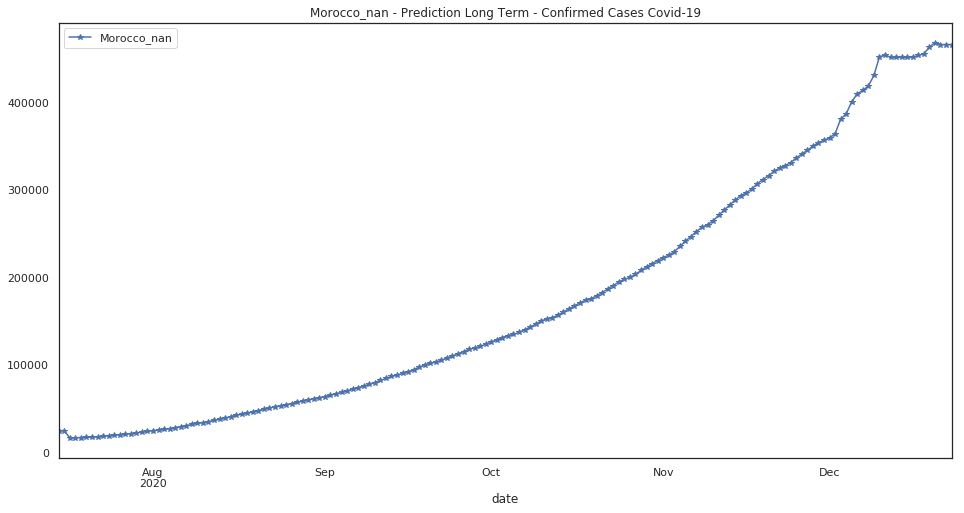

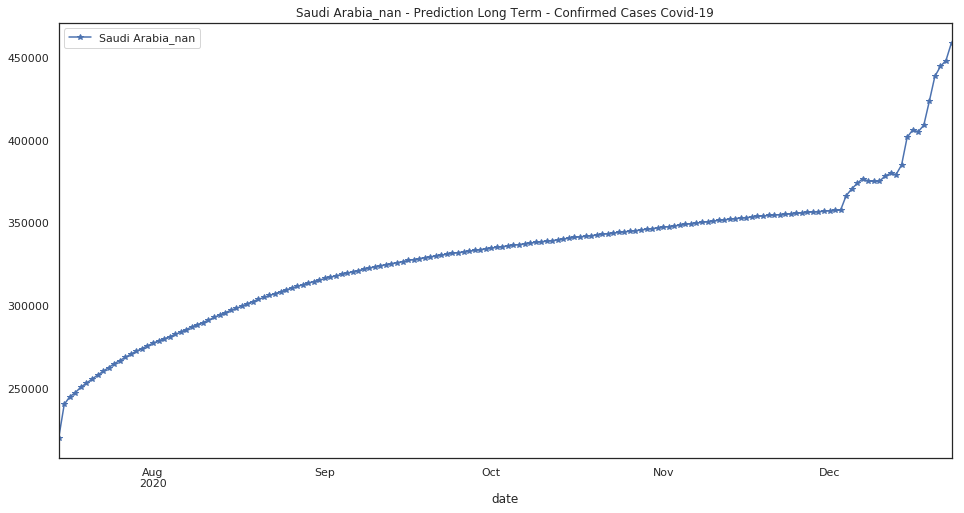

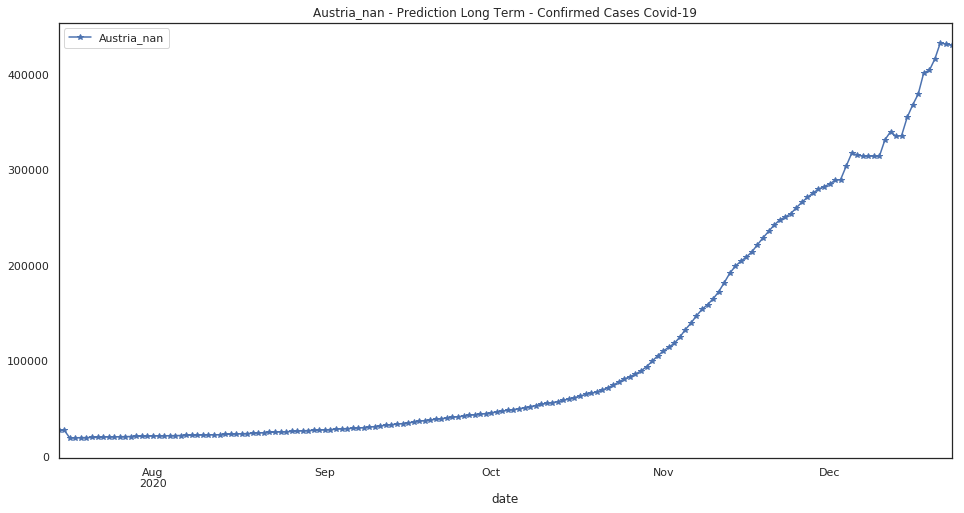

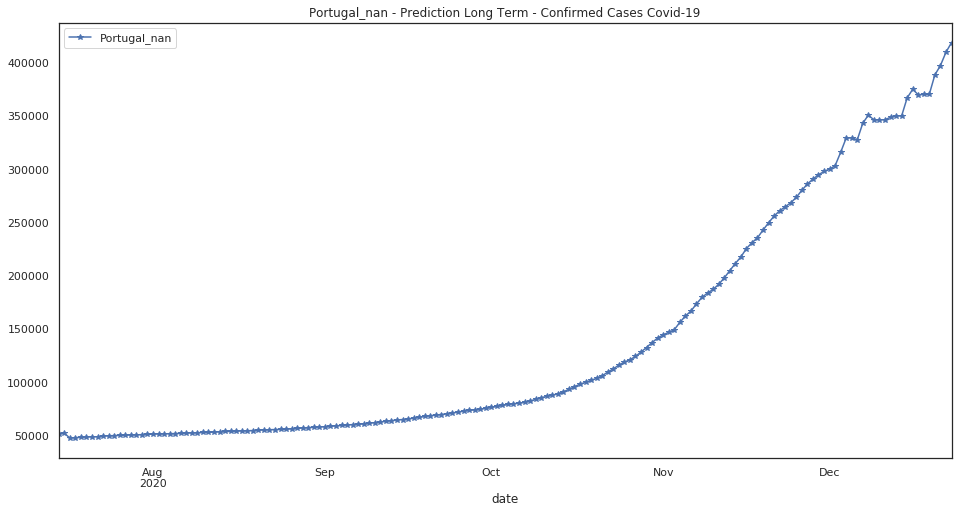

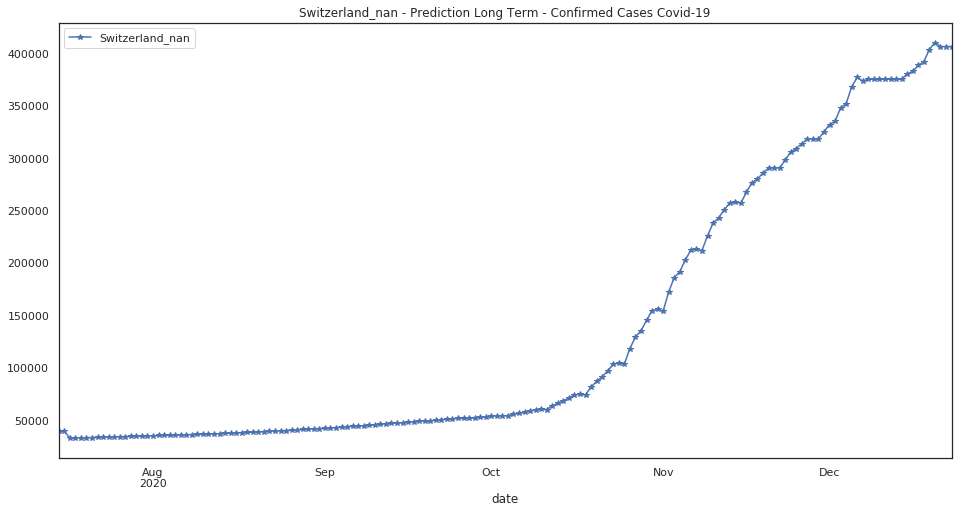

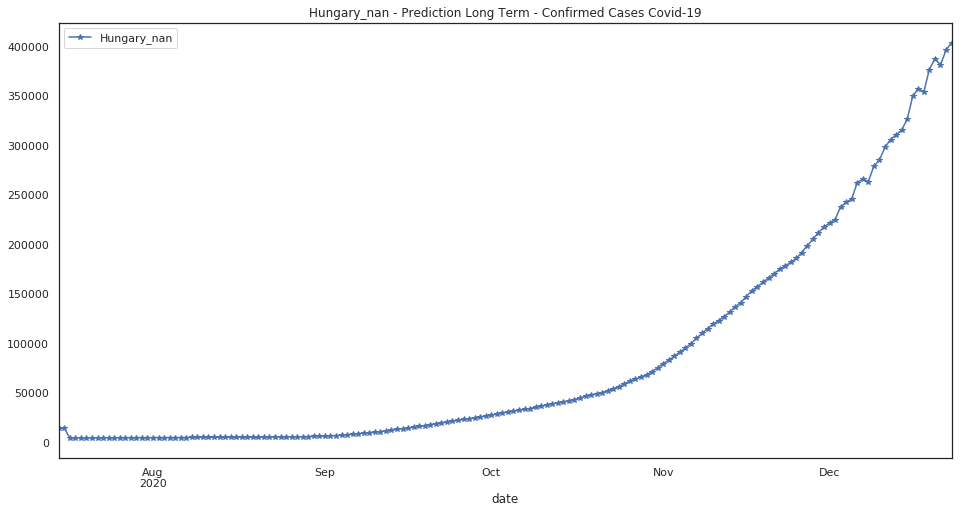

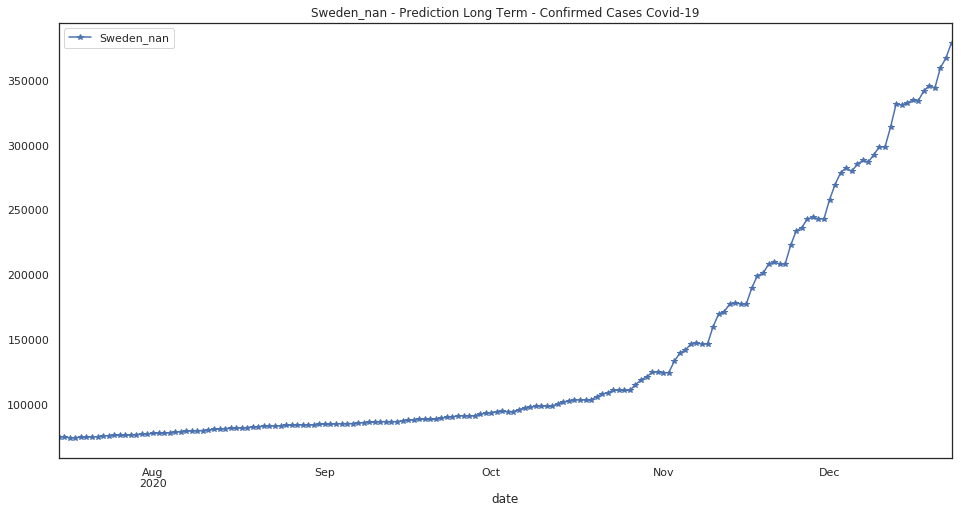

In [77]:
#
rgsx=region[:35]
for i in range (0,len(rgsx)):
        rg_print=rgsx[i]
        pred_prg=pd.DataFrame()
        pred_prg=pred[rg_print]
        pred_prg[:].plot(marker='*',figsize=(16,8),title =rg_print+' - Prediction Long Term - Confirmed Cases Covid-19')
        plt.legend(loc = 'upper left')
        plt.show()
#

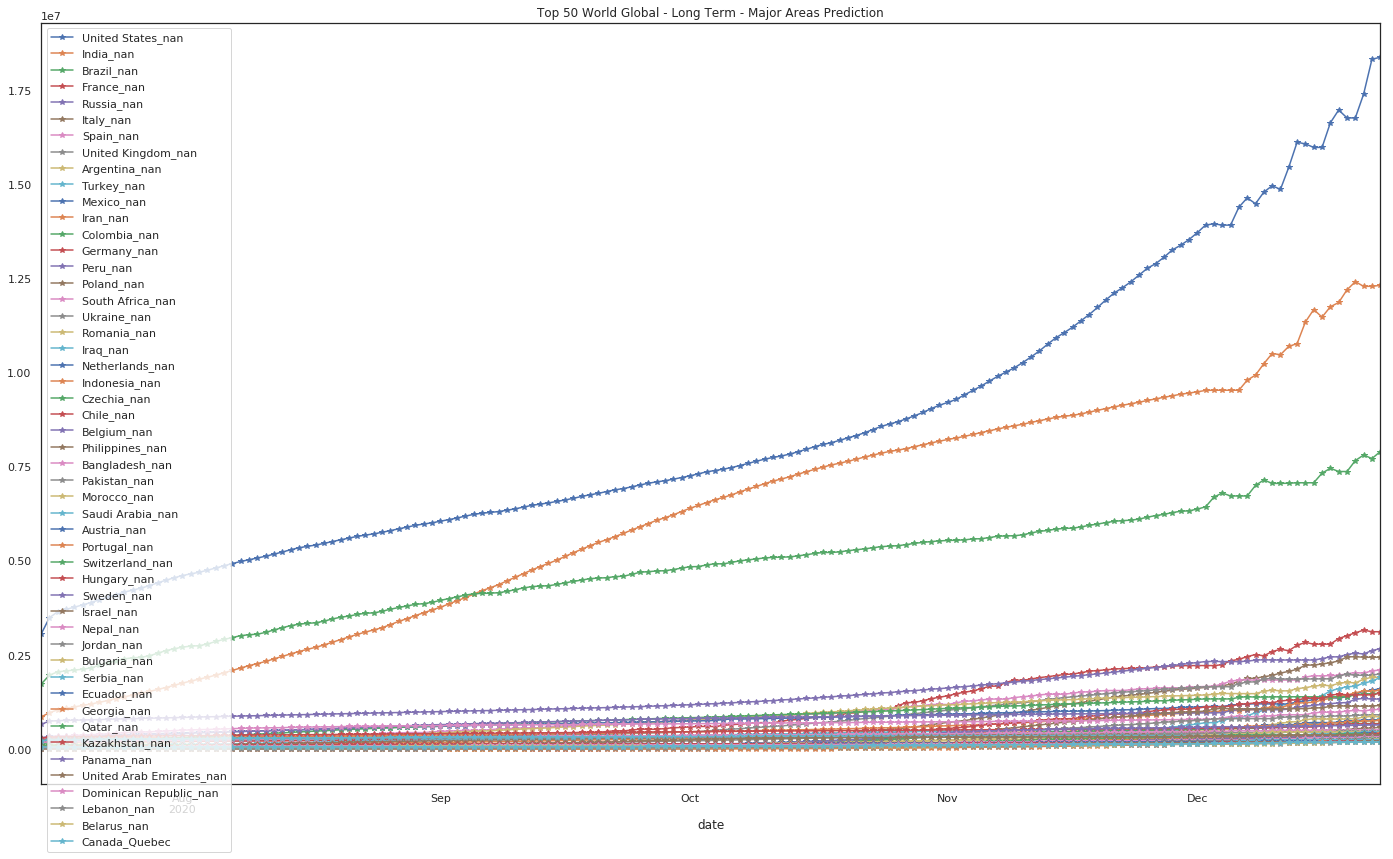

In [78]:
#region=my_train_list
pv2=pred
pv2=pv2.reindex(pv2.max().sort_values(ascending=False).index, axis=1)
pv2[:].iloc[:,0:50].plot(marker='*',figsize=(24,14),title ='Top 50 World Global - Long Term - Major Areas Prediction')
plt.legend(loc = 'upper left')
plt.show()

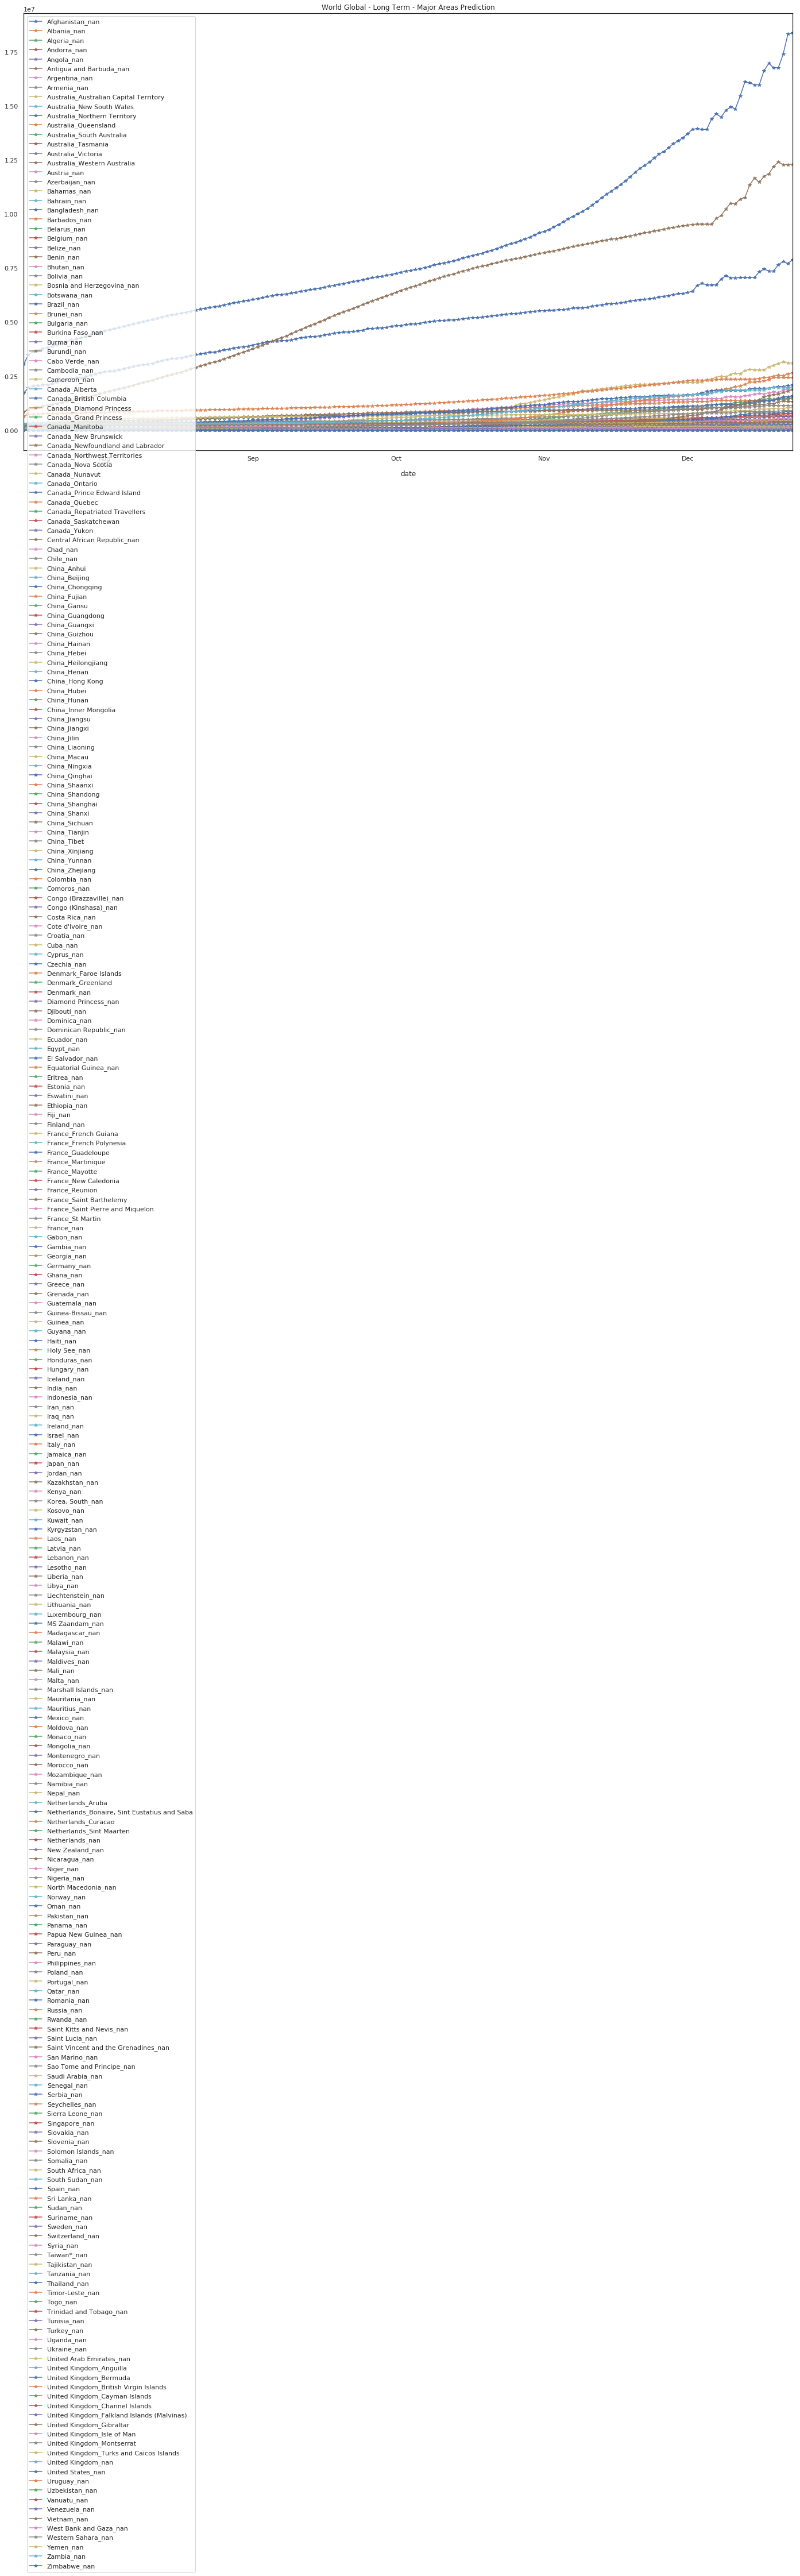

In [79]:
#region=my_train_list
pv2=pred
pv2[:].plot(marker='*',figsize=(24,14),title ='World Global - Long Term - Major Areas Prediction')
plt.legend(loc = 'upper left')
plt.show()


## Prediction Heatmap

In [80]:
pv1=pv2[:] #p  #p2.append(p3).append(p4).append(p5).append(p6).append(p8).append(p9).append(p11)
p=pd.DataFrame(pv1)

In [81]:
p[45:]

region      Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  \
date                                                                 
2020-08-29          38231.0       9326.0      43846.0       1124.0   
2020-08-30          38250.0       9442.0      44212.0       1175.0   
2020-08-31          38257.0       9549.0      44561.0       1220.0   
2020-09-01          38287.0       9619.0      44900.0       1176.0   
2020-09-02          38336.0       9773.0      45226.0       1201.0   
2020-09-03          38382.0       9865.0      45538.0       1199.0   
2020-09-04          38402.0       9991.0      45842.0       1257.0   
2020-09-05          38421.0      10122.0      46141.0       1215.0   
2020-09-06          38487.0      10265.0      46434.0       1249.0   
2020-09-07          38582.0      10406.0      46724.0       1289.0   
2020-09-08          38618.0      10559.0      47009.0       1261.0   
2020-09-09          38640.0      10716.0      47288.0       1340.0   
2020-09-10          38667.0      10869.0      47560.0       1301.0   
2020-09-11          38699.0      11027.0      47825.0       1379.0   
2020-09-12          38734.0      11190.0      48080.0       1344.0   
2020-09-13          38804.0      11358.0      48328.0       1387.0   
2020-09-14          38865.0      11524.0      48570.0       1469.0   
2020-09-15          38909.0      11680.0      48808.0       1438.0   
2020-09-16          38949.0      11835.0      49040.0       1549.0   
2020-09-17          38969.0      11973.0      49268.0       1483.0   
2020-09-18          38991.0      12104.0      49488.0       1589.0   
2020-09-19          39014.0      12256.0      49699.0       1564.0   
2020-09-20          39125.0      12397.0      49902.0       1616.0   
2020-09-21          39172.0      12547.0      50099.0       1718.0   
2020-09-22          39192.0      12688.0      50290.0       1681.0   
2020-09-23          39238.0      12820.0      50476.0       1800.0   
2020-09-24          39265.0      12956.0      50656.0       1753.0   
2020-09-25          39281.0      13073.0      50831.0       1852.0   
2020-09-26          39288.0      13188.0      50993.0       1836.0   
2020-09-27          39319.0      13302.0      51145.0       1854.0   
...                     ...          ...          ...          ...   
2020-11-24          45257.0      34217.0      77034.0       6304.0   
2020-11-25          45458.0      34876.0      78095.0       6351.0   
2020-11-26          45676.0      35534.0      79154.0       6428.0   
2020-11-27          45810.0      36178.0      80226.0       6534.0   
2020-11-28          45924.0      36734.0      81267.0       6610.0   
2020-11-29          46176.0      37530.0      82278.0       6610.0   
2020-11-30          46360.0      38126.0      83254.0       6712.0   
2020-12-01          46759.0      38919.0      84204.0       6745.0   
2020-12-02          47069.0      39649.0      85136.0       6790.0   
2020-12-03          47088.0      39897.0      86878.0       6842.0   
2020-12-04          47067.0      39906.0      89241.0       7056.0   
2020-12-05          47062.0      40183.0      89800.0       7393.0   
2020-12-06          47060.0      41134.0      89447.0       7393.0   
2020-12-07          47563.0      41599.0      90193.0       7393.0   
2020-12-08          47686.0      41623.0      95524.0       7393.0   
2020-12-09          47946.0      43314.0      97199.0       7393.0   
2020-12-10          48023.0      43657.0      96113.0       7393.0   
2020-12-11          47987.0      43581.0      96113.0       7393.0   
2020-12-12          48271.0      43581.0      96113.0       7393.0   
2020-12-13          49228.0      43581.0      97161.0       7393.0   
2020-12-14          50660.0      45153.0      97565.0       7393.0   
2020-12-15          50892.0      46378.0      97353.0       7393.0   
2020-12-16          51857.0      47894.0      99004.0       7393.0   
2020-12-17          52135.0      48880.0     102407.0       7424.0   
2020-12-18

In [82]:
pfname='data/p+'+str(num_days_R_prediction)+'_confirmed_daily.csv'
p.to_csv(pfname, index = False, header=True)

In [83]:
#!pip install gmplot
# Import the necessary libraries
import pandas as pd
import gmplot
# For improved table display in the notebook
#from IPython.display import display
import random 

In [84]:
heatmap=confirmed[['region','Lat','Long']]
p_m=p.T # pred.T #
### JOAO - Change Global HeapMap print - USA is too small, as USA States datasets are not used! 
#heatmap=heatmap[heatmap['region'].isin(region)]  ## heatmap for region dataset only 
heatmap=heatmap[heatmap['region'].isin(confirmed['region'])] ## Global heatmap
p_m=p_m.reset_index()
heatmap_m=heatmap.merge(p_m,how='left',on='region')


In [85]:
heatmap_m[:]

region        Lat        Long  \
0                               Afghanistan_nan  33.939110   67.709953   
1                                   Albania_nan  41.153300   20.168300   
2                                   Algeria_nan  28.033900    1.659600   
3                                   Andorra_nan  42.506300    1.521800   
4                                    Angola_nan -11.202700   17.873900   
5                       Antigua and Barbuda_nan  17.060800  -61.796400   
6                                 Argentina_nan -38.416100  -63.616700   
7                                   Armenia_nan  40.069100   45.038200   
8        Australia_Australian Capital Territory -35.473500  149.012400   
9                     Australia_New South Wales -33.868800  151.209300   
10                 Australia_Northern Territory -12.463400  130.845600   
11                         Australia_Queensland -27.469800  153.025100   
12                    Australia_South Australia -34.928500  138.600700   
13                           Australia_Tasmania -42.882100  147.327200   
14                           Australia_Victoria -37.813600  144.963100   
15                  Australia_Western Australia -31.950500  115.860500   
16                                  Austria_nan  47.516200   14.550100   
17                               Azerbaijan_nan  40.143100   47.576900   
18                                  Bahamas_nan  25.025885  -78.035889   
19                                  Bahrain_nan  26.027500   50.550000   
20                               Bangladesh_nan  23.685000   90.356300   
21                                 Barbados_nan  13.193900  -59.543200   
22                                  Belarus_nan  53.709800   27.953400   
23                                  Belgium_nan  50.833300    4.469936   
24                                   Belize_nan  17.189900  -88.497600   
25                                    Benin_nan   9.307700    2.315800   
26                                   Bhutan_nan  27.514200   90.433600   
27                                  Bolivia_nan -16.290200  -63.588700   
28                   Bosnia and Herzegovina_nan  43.915900   17.679100   
29                                 Botswana_nan -22.328500   24.684900   
..                                          ...        ...         ...   
247                             Timor-Leste_nan  -8.874217  125.727539   
248                                    Togo_nan   8.619500    0.824800   
249                     Trinidad and Tobago_nan  10.691800  -61.222500   
250                                 Tunisia_nan  33.886917    9.537499   
251                                  Turkey_nan  38.963700   35.243300   
252                           United States_nan  40.000000 -100.000000   
253                                  Uganda_nan   1.373333   32.290275   
254                                 Ukraine_nan  48.379400   31.165600   
255                    United Arab Emirates_nan  23.424076   53.847818   
256                     United Kingdom_Anguilla  18.220600  -63.068600   
257                      United Kingdom_Bermuda  32.307800  -64.750500   
258       United Kingdom_British Virgin Islands  18.420700  -64.640000   
259               United Kingdom_Cayman Islands  19.313300  -81.254600   
260              United Kingdom_Channel Islands  49.372300   -2.364400   
261  United Kingdom_Falkland Islands (Malvinas) -51.796300  -59.523600   
262                    United Kingdom_Gibraltar  36.140800   -5.353600   
263                  United Kingdom_Isle of Man  54.236100   -4.548100   
264                   United Kingdom_Montserrat  16.742498  -62.187366   
265     United Kingdom_Turks and Caicos Islands  21.694000  -71.797900   
266                          United Kingdom_nan  55.378100   -3.436000   
267                                 Uruguay_nan -32.522800  -55.765800   
268                              Uzbekistan_nan  41.377491   64.585262   
269                                 Vanuatu_n

In [86]:
#!pip install folium
import folium
import re

lat=40.99474
lang=6.87237

p21_cluster=folium.Map(location=[lat,lang],zoom_start=2)
from folium import plugins
cluster=plugins.MarkerCluster().add_to(p21_cluster)

colors={'A':'darkgreen','B':'darkpurple','C':'pink','D':'beige','E':'red','F':'lightblue','G':'darkblue','H':'cadetblue','I':'gray',
        'J':'lightred','K':'blue','L':'orange','M':'lightgreen','N':'orange','O':'purple','P':'lightgray','Q':'darkred','R':'green',
        'S':'black','T':'blue','U':'purple','V':'green','X':'blue','Y':'beige','W':'pink','Z':'white'}

date_pred=(datetime.today()+pd.DateOffset(days=num_days_R_prediction)).strftime('%Y-%m-%d')
ndaysavg=num_days_R_prediction
ndayarray=-1-num_days_R_prediction

for lat,lng,num,totpred,ldaygrowth in zip(heatmap_m.Lat,heatmap_m.Long,range(0,heatmap_m.shape[0]), heatmap_m[heatmap_m.columns[-1]],  (heatmap_m[heatmap_m.columns[-1]]-heatmap_m[heatmap_m.columns[ndayarray]])/ndaysavg ):
    use_color=heatmap_m['region'][num][0]
    print_region=re.sub('_nan',  '', heatmap_m['region'][num])
    popup = folium.Popup( print_region+' ConfirmedPred='+str(round(totpred))+' 1DayChangePred='+str(round(ldaygrowth))+' Date='+date_pred , parse_html=True)
    #
    folium.Marker(
                    [lat,lng],
                    popup=popup,
                    icon=folium.Icon(color=colors[use_color])
            ).add_to(p21_cluster)
p21_cluster

ValueError: Location values cannot contain NaNs.

In [87]:
# Top 50 Regions in the World impacted
#
max_cont=max_countries_map
region_m2=region[:max_cont]
#
heatmap_m2=heatmap_m[heatmap_m['region'].isin(region_m2)].reset_index()
#
heatmap_m2[:]

index                    region        Lat        Long  \
0       6             Argentina_nan -38.416100  -63.616700   
1      16               Austria_nan  47.516200   14.550100   
2      20            Bangladesh_nan  23.685000   90.356300   
3      22               Belarus_nan  53.709800   27.953400   
4      23               Belgium_nan  50.833300    4.469936   
5      30                Brazil_nan -14.235000  -51.925300   
6      32              Bulgaria_nan  42.733900   25.485800   
7      59                 Chile_nan -35.675100  -71.543000   
8      93              Colombia_nan   4.570900  -74.297300   
9      99               Croatia_nan  45.100000   15.200000   
10    102               Czechia_nan  49.817500   15.473000   
11    109    Dominican Republic_nan  18.735700  -70.162700   
12    110               Ecuador_nan  -1.831200  -78.183400   
13    130                France_nan  46.227600    2.213700   
14    133               Georgia_nan  42.315400   43.356900   
15    134               Georgia_nan  42.315400   43.356900   
16    135               Germany_nan  51.165691   10.451526   
17    147               Hungary_nan  47.162500   19.503300   
18    149                 India_nan  20.593684   78.962880   
19    150             Indonesia_nan  -0.789300  113.921300   
20    151                  Iran_nan  32.427908   53.688046   
21    152                  Iraq_nan  33.223191   43.679291   
22    154                Israel_nan  31.046051   34.851612   
23    155                Israel_nan  31.046051   34.851612   
24    156                 Italy_nan  41.871940   12.567380   
25    159                Jordan_nan  31.240000   36.510000   
26    160            Kazakhstan_nan  48.019600   66.923700   
27    168               Lebanon_nan  33.854700   35.862300   
28    169               Lebanon_nan  33.854700   35.862300   
29    186                Mexico_nan  23.634500 -102.552800   
30    191               Morocco_nan  31.791700   -7.092600   
31    194                 Nepal_nan  28.166700   84.250000   
32    199           Netherlands_nan  52.132600    5.291300   
33    207              Pakistan_nan  30.375300   69.345100   
34    208                Panama_nan   8.538000  -80.782100   
35    211                  Peru_nan  -9.190000  -75.015200   
36    212           Philippines_nan  12.879721  121.774017   
37    213                Poland_nan  51.919400   19.145100   
38    214              Portugal_nan  39.399900   -8.224500   
39    215                 Qatar_nan  25.354800   51.183900   
40    216               Romania_nan  45.943200   24.966800   
41    217                Russia_nan  61.524010  105.318756   
42    224          Saudi Arabia_nan  23.885942   45.079162   
43    226                Serbia_nan  44.016500   21.005900   
44    234          South Africa_nan -30.559500   22.937500   
45    236                 Spain_nan  40.463667   -3.749220   
46    240                Sweden_nan  60.128161   18.643501   
47    241           Switzerland_nan  46.818200    8.227500   
48    251                Turkey_nan  38.963700   35.243300   
49    252         United States_nan  40.000000 -100.000000   
50    254               Ukraine_nan  48.379400   31.165600   
51    255  United Arab Emirates_nan  23.424076   53.847818   
52    266        United Kingdom_nan  55.378100   -3.436000   

    2020-07-15 00:00:00  2020-07-16 00:00:00  2020-07-17 00:00:00  \
0              107451.0             111146.0             118456.0   
1               27256.0              27357.0              19270.0   
2              179323.0             193590.0             198574.0   
3               67609.0              67766.0              65623.0   
4               65367.0              65687.0              63238.0   
5             1725096.0            1966748.0            2053969.0   
6               17425.0              17658.0               8144.0   
7              290573.0             321205.0             325462.0   
8              154546.0           

In [88]:
import folium
import re

lat=40.99474
lang=6.87237

p21_reg_cluster=folium.Map(location=[lat,lang],zoom_start=2)
from folium import plugins
cluster=plugins.MarkerCluster().add_to(p21_reg_cluster)

colors={'A':'darkgreen','B':'darkpurple','C':'pink','D':'beige','E':'red','F':'lightblue','G':'darkblue','H':'cadetblue','I':'gray',
        'J':'lightred','K':'blue','L':'orange','M':'lightgreen','N':'orange','O':'purple','P':'lightgray','Q':'darkred','R':'green',
        'S':'black','T':'blue','U':'purple','V':'green','X':'blue','Y':'beige','W':'pink','Z':'white'}

date_pred=(datetime.today()+pd.DateOffset(days=num_days_R_prediction)).strftime('%Y-%m-%d')
ndaysavg=num_days_R_prediction
ndayarray=-1-num_days_R_prediction

for lat2,lng2,num2,totpred2,ldaygrowth2 in zip(heatmap_m2.Lat,heatmap_m2.Long,range(0,heatmap_m2.shape[0]), heatmap_m2[heatmap_m2.columns[-1]], (heatmap_m2[heatmap_m2.columns[-1]]-heatmap_m2[heatmap_m2.columns[ndayarray]])/ndaysavg ):
    use_color2=heatmap_m2['region'][num2][0]
    print_region=re.sub('_nan',  '', heatmap_m2['region'][num2])
    popup2 = folium.Popup( print_region+' ConfirmedPred='+str(round(totpred2))+' 1DayChangePred='+str(round(ldaygrowth2))+' Date='+date_pred , parse_html=True)  
    #
    folium.Marker(
                    [lat2,lng2],
                    popup=popup2,
                    icon=folium.Icon(color=colors[use_color2])
            ).add_to(p21_reg_cluster)
p21_reg_cluster

In [89]:
#
datemap=datetime.today().strftime('%Y-%m-%d')
p21_cluster.save("heatmaps/Heatmap_Folium-Global-"+datemap+"-pred"+str(num_days_R_prediction)+"Days.html")
#
p21_reg_cluster.save("heatmaps/Heatmap_Folium-Regional-"+datemap+"-pred"+str(num_days_R_prediction)+"Days.html")

In [90]:
print("Stats and Forecast Done for Today!")
print("I'm done with this past month of March, April and May!")
print(" April-May-June-July are going to be hard with this Global Lock-Down!")

Stats and Forecast Done for Today!
I'm done with this past month of March, April and May!
 April-May-June-July are going to be hard with this Global Lock-Down!


In [91]:
exit()